## Load functions and data

In [1]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
from AirSeaFluxCode import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm_notebook as tqdm
from multitaper import MTSpec  #using German Prieto's multitaper package, https://github.com/gaprieto/multitaper
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

RuntimeWarning
# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=24)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext

# Manually create Line2D objects for legend handles
legend_handles = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')
]

def km_formatter(x, pos):
    return f'{x / 1000:.0f} km'

import matplotlib.cm as cm
colors = [cm.tab10(i) for i in range(10)]


## Load the data

In [2]:
def calc_tasf(ds,SST):

    air_hum = AirSeaFluxCode(np.asarray(ds["wind_speed"]),            # Wind speed 
                             np.asarray(ds["TEMP_AIR_MEAN"]), 
                             np.asarray(ds[SST]), 
                             "skin", 
                             meth = "C35", 
                             lat = np.asarray(ds["latitude"]),              # Latitude, 
                             hin = [3.68,2.5,2.5], 
                             hout = 10,
                             hum=["rh", np.asarray(ds["RH_MEAN"])], 
                             out_var = ['latent','sensible'])
        
    # Assign some flags or indicators to the 'flags' column
    ds['sensible'] = (list(ds.dims)[0]), air_hum['sensible']
    ds['latent'] = (list(ds.dims)[0]), air_hum['latent']
    ds['tasf'] = (list(ds.dims)[0]), air_hum['latent'] + air_hum['sensible']

    return ds

In [7]:
ds = xr.open_dataset("../data/ds20_ws_interp_na.nc").isel(time=slice(0,95630))

In [9]:
spd  = np.asarray(np.random.randint(0,high=20,size=len(ds.time)))                 # Wind speed - As measured by the mooring
t    = np.asarray(np.random.randint(5,high=15,size=len(ds.time)))                 # Wind speed - As measured by the mooring
rhum = np.asarray(np.random.randint(50,high=100,size=len(ds.time)))                 # Wind speed - As measured by the mooring
sst  = np.asarray(np.random.randint(8,high=12,size=len(ds.time)))                 # Wind speed - As measured by the mooring


air_hum = AirSeaFluxCode(spd,            # Wind speed 
                         t, 
                         sst, 
                         "skin", 
                         meth = "C35", 
                         lat = -45,#np.asarray(ds["latitude"]),              # Latitude, 
                         hin = [3.68,2.5,2.5], 
                         hout = 10,
                         hum=["rh", rhum], 
                         out_var = ['latent','sensible'])

# Assign some flags or indicators to the 'flags' column
ds['sensible'] = (list(ds.dims)[0]), air_hum['sensible']
ds['latent'] = (list(ds.dims)[0]), air_hum['latent']
ds['tasf'] = (list(ds.dims)[0]), air_hum['latent'] + air_hum['sensible']


IndexError: invalid index to scalar variable.

In [3]:
ds20 = xr.open_dataset("../data/ds20_ws_interp_na.nc").isel(time=slice(0,95630))
ds22 = xr.open_dataset("../data/ds22_ws_interp_na.nc").isel(time=slice(0,137268))
ds23 = xr.open_dataset("../data/ds23_ws_interp_na.nc").isel(time=slice(0,99996))

In [4]:
ds20 = calc_tasf(ds20,"TEMP_IR_SEA_WING_UNCOMP_MEAN")
ds22 = calc_tasf(ds22,"TEMP_IR_UNCOR_MEAN")
ds23 = calc_tasf(ds23,"TEMP_IR_UNCOR_MEAN")

In [13]:
variables = ['wind_speed', 'TEMP_AIR_MEAN', 'RH_MEAN', 'TEMP_CTD_RBR_MEAN', 'SAL_RBR_MEAN',"COG","HDG","tasf"]
names = ['wind', 'airt', 'rhum', 'sst', 'sss',"COG","HDG","tasf"]
titles = ['Wind speed', 'Air temperature', 'Relative humidity', 'Sea surface temperature', 'Sea surface salinity', "Course over ground", "Heading","Turbulent fluxes"]

ds20 = ds20[variables].rename({var: new_name for var, new_name in zip(variables, names)})
ds22 = ds22[variables].rename({var: new_name for var, new_name in zip(variables, names)})
ds23 = ds23[variables].rename({var: new_name for var, new_name in zip(variables, names)})

Calculate and plot spectra

In [14]:
def plot_ref_slope(fmin,fmax,f,ax,kvec=[2,3],col='Grey',lw=2,ls='--'):

    """ This function draws reference slopes (k=-2, k=-4 for instance)
    Arguments:
    fmin=frequency where to start the reference the slope
    fmax=fmin=frequency where to end the reference the slope
    f= y intercept of the slope
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    kvec=[2]: list containing the reference values of k, whose slope to draw
    col='k': colors of the slopes
    lw=2: linewidths of the slopes
    ls=--: linestyles of the slopes

    Author: Nicolas Barrier
    """

    x=np.linspace(fmin,fmax,5)
    
    for p in range(0,len(kvec)):
        k=kvec[p]
        y=np.log(f)+k*(np.log(fmin)-np.log(x[:]))
        yout=np.exp(y)
        ax.loglog(x,yout,color=col,linewidth=lw,linestyle=ls)
        ax.text(x[-3], yout[-1], r'      $k^{-' + str(k) + '}$', ha='left', va='center', color=col)

In [15]:
def plot_slope(xf,yf,N,fmin,fmax):
    """
    Output slope of spectral using defined boundaries
    """
    
    i=np.nonzero((xf>=fmin)&(xf<=fmax)&(xf!=0))[0]
    xf=xf[i]
    yf=yf[i]
    
    
    
   # y=2.0/N * np.abs(yf[0:N//2])
    Y=np.log(yf)
    X=np.log(xf)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

    #confidence_interval = 2.58*std_err #99%
    confidence_interval = 1.96*std_err #95%


    p=np.polyfit(X,Y,1)

    offy=1

    trend=np.exp(p[0]*X+p[1]+offy)
    xvalue=xf
    return trend,slope,intercept,xvalue,confidence_interval

## Calculate multitaper arrays

In [16]:
P = 32
dt = 1/1440
mt32 = []

for ds in tqdm([ds20, ds22, ds23], desc='Processing datasets'):
    ms = []
    for var in tqdm(names, desc='Processing variables', leave=False):
        cv = ds[var].values
        spec = MTSpec(cv - np.mean(cv), nw=P, dt=dt, iadapt=0, nfft=len(cv))
        ms.append(spec)
    mt32.append(ms)

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000
DPSS using interpolation 137268 100000


Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
import spectrum
from scipy import stats, fft  # Used for 2D binned statistics

In [49]:
import numpy as np
import scipy.signal as sg
from tqdm import tqdm

def spectral_analysis_mtmethod(datasets, names, NW=32, dt=1/1440):
    """
    Perform spectral analysis using Multitaper Method (MTM).

    The Multitaper Method (MTM) is a spectral analysis technique used to estimate
    the power spectral density (PSD) of a time series signal. It employs multiple
    orthogonal tapers to achieve high resolution and low variance in spectral estimation.

    Parameters:
    -----------
    datasets : list
        List of datasets to process, each containing time series data.

    names : list
        List of variable names to analyze within each dataset.

    NW : int, optional
        Time-half bandwidth parameter for the MTM. Higher values result in better
        frequency resolution but increased variance. Default is 32.

    dt : float, optional
        Sampling interval of the time series data. It represents the reciprocal of
        the sampling frequency. Default is 1/1440.

    Returns:
    --------
    cvs : list
        List of centered time series data for each variable and dataset.

    f0s : list
        List of frequency components for each variable and dataset.

    S0s : list
        List of power spectral density estimates for each variable and dataset.

    mt32 : list
        List of MTM results (PSD estimates) for each variable and dataset.

    Theory:
    -------
    The MTM aims to improve spectral estimation by utilizing multiple orthogonal
    tapers (slepian sequences). It calculates the PSD by averaging the spectra
    obtained from each taper, resulting in enhanced frequency resolution and reduced
    variance, especially for short and noisy time series data.

    Usage:
    ------
    1. Define the datasets and variable names to analyze.
    2. Call the function `spectral_analysis_mtmethod` with the datasets and variable
       names as input.
    3. Access the processed data, including centered time series, frequency
       components, PSD estimates, and MTM results from the returned lists.

    Example:
    --------
    datasets = [ds20, ds22, ds23]
    variables = ["var1", "var2", "var3"]
    cvs, f0s, S0s, mt32 = spectral_analysis_mtmethod(datasets, variables)
    """
    cvs, f0s, S0s, mt32 = [], [], [], []
    
    # Process datasets
    for dataset in tqdm(datasets, desc='Processing datasets'):
        cv_list, f0_list, S0_list, mt_list = [], [], [], []
        
        # Process variables in the dataset
        for var in tqdm(names, desc='Processing variables', leave=False):
            Cv = dataset[var].values
            cv_centered = Cv - np.mean(Cv)
            cv_list.append(cv_centered)
            
            f, s = sg.periodogram(cv_centered, fs=1/dt)
            f0_list.append(f[f >= 0])
            S0_list.append(s[f >= 0])
            
            Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv_centered))
            Sk = np.abs(Sk_complex)**2
            Sk = Sk.T
            P = np.mean(Sk*eigenvalues, axis=1) * dt
            mt_list.append(P)
        
        # Store processed data for the dataset
        cvs.append(cv_list)
        f0s.append(f0_list)
        S0s.append(S0_list)
        mt32.append(mt_list)
    
    return cvs, f0s, S0s, mt32

Processing datasets: 100%|████████████████████████████████████████| 3/3 [01:27<00:00, 29.13s/it]


In [230]:
def spectral_analysis_mtmethod(datasets, dsnames, names, NW=32, dt=1/1440):
    """
    Perform spectral analysis using Multitaper Method (MTM) and organize the
    processed spectral data into a structured DataFrame.

    Parameters:
    -----------
    datasets : list
        List of datasets to process, each containing time series data.

    names : list
        List of variable names to analyze within each dataset.

    NW : int, optional
        Time-half bandwidth parameter for the MTM. Higher values result in better
        frequency resolution but increased variance. Default is 32.

    dt : float, optional
        Sampling interval of the time series data. It represents the reciprocal of
        the sampling frequency. Default is 1/1440.

    Returns:
    --------
    df : pandas DataFrame
        Structured DataFrame containing the processed spectral data with columns:
        ['Dataset', 'Variable', 'Frequency', 'PSD']

    Theory:
    -------
    The MTM aims to improve spectral estimation by utilizing multiple orthogonal
    tapers (slepian sequences). It calculates the PSD by averaging the spectra
    obtained from each taper, resulting in enhanced frequency resolution and reduced
    variance, especially for short and noisy time series data.

    Usage:
    ------
    1. Define the datasets and variable names to analyze.
    2. Call the function `spectral_analysis_mtmethod` with the datasets and variable
       names as input.
    3. Access the processed spectral data from the returned DataFrame.

    Example:
    --------
    datasets = [ds20, ds22, ds23]
    variables = ["var1", "var2", "var3"]
    df = spectral_analysis_mtmethod(datasets, variables)
    """
    spectral_data = []

    # Process datasets
    for dataset,dsname in tqdm(zip(datasets,dsnames), desc='Processing datasets'):
        for var in tqdm(names, desc='Processing variables', leave=False):
            cv_centered = (dataset[var] - np.nanmean(dataset[var])).interpolate_na('distance').values
            
            f, s = sg.periodogram(cv_centered, fs=1/dt)
            f0 = f[f >= 0]
            S0 = s[f >= 0]
            
            Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv_centered))
            Sk = np.abs(Sk_complex)**2
            Sk = Sk.T
            P = np.mean(Sk*eigenvalues, axis=1) * dt
            
            # Append processed spectral data to the list
            spectral_data.append({'Dataset': dsname, 'Variable': var, 'Frequency': f0, 'Spectra': S0, 'PSD': P[np.where(f >= 0)]})

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(spectral_data)
    
    return df

In [135]:
names

['wind', 'airt', 'rhum', 'sst', 'sss', 'COG', 'HDG', 'tasf']

In [136]:
# Define your datasets and variable names
datasets = [ds20, ds22, ds23]  # List of datasets
variables = names  # List of variable names
dsnames = ["1020", "1022", "1023"]  # List of variable names

# Call the spectral_analysis_mtmethod function
df = spectral_analysis_mtmethod(datasets, dsnames, variables)

# Now you can use the returned DataFrame `df` for further analysis, visualization, or export

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [157]:
# Create a list of DataArrays using list comprehension
sp20 = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds20', 'variable': row['Variable']})
        for _, row in df.iloc[:8].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp20 = xr.merge(sp20)

# Create a list of DataArrays using list comprehension
sp22 = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds22', 'variable': row['Variable']})
        for _, row in df.iloc[8:16].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp22 = xr.merge(sp22)

# Create a list of DataArrays using list comprehension
sp23 = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds23', 'variable': row['Variable']})
        for _, row in df.iloc[16:].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp23 = xr.merge(sp23)

In [175]:
def fix_spines(ax,c):
    for spine in ax.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

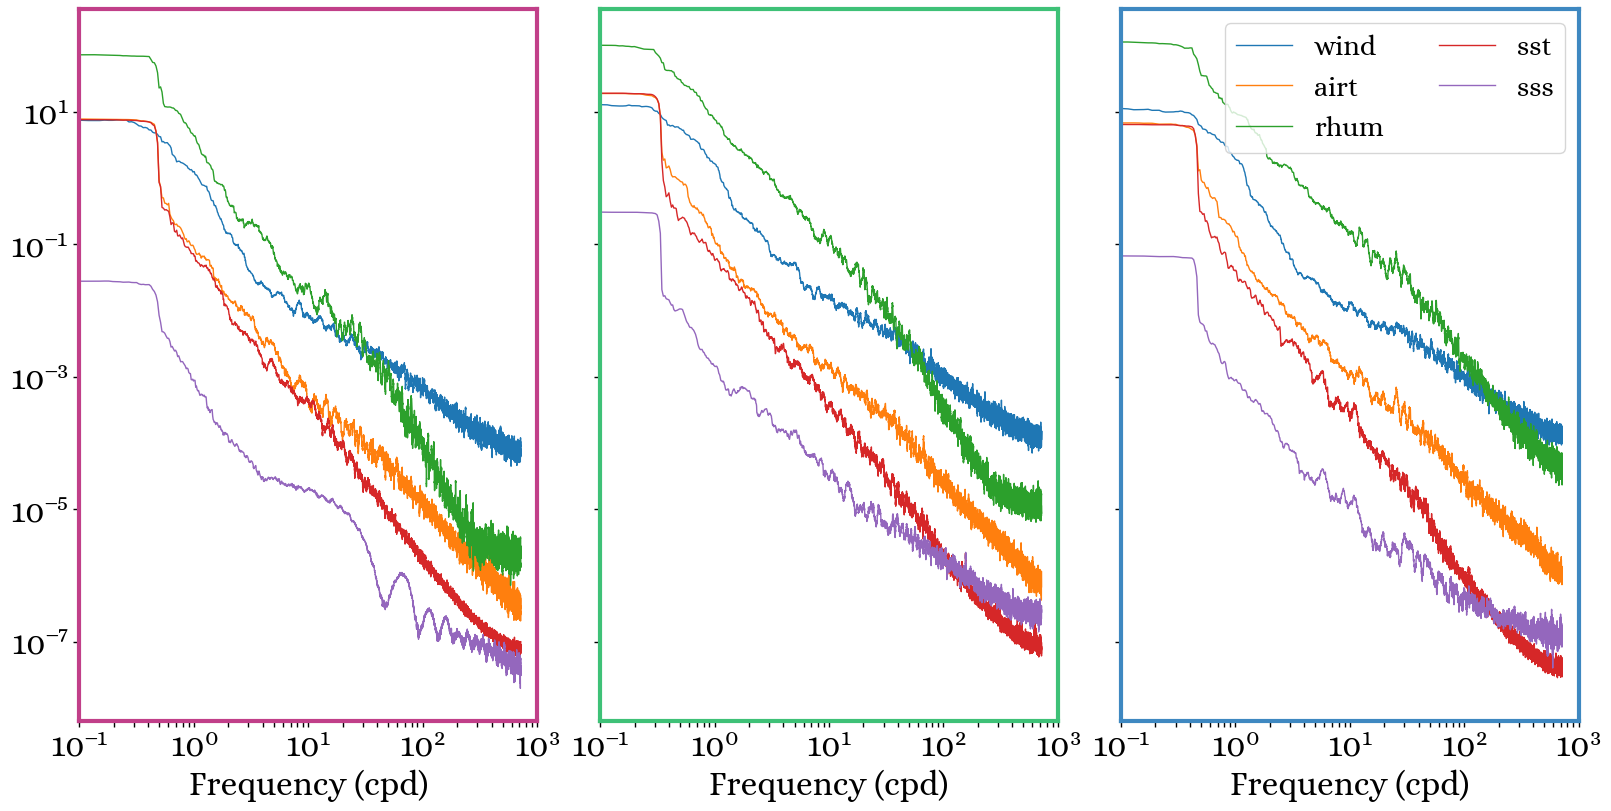

In [179]:
fig,ax = plt.subplots(1,3,figsize=(16,8),constrained_layout=True,sharey=True)

for name,c in zip(names[:-3],colors):
    for ds,axs,color in zip([sp20,sp22,sp23],ax,[c20,c22,c23]):
    
        ds[name].plot(x='frequency', lw=1, yscale='log', xscale='log', label=name, c=c, ax=axs)
        axs.set(xlim=(1e-1,1e3), xlabel="Frequency (cpd)", ylabel="")
        fix_spines(axs,color)

        
axs.legend(ncol=2, fontsize='small')


In [17]:
cvs = []
f0s = []
S0s = []

for ds in tqdm([ds20, ds22, ds23], desc='Processing datasets'):
    cv = []
    f0 = []
    S0 = []
    for var in tqdm(names, desc='Processing variables', leave=False):
        # Cv = np.abs(np.diff(ds[var].values))
        Cv = ds[var].values
        f,s = sg.periodogram(Cv - np.mean(Cv), fs=1/dt)
        cv.append(Cv)
        f0.append(f)
        S0.append(s)
        
    cvs.append(cv)
    f0s.append(f0)
    S0s.append(S0)

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [544]:
# Create lists to store variables for zipping
datasets = [ds20, ds22, ds23]
labels = ["SD1020", "SD1022", "SD1023"]
colors = [c20, c22, c23]
mt_results = testmt32

### Define variables
# names = ['wind', 'airt', 'rhum', 'sst', 'sss',"COG","HDG"]
# titles = ['Wind speed', 'Air temperature', 'Relative humidity', 'Sea surface temperature', 'Sea surface salinity', "Course over ground", "Heading"]
# units = ["m s$^{-1}$", "°C", "%", "°C", "PSU", "°", "°"]


### Some constants
# Define the time step (in days)
dt = 1/1440
# Define the number of tapers to use in multitaper analysis
P = 32

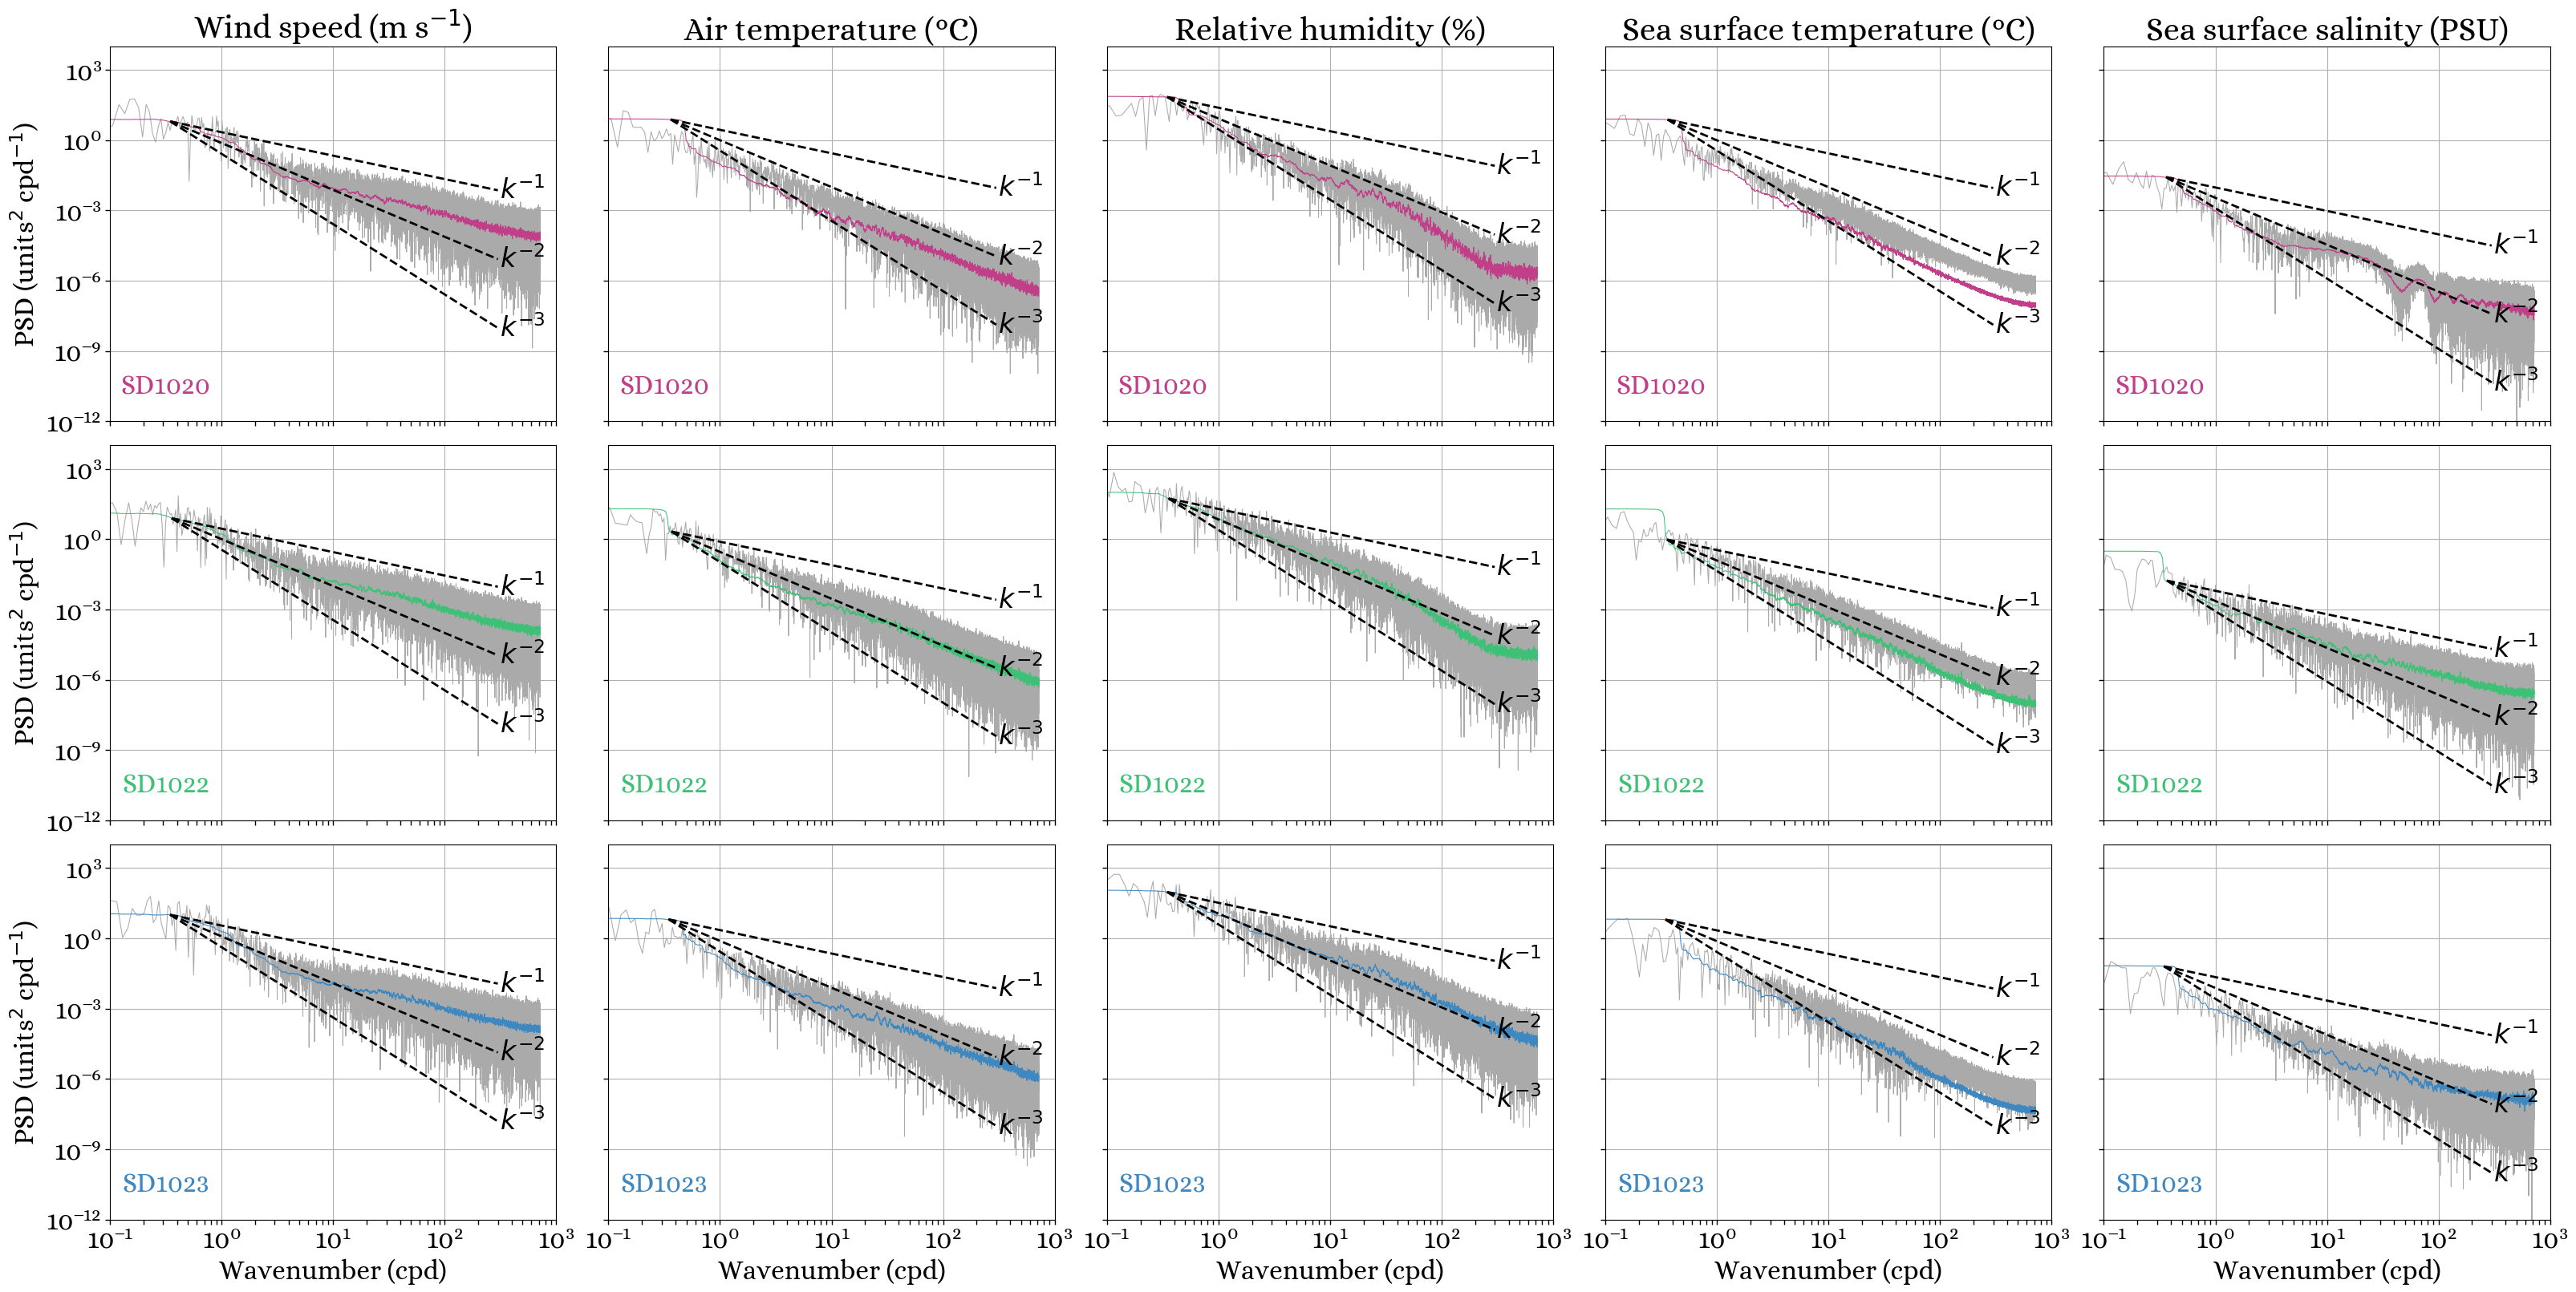

In [508]:
# Create a grid of subplots with 3 rows and 5 columns
fig, ax = plt.subplots(3, 5, figsize=(16*2, 8*2), constrained_layout=True, sharex=True, sharey=True)

# Iterate over each subplot row (i), dataset (ds), label (l), and color (c) using enumerate
for i, (AX, ds, l, c, ms, f0, S0) in enumerate(zip(ax, datasets, labels, colors, mt32, f0s, S0s)):
    # Iterate over each subplot column (j), variable (var), title (t), and unit (u) using enumerate
    for j, (axs, var, t, u, spec,f,S) in enumerate(zip(AX, names, titles, units, ms, f0, S0)):
        # Plot the periodogram and multitaper spectrum
        axs.loglog(f[np.where(f >= 0)], S[np.where(f >= 0)], linewidth=0.75, c="#AAAAAA")  # Periodogram
        axs.loglog(spec.freq[np.where(spec.freq >= 0)], spec.spec[np.where(spec.freq >= 0)], linewidth=0.75, c=c)  # Multitaper spectrum
        # Add label to the subplot
        axs.text(3.16e-1, 3.16e-11, l, c=c, va='center', ha='center', fontweight='bold')
        
        # Adjust subplot properties
        axs.autoscale(enable=True, tight=True)
        axs.set(xlim=(1e-1, 1e3),
                ylim=(1e-12, 1e4),
                xlabel="Wavenumber (cpd)" if "1023" in l else "" ,
                ylabel='PSD (units$^{2}$ cpd$^{-1}$)' if "wind" in var else "", 
                title=t+f" ({u})" if "1020" in l else "")
        axs.grid()
        
        idx = np.where(spec.spec[np.where(spec.freq >= 0)] > np.percentile(spec.spec[np.where(spec.freq >= 0)],99.95))[0][-1]

        # Plot reference slope
        plot_ref_slope(spec.freq[np.where(spec.freq >= 0)][idx],
                       3e2, 
                       spec.spec[np.where(spec.freq >= 0)][idx], ax=axs, kvec=[1, 2, 3], col='k')

In [509]:
1440/200

7.2

In [ ]:
for k in range(7):
    # Create a grid of subplots with 3 rows and 5 columns
    fig, ax = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True, sharex=True, sharey=True)

    # Iterate over each subplot row (i), dataset (ds), label (l), and color (c) using enumerate
    for i, (AX, ds, l, c, ms, f0, S0) in enumerate(zip(ax, datasets, labels, colors, mt_results, f0s, S0s)):
        # Iterate over each subplot column (j), variable (var), title (t), and unit (u) using enumerate
        for j, (axs, var, t, u, spec,f,S) in enumerate(zip([AX], names[k:], titles[k:], units[k:], ms[k:], f0[k:], S0[k:])):
            # Plot the periodogram and multitaper spectrum
            axs.loglog(f[np.where(f >= 0)], S[np.where(f >= 0)], linewidth=0.75, c="#AAAAAA")  # Periodogram
            axs.loglog(spec.freq[np.where(spec.freq >= 0)], spec.spec[np.where(spec.freq >= 0)], linewidth=0.75, c=c)  # Multitaper spectrum
            # Add label to the subplot
            axs.text(3.16e-1, 1e-11, l, c=c, va='center', ha='center', fontweight='bold')

            # Adjust subplot properties
            axs.autoscale(enable=True, tight=True)
            axs.set(#xlim=(1e-1, 1e3),
            #         ylim=(1e-12, 1e4),
                    xlabel="Wavenumber (cpd)" if "1023" in l else "" ,
                    ylabel='PSD (units$^{2}$ cpd$^{-1}$)' if i==0 else "", 
                    title=t+f" ({u})" if "1022" in l else "")
            axs.grid()

#             idx = np.where(spec.spec[np.where(spec.freq >= 0)] > np.percentile(spec.spec[np.where(spec.freq >= 0)],99.95))[0][-1]

#             # Plot reference slope
#             plot_ref_slope(spec.freq[np.where(spec.freq >= 0)][idx],
#                            3e2, 
#                            spec.spec[np.where(spec.freq >= 0)][idx], ax=axs, kvec=[1, 2, 3], col='k')

#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e0,1e1)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e1,1e2)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e2,1e3)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)

## Load the data

In [192]:
ds205 = xr.open_dataset("../data/sd1020_5min_1km.nc").interpolate_na().isel(distance=slice(0,-1))
ds225 = xr.open_dataset("../data/sd1022_5min_1km.nc").interpolate_na().isel(distance=slice(0,-1))
ds235 = xr.open_dataset("../data/sd1023_5min_1km.nc").interpolate_na().isel(distance=slice(0,-1))

In [246]:
titles = ['Wind speed', 'Air temperature', 'Relative humidity', 'Sea surface temperature', 'Sea surface salinity','Turbulent fluxes']

In [193]:
variables = ['wind_speed', 'TEMP_AIR_MEAN', 'RH_MEAN', 'TEMP_CTD_RBR_MEAN', 'SAL_RBR_MEAN',"COG","HDG","tasf"]
names = ['wind', 'airt', 'rhum', 'sst', 'sss',"COG","HDG","tasf"]
titles = ['Wind speed', 'Air temperature', 'Relative humidity', 'Sea surface temperature', 'Sea surface salinity', "Course over ground", "Heading","Turbulent fluxes"]

ds205 = ds205[variables].rename({var: new_name for var, new_name in zip(variables, names)})
ds225 = ds225[variables].rename({var: new_name for var, new_name in zip(variables, names)})
ds235 = ds235[variables].rename({var: new_name for var, new_name in zip(variables, names)})

Calculate and plot spectra

In [326]:
# Define your datasets and variable names
datasets = [ds205, ds225, ds235]  # List of datasets
variables = names  # List of variable names
dsnames = ["1020", "1022", "1023"]  # List of variable names

# Call the spectral_analysis_mtmethod function
df = spectral_analysis_mtmethod(datasets, dsnames, variables, dt=1)

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [327]:
# Create a list of DataArrays using list comprehension
sp20km = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds20', 'variable': row['Variable']})
        for _, row in df.iloc[:8].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp20km = xr.merge(sp20km)

# Create a list of DataArrays using list comprehension
sp22km = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds22', 'variable': row['Variable']})
        for _, row in df.iloc[8:16].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp22km = xr.merge(sp22km)

# Create a list of DataArrays using list comprehension
sp23km = [xr.DataArray(data=row['PSD'],
                     dims=['frequency'],
                     coords={'frequency': row['Frequency']},
                     name=row['Variable'],  # Provide a name for the DataArray
                     attrs={'dataset': 'ds23', 'variable': row['Variable']})
        for _, row in df.iloc[16:].iterrows()]

# Merge the list of DataArrays into a single Dataset
sp23km = xr.merge(sp23km)

In [322]:
def fix_spines(ax,c):
    for spine in ax.spines.values():
        spine.set_color(c)
        spine.set_linewidth(3)

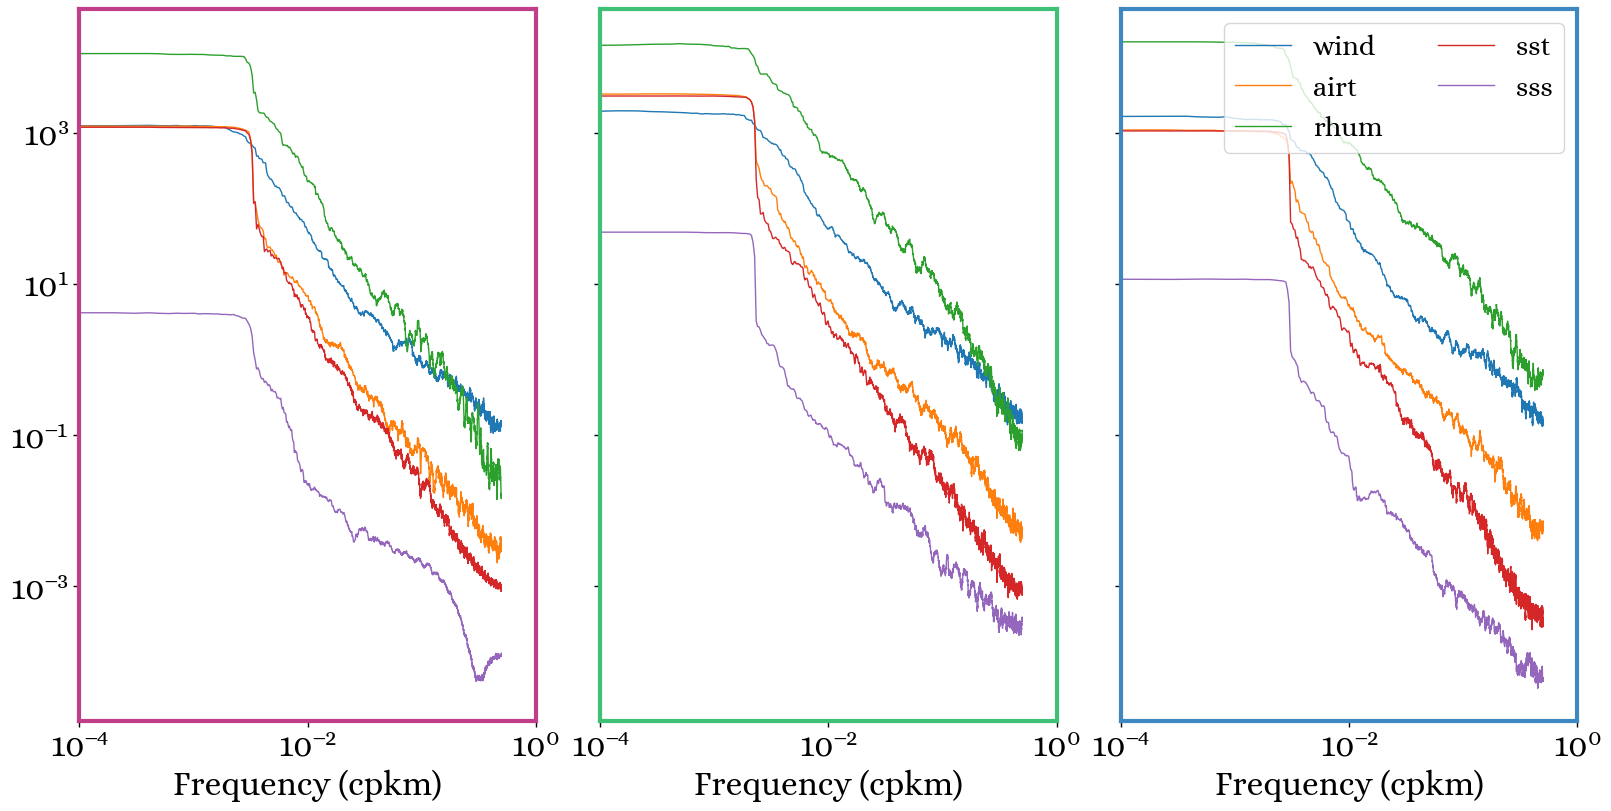

In [328]:
fig,ax = plt.subplots(1,3,figsize=(16,8),constrained_layout=True,sharey=True)

for name,c in zip(names[:-3],colors):
    for ds,axs,color in zip([sp20km,sp22km,sp23km],ax,[c20,c22,c23]):
    
        ds[name].plot(x='frequency', lw=1, yscale='log', xscale='log', label=name, c=c, ax=axs)
        axs.set(xlim=(1e-4,1e0),xlabel="Frequency (cpkm)", ylabel="")
        fix_spines(axs,color)

        
axs.legend(ncol=2, fontsize='small')


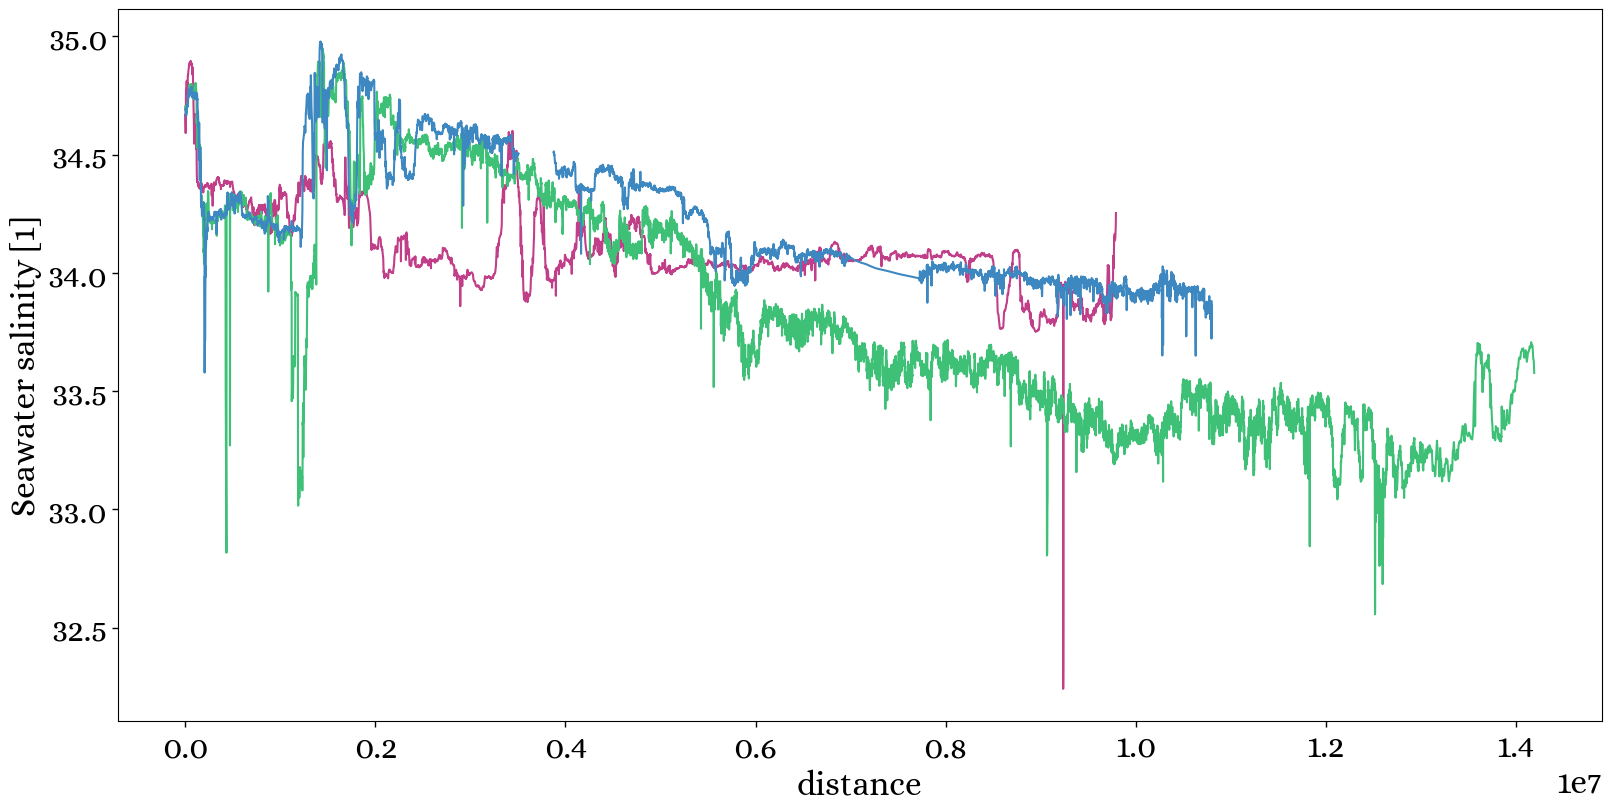

In [235]:
fig,ax = plt.subplots(figsize=(16,8),constrained_layout=True)

for ds,c in zip([ds205,ds225,ds235],[c20,c22,c23]):
    ds['sss'].plot(ax=ax,c=c)

In [317]:
ds20_split = []
ds22_split = []
ds23_split = []
variables = names[:5]  # List of variable names
dsnames = ["1020", "1022", "1023"]  # List of variable names
km = 1000
for i in range(9):
    # Define your datasets and variable names
    datasets = [ds205.isel(distance=np.arange(km*i,km*(i+1),1)),
                ds225.isel(distance=np.arange(km*i,km*(i+1),1)),
                ds235.isel(distance=np.arange(km*i,km*(i+1),1))]  # List of datasets


    # Call the spectral_analysis_mtmethod function
    df = spectral_analysis_mtmethod(datasets, dsnames, variables, dt=1)

    # Create a list of DataArrays using list comprehension
    sp20km = [xr.DataArray(data=row['PSD'],
                         dims=['frequency'],
                         coords={'frequency': row['Frequency']},
                         name=row['Variable'],  # Provide a name for the DataArray
                         attrs={'dataset': 'ds20', 'variable': row['Variable']})
            for _, row in df.iloc[:5].iterrows()]

    # Merge the list of DataArrays into a single Dataset
    sp20km = xr.merge(sp20km,compat='override')

    # Create a list of DataArrays using list comprehension
    sp22km = [xr.DataArray(data=row['PSD'],
                         dims=['frequency'],
                         coords={'frequency': row['Frequency']},
                         name=row['Variable'],  # Provide a name for the DataArray
                         attrs={'dataset': 'ds22', 'variable': row['Variable']})
            for _, row in df.iloc[5:10].iterrows()]

    # Merge the list of DataArrays into a single Dataset
    sp22km = xr.merge(sp22km,compat='override')

    # Create a list of DataArrays using list comprehension
    sp23km = [xr.DataArray(data=row['PSD'],
                         dims=['frequency'],
                         coords={'frequency': row['Frequency']},
                         name=row['Variable'],  # Provide a name for the DataArray
                         attrs={'dataset': 'ds23', 'variable': row['Variable']})
            for _, row in df.iloc[10:].iterrows()]

    # Merge the list of DataArrays into a single Dataset
    sp23km = xr.merge(sp23km,compat='override')

    ds20_split.append(sp20km)
    ds22_split.append(sp22km)
    ds23_split.append(sp23km)

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing datasets: 0it [00:00, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/5 [00:00<?, ?it/s]

In [286]:
from matplotlib.ticker import LogLocator

In [296]:
cmcolors = [plt.get_cmap("cmo.haline")(i / (9)) for i in range(9)]


In [347]:
[plt.get_cmap("Blues")(i / (12)) for i in range(12)][:2:-1]

[(0.03137254901960784, 0.2734948096885813, 0.5462053056516725, 1.0),
 (0.06251441753171857, 0.35750865051903113, 0.6429065743944637, 1.0),
 (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719, 1.0),
 (0.31115724721261057, 0.6082891195693964, 0.7968935024990389, 1.0),
 (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0),
 (0.5545098039215688, 0.7564167627835449, 0.8683121876201461, 1.0),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418, 1.0),
 (0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0)]

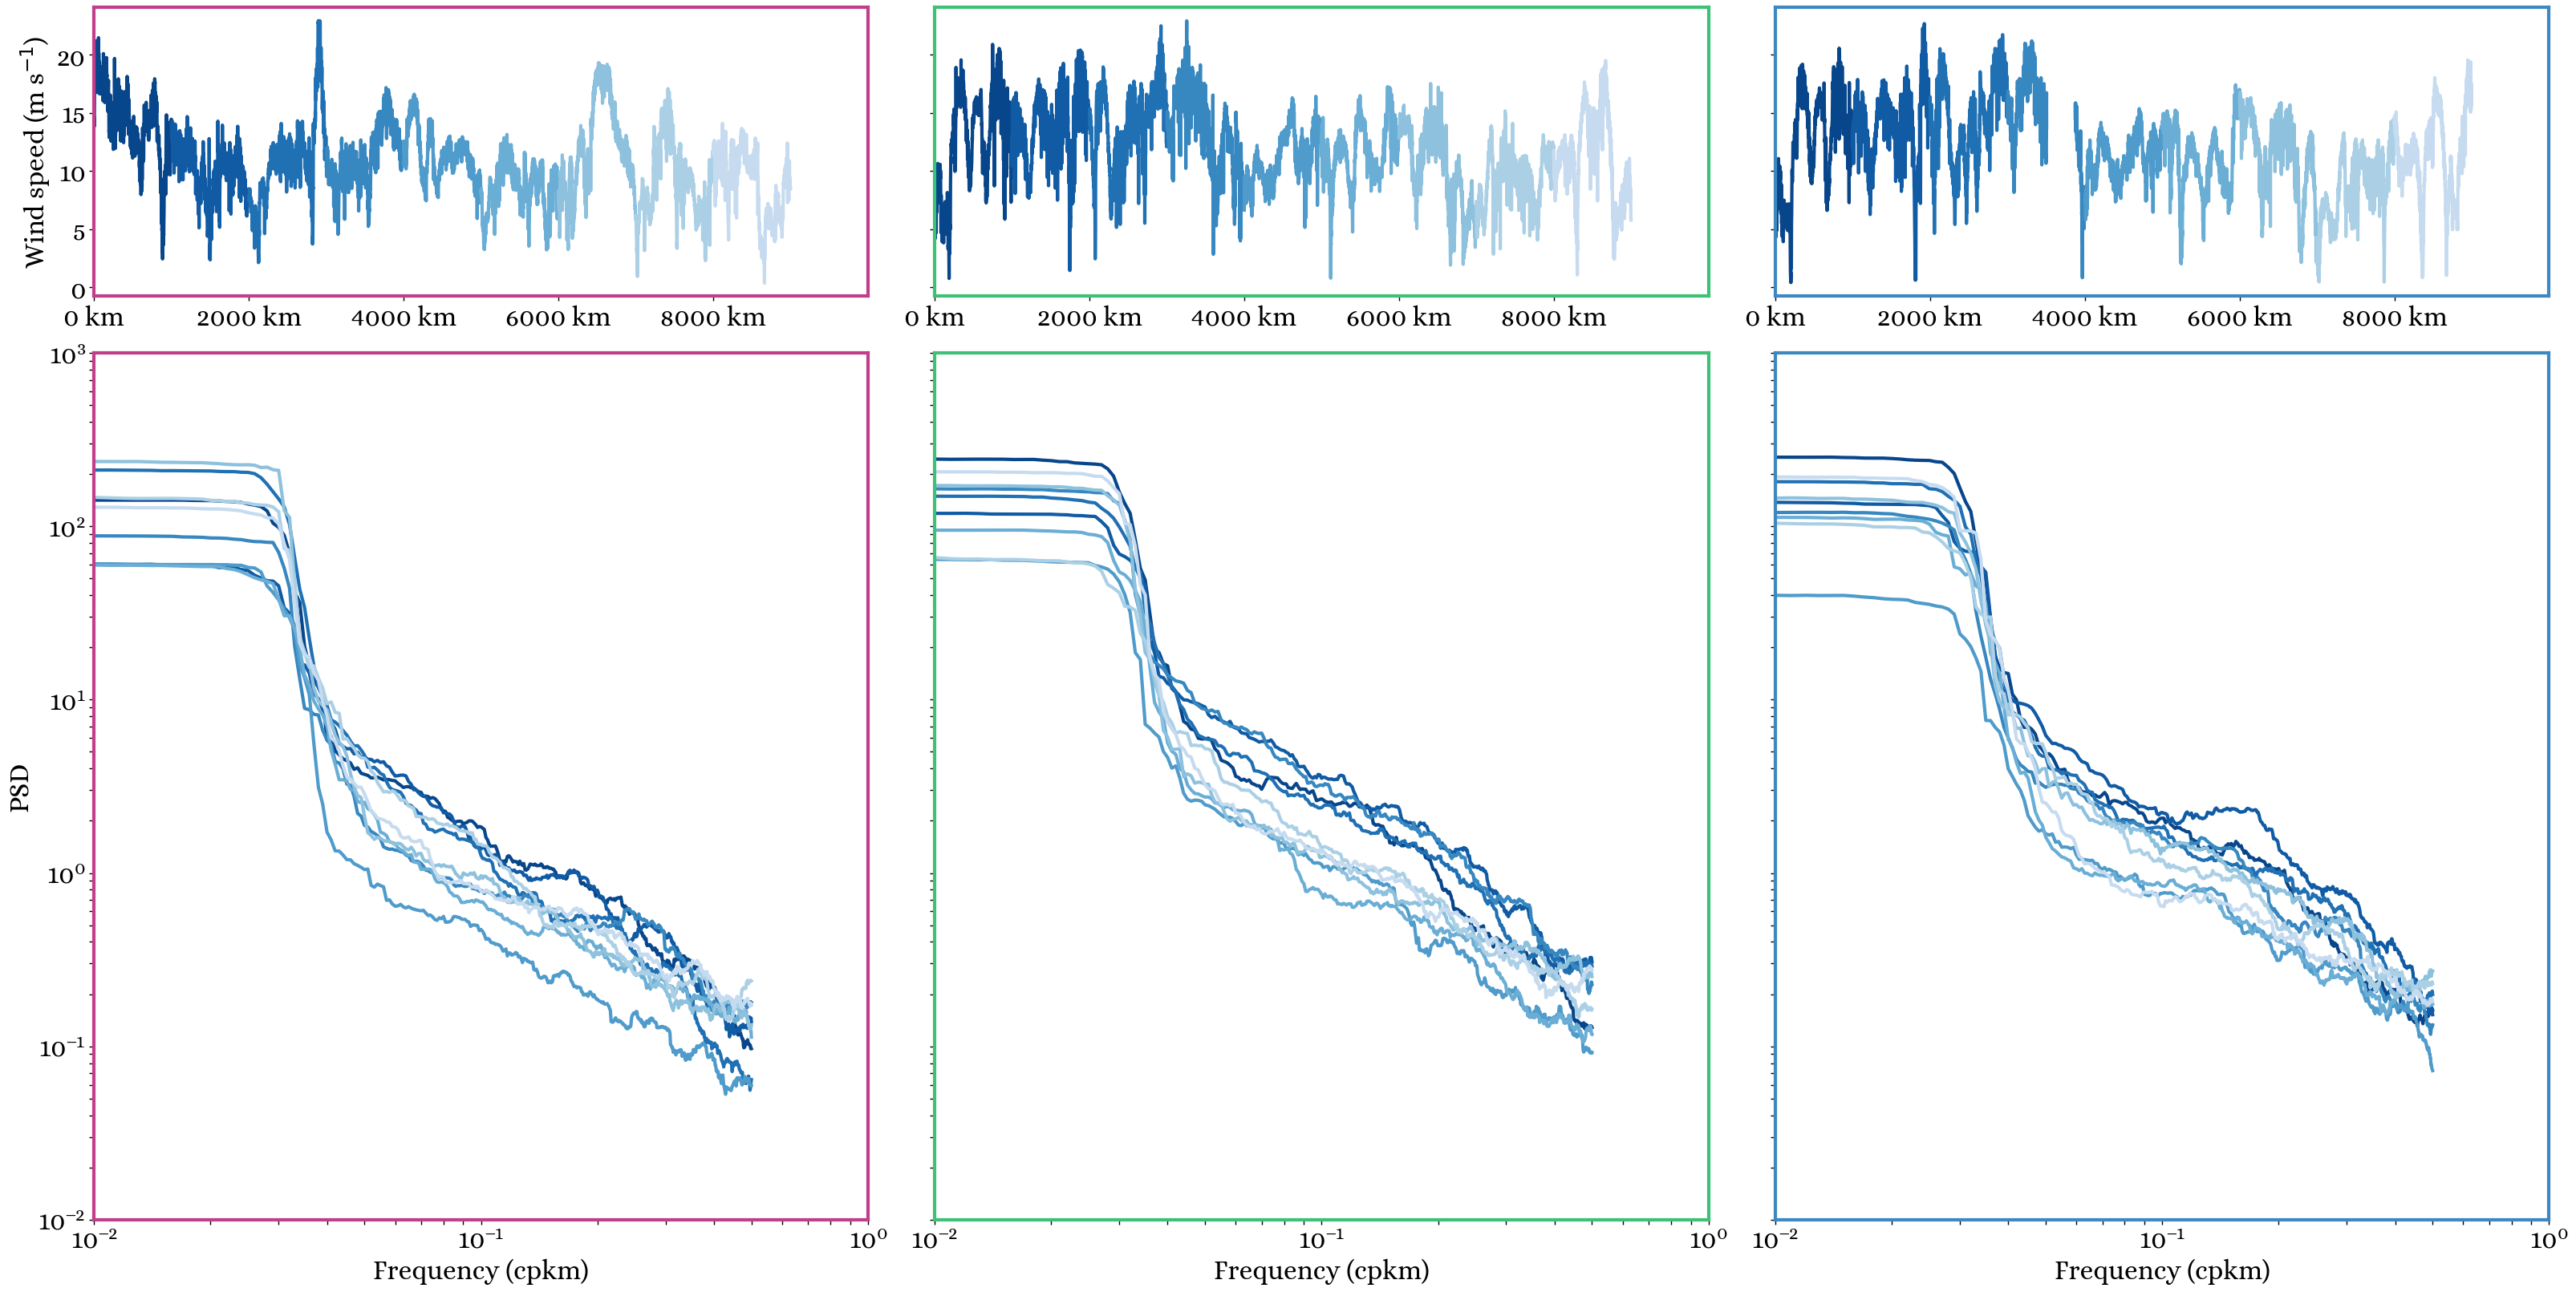

In [349]:
fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])

cmcolors = [plt.get_cmap("Blues")(i / (12)) for i in range(12)][:2:-1]

for i,c in zip(range(9),cmcolors):
    #fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])
    for j,(ds1,ds2,axs1,axs2,color) in enumerate(zip([ds205,ds225,ds235],
                                       [ds20_split,ds22_split,ds23_split],
                                       ax[0],ax[1],[c20,c22,c23])):
        
        ds1["wind"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c=c, ax=axs1)
        ds2[i]["wind"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c=c, ax=axs2)
        axs1.set(xlim=(0,1e7-1),xlabel="",ylabel="Wind speed (m s$^{-1}$)" if j==0 else "")
        axs2.set(xlim=(1e-2,1e0),xlabel="Frequency (cpkm)", ylim=(1e-2,1e3), ylabel="PSD" if j == 0 else "")
        axs1.xaxis.set_major_formatter(FuncFormatter(km_formatter))
        fix_spines(axs1,color)
        fix_spines(axs2,color)

        if j == 1:
            axs2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)))

    #plt.savefig(f"/Users/xedhjo/Documents/Projects/saildrone_fronts_paper/figures/spectra_test/step_{str(i).zfill(2)}")
#axs.legend(ncol=2, fontsize='small')


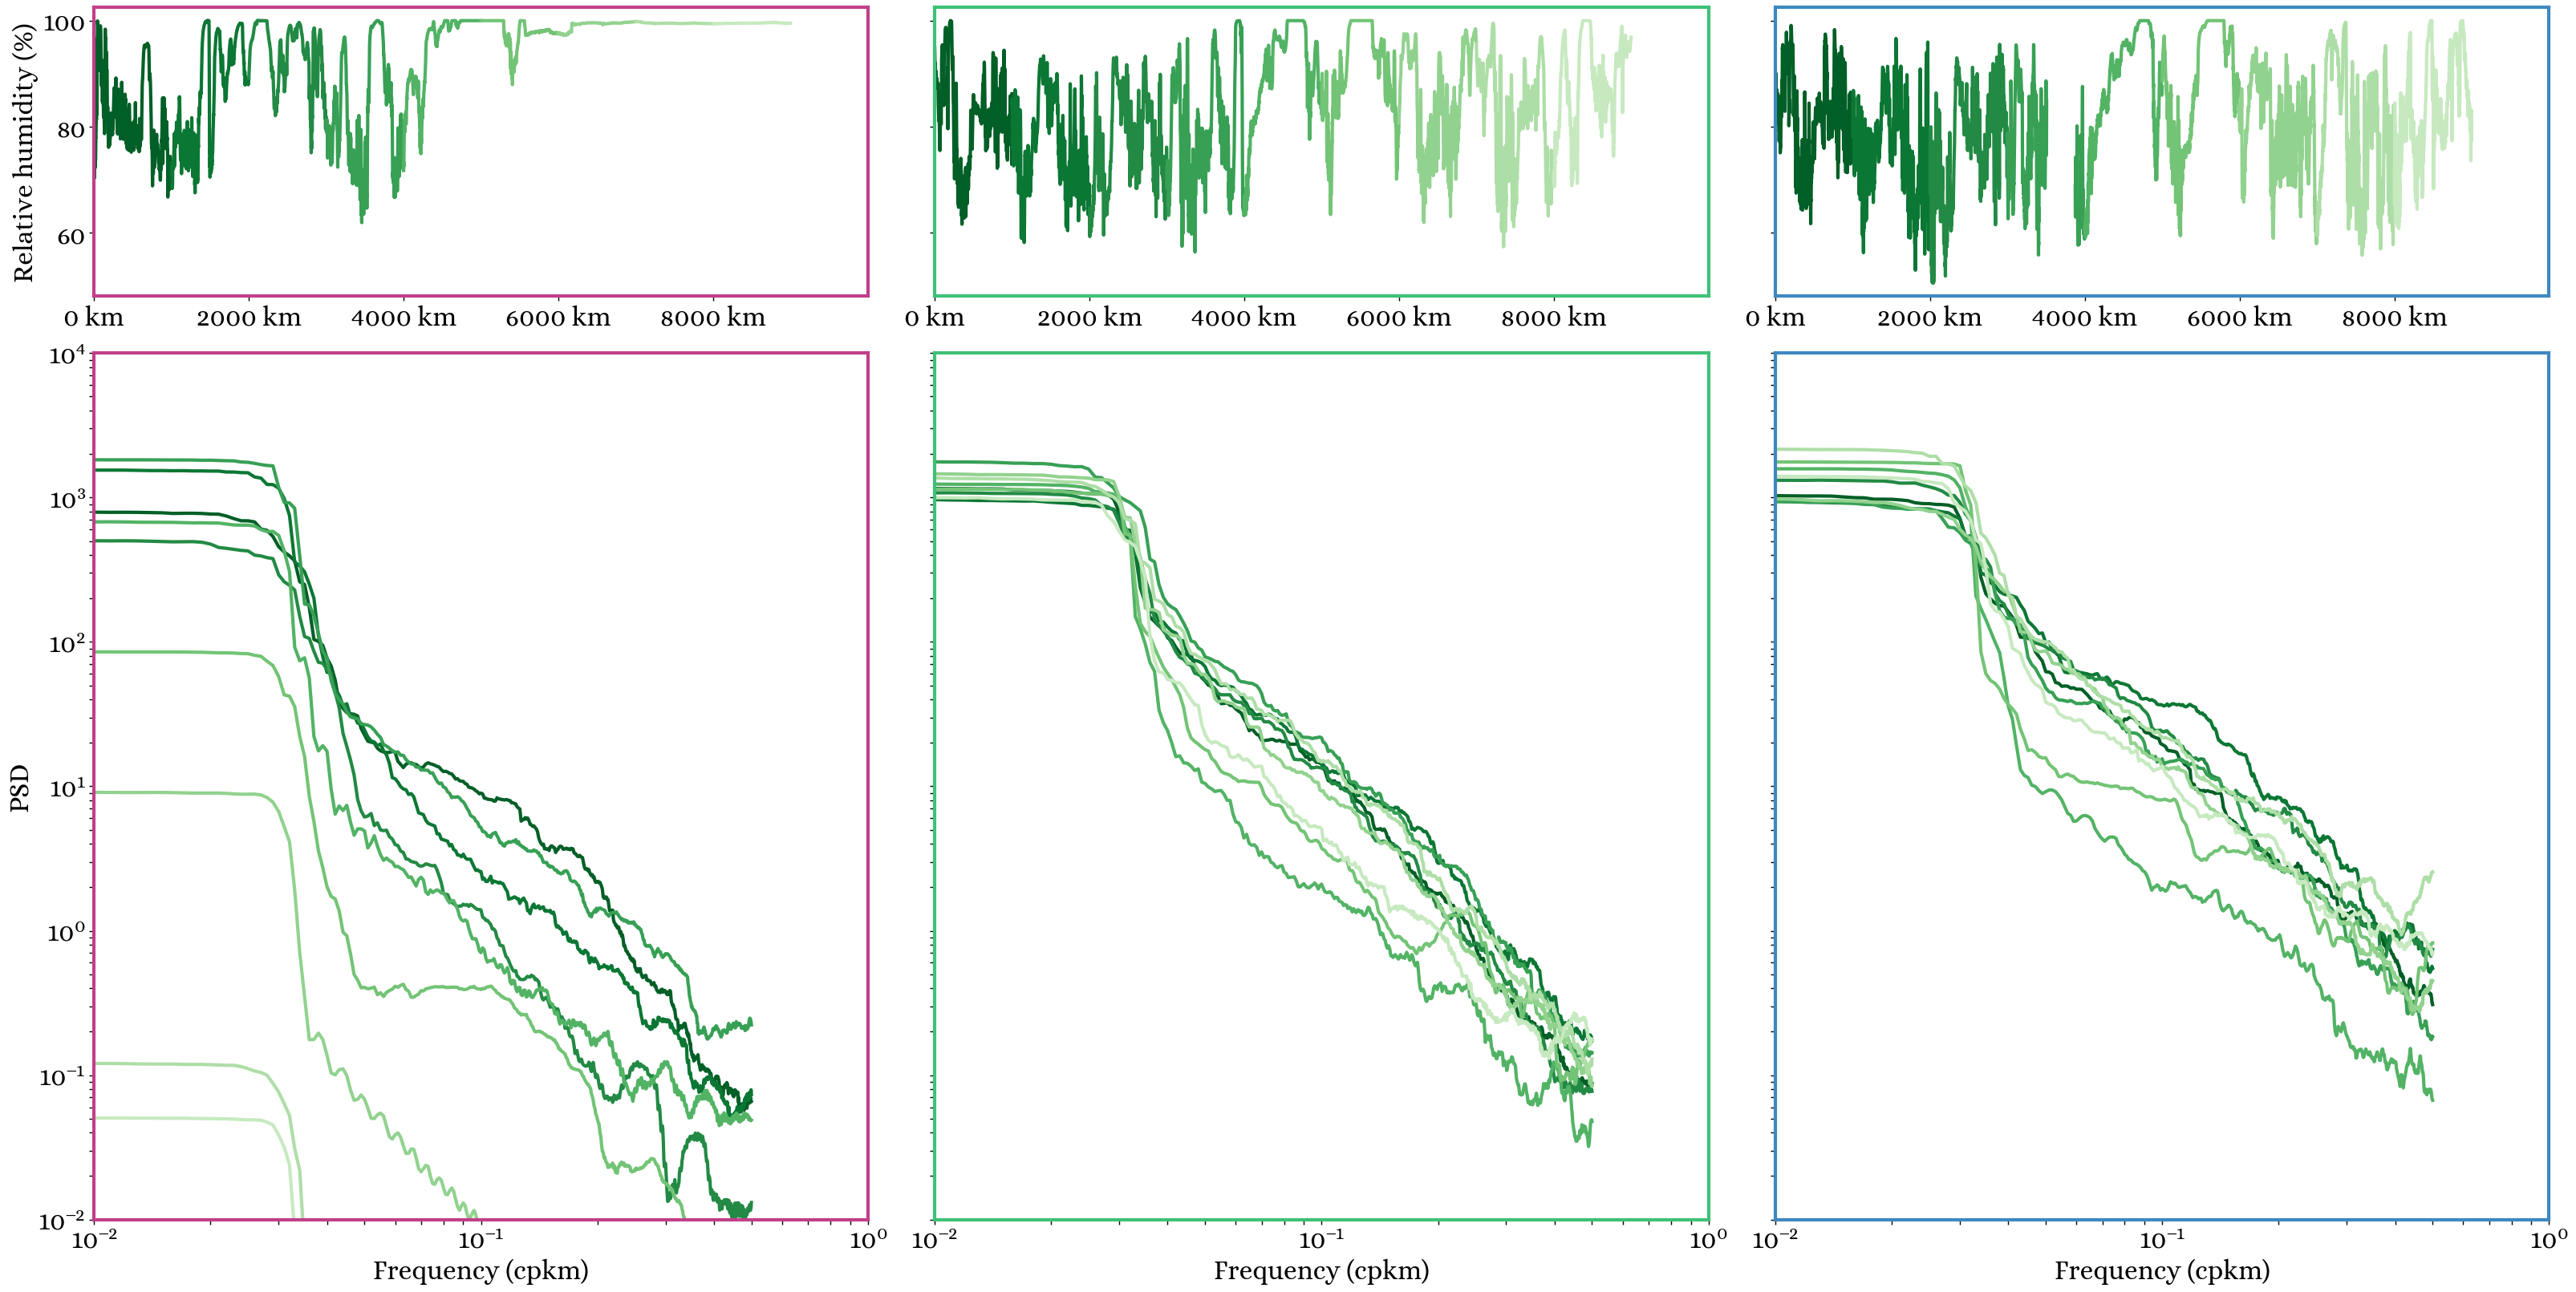

In [350]:
fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])

cmcolors1 = [plt.get_cmap("Greens")(i / (12)) for i in range(12)][:2:-1]

for i,c1,c2 in zip(range(9),cmcolors1,cmcolors2):
    #fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])
    for j,(ds1,ds2,axs1,axs2,color) in enumerate(zip([ds205,ds225,ds235],
                                       [ds20_split,ds22_split,ds23_split],
                                       ax[0],ax[1],[c20,c22,c23])):
        
        ds1["rhum"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c=c1, ax=axs1)
        ds2[i]["rhum"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c=c1, ax=axs2)
        axs1.set(xlim=(0,1e7-1),xlabel="",ylabel="Relative humidity (%)" if j==0 else "")
        axs2.set(xlim=(1e-2,1e0),xlabel="Frequency (cpkm)", ylim=(1e-2,1e4), ylabel="PSD" if j == 0 else "")
        axs1.xaxis.set_major_formatter(FuncFormatter(km_formatter))
        fix_spines(axs1,color)
        fix_spines(axs2,color)

        if j == 1:
            axs2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)))

    #plt.savefig(f"/Users/xedhjo/Documents/Projects/saildrone_fronts_paper/figures/spectra_test/step_{str(i).zfill(2)}")
#axs.legend(ncol=2, fontsize='small')


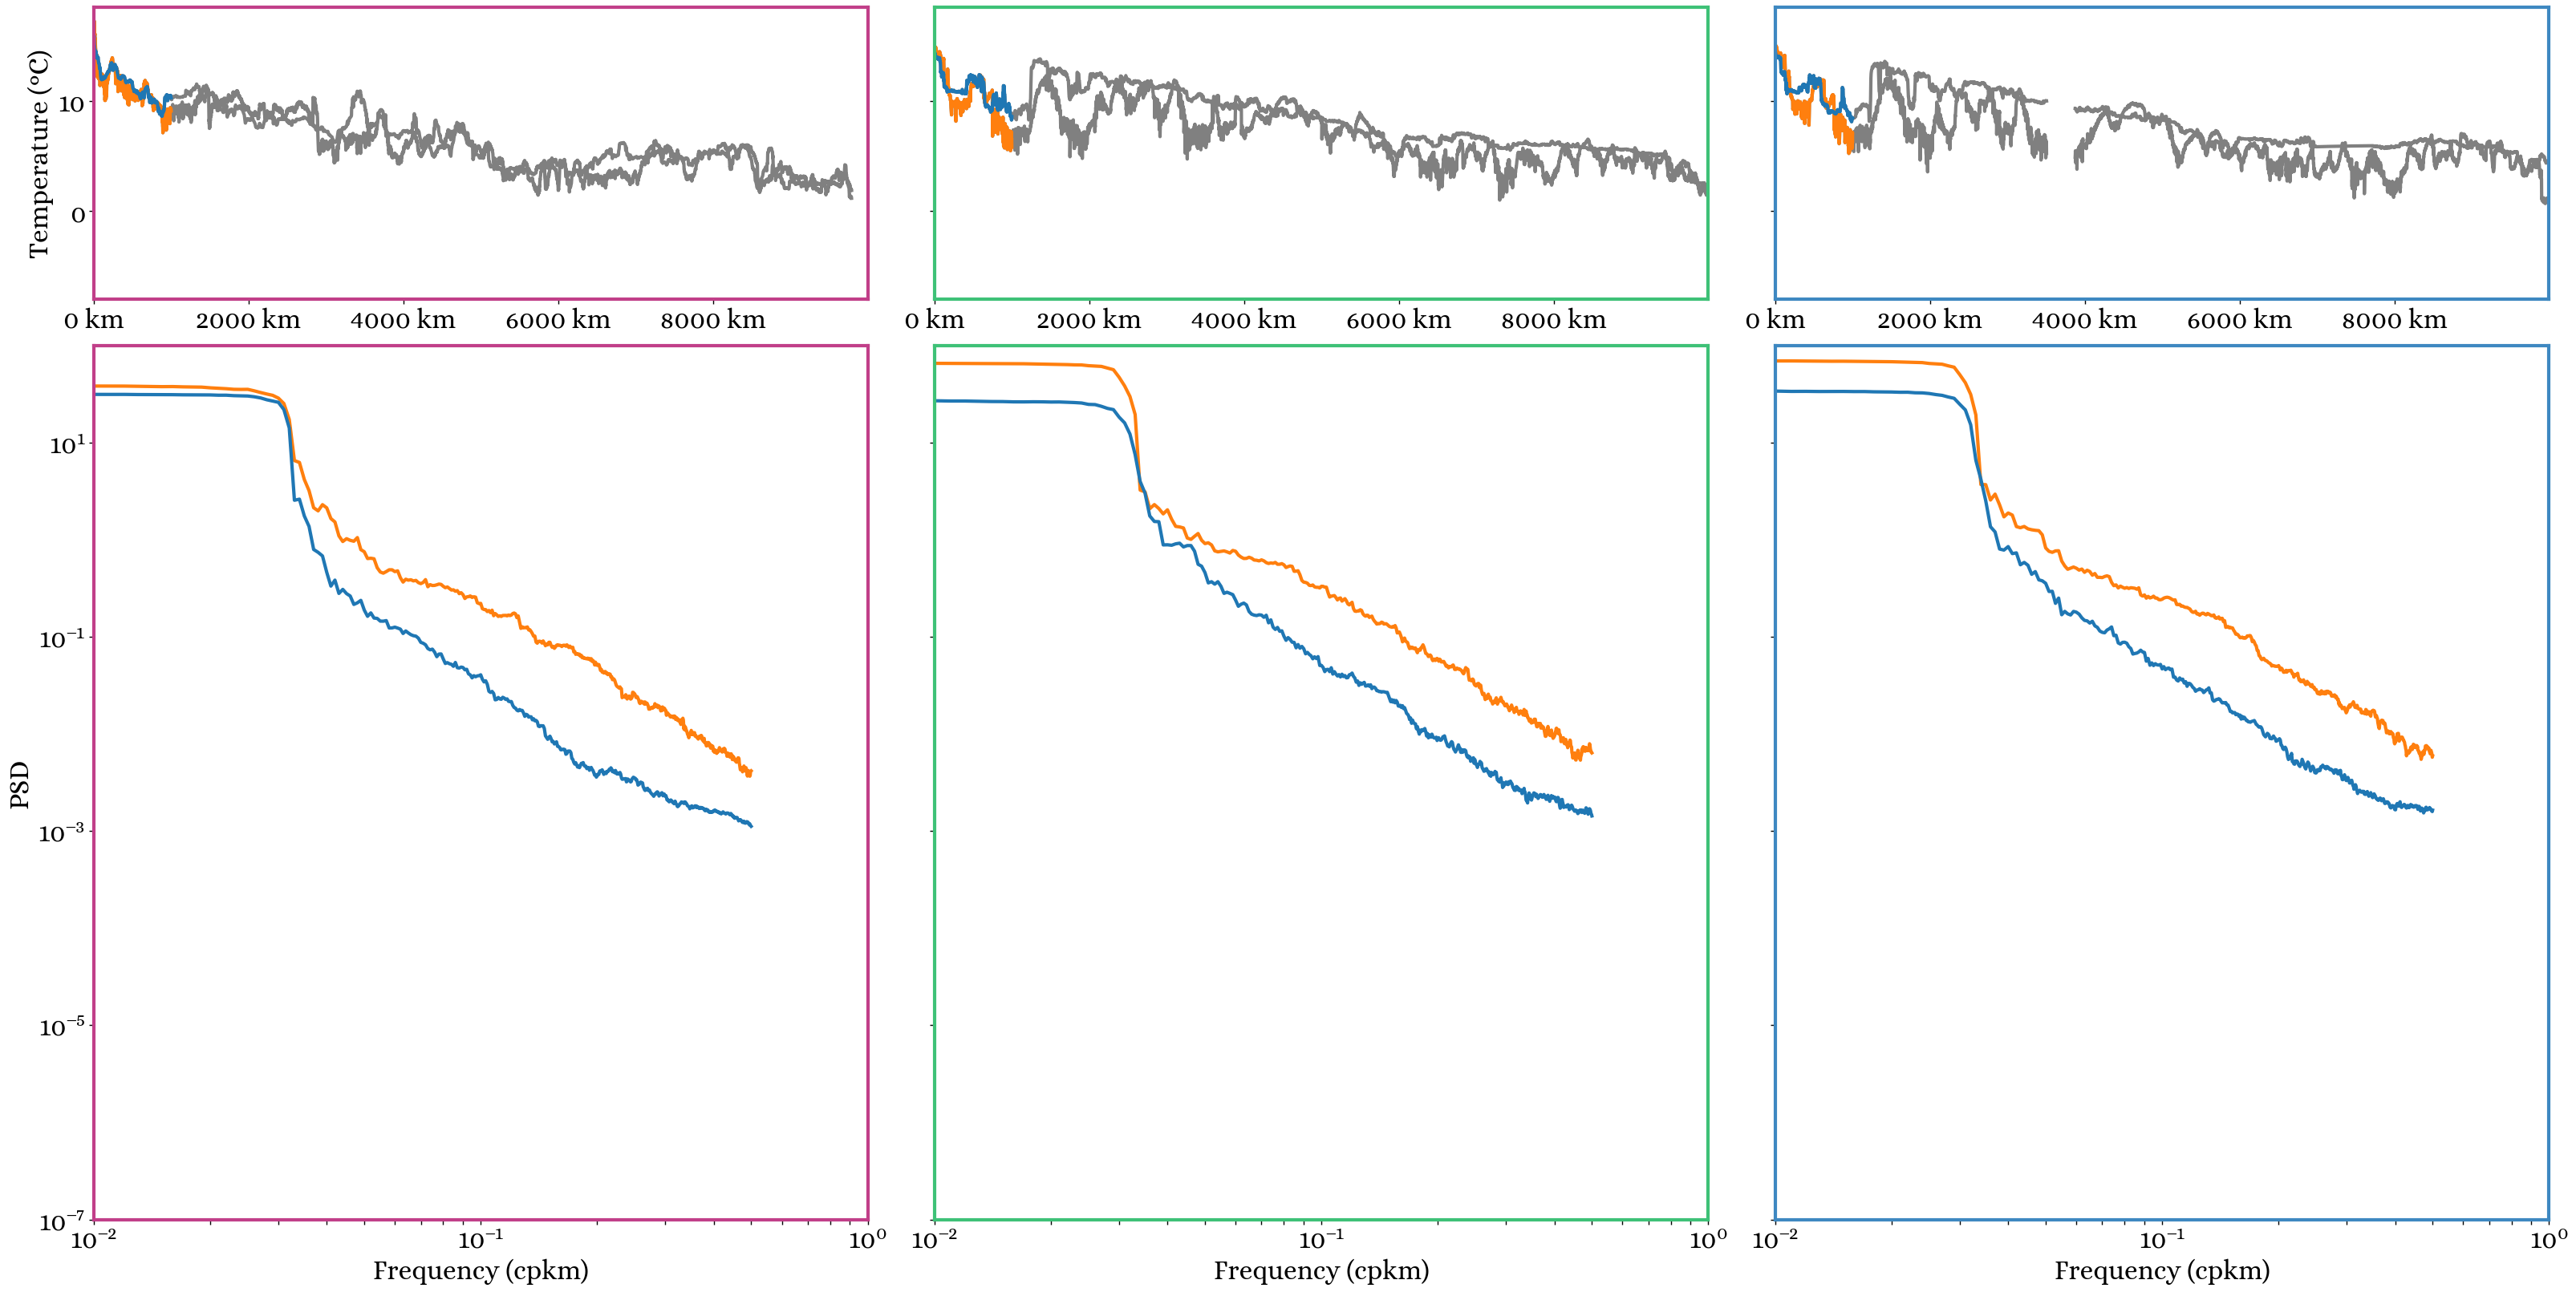

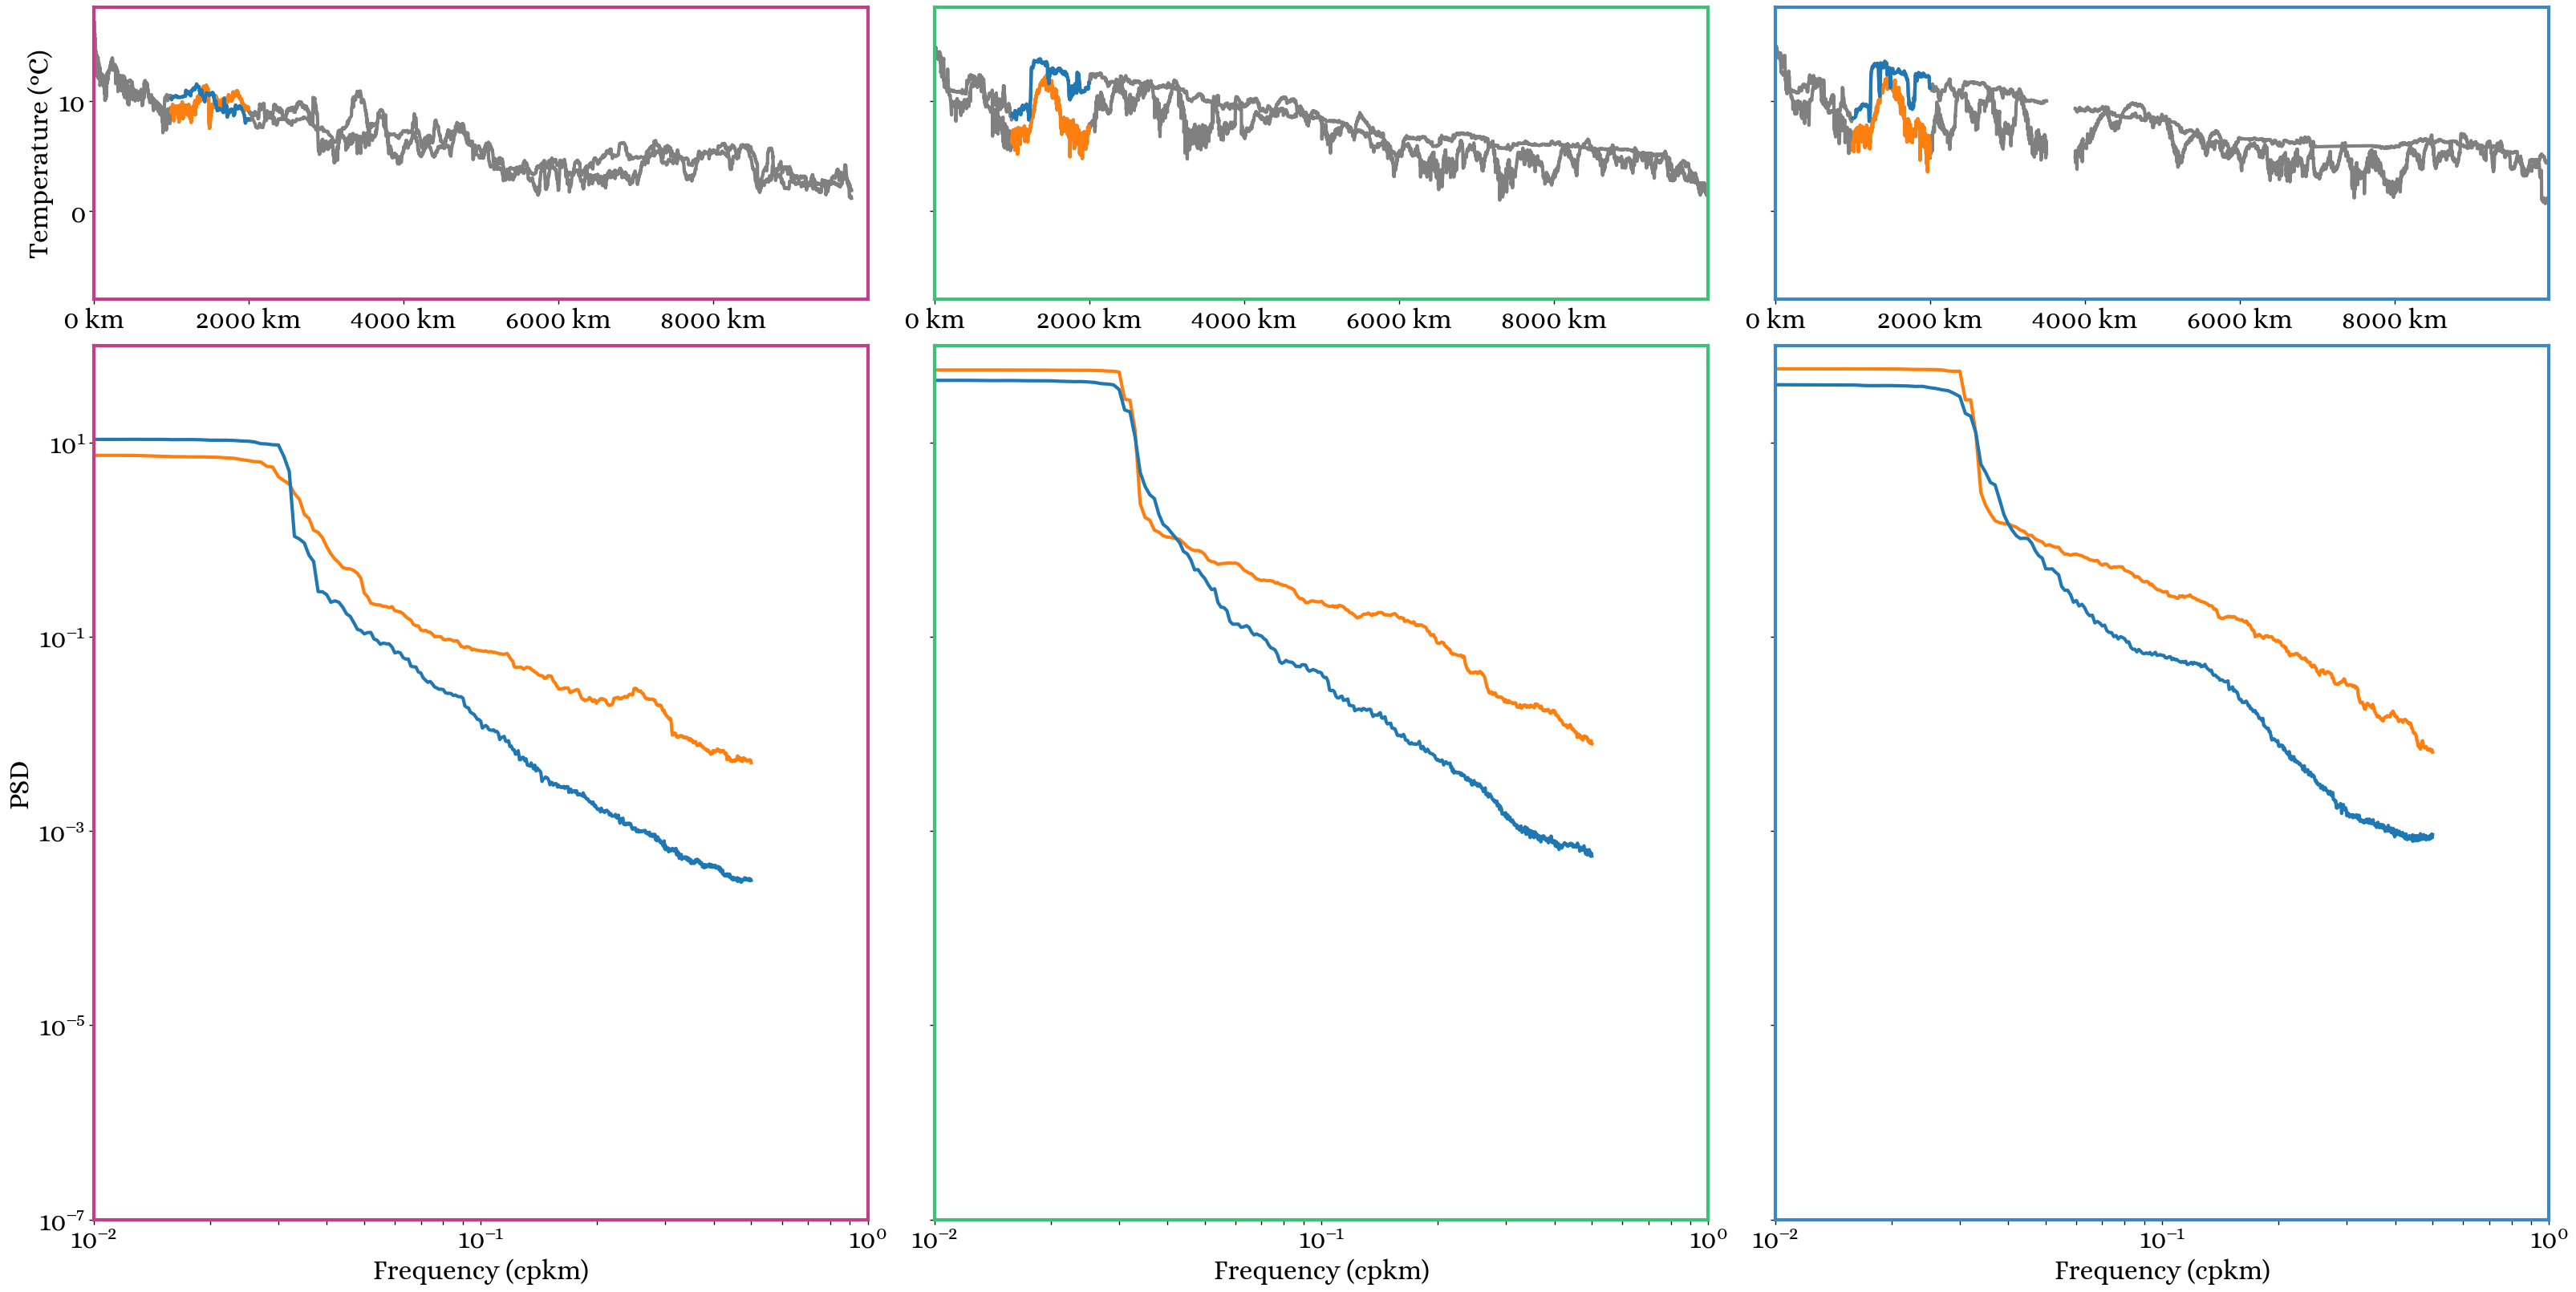

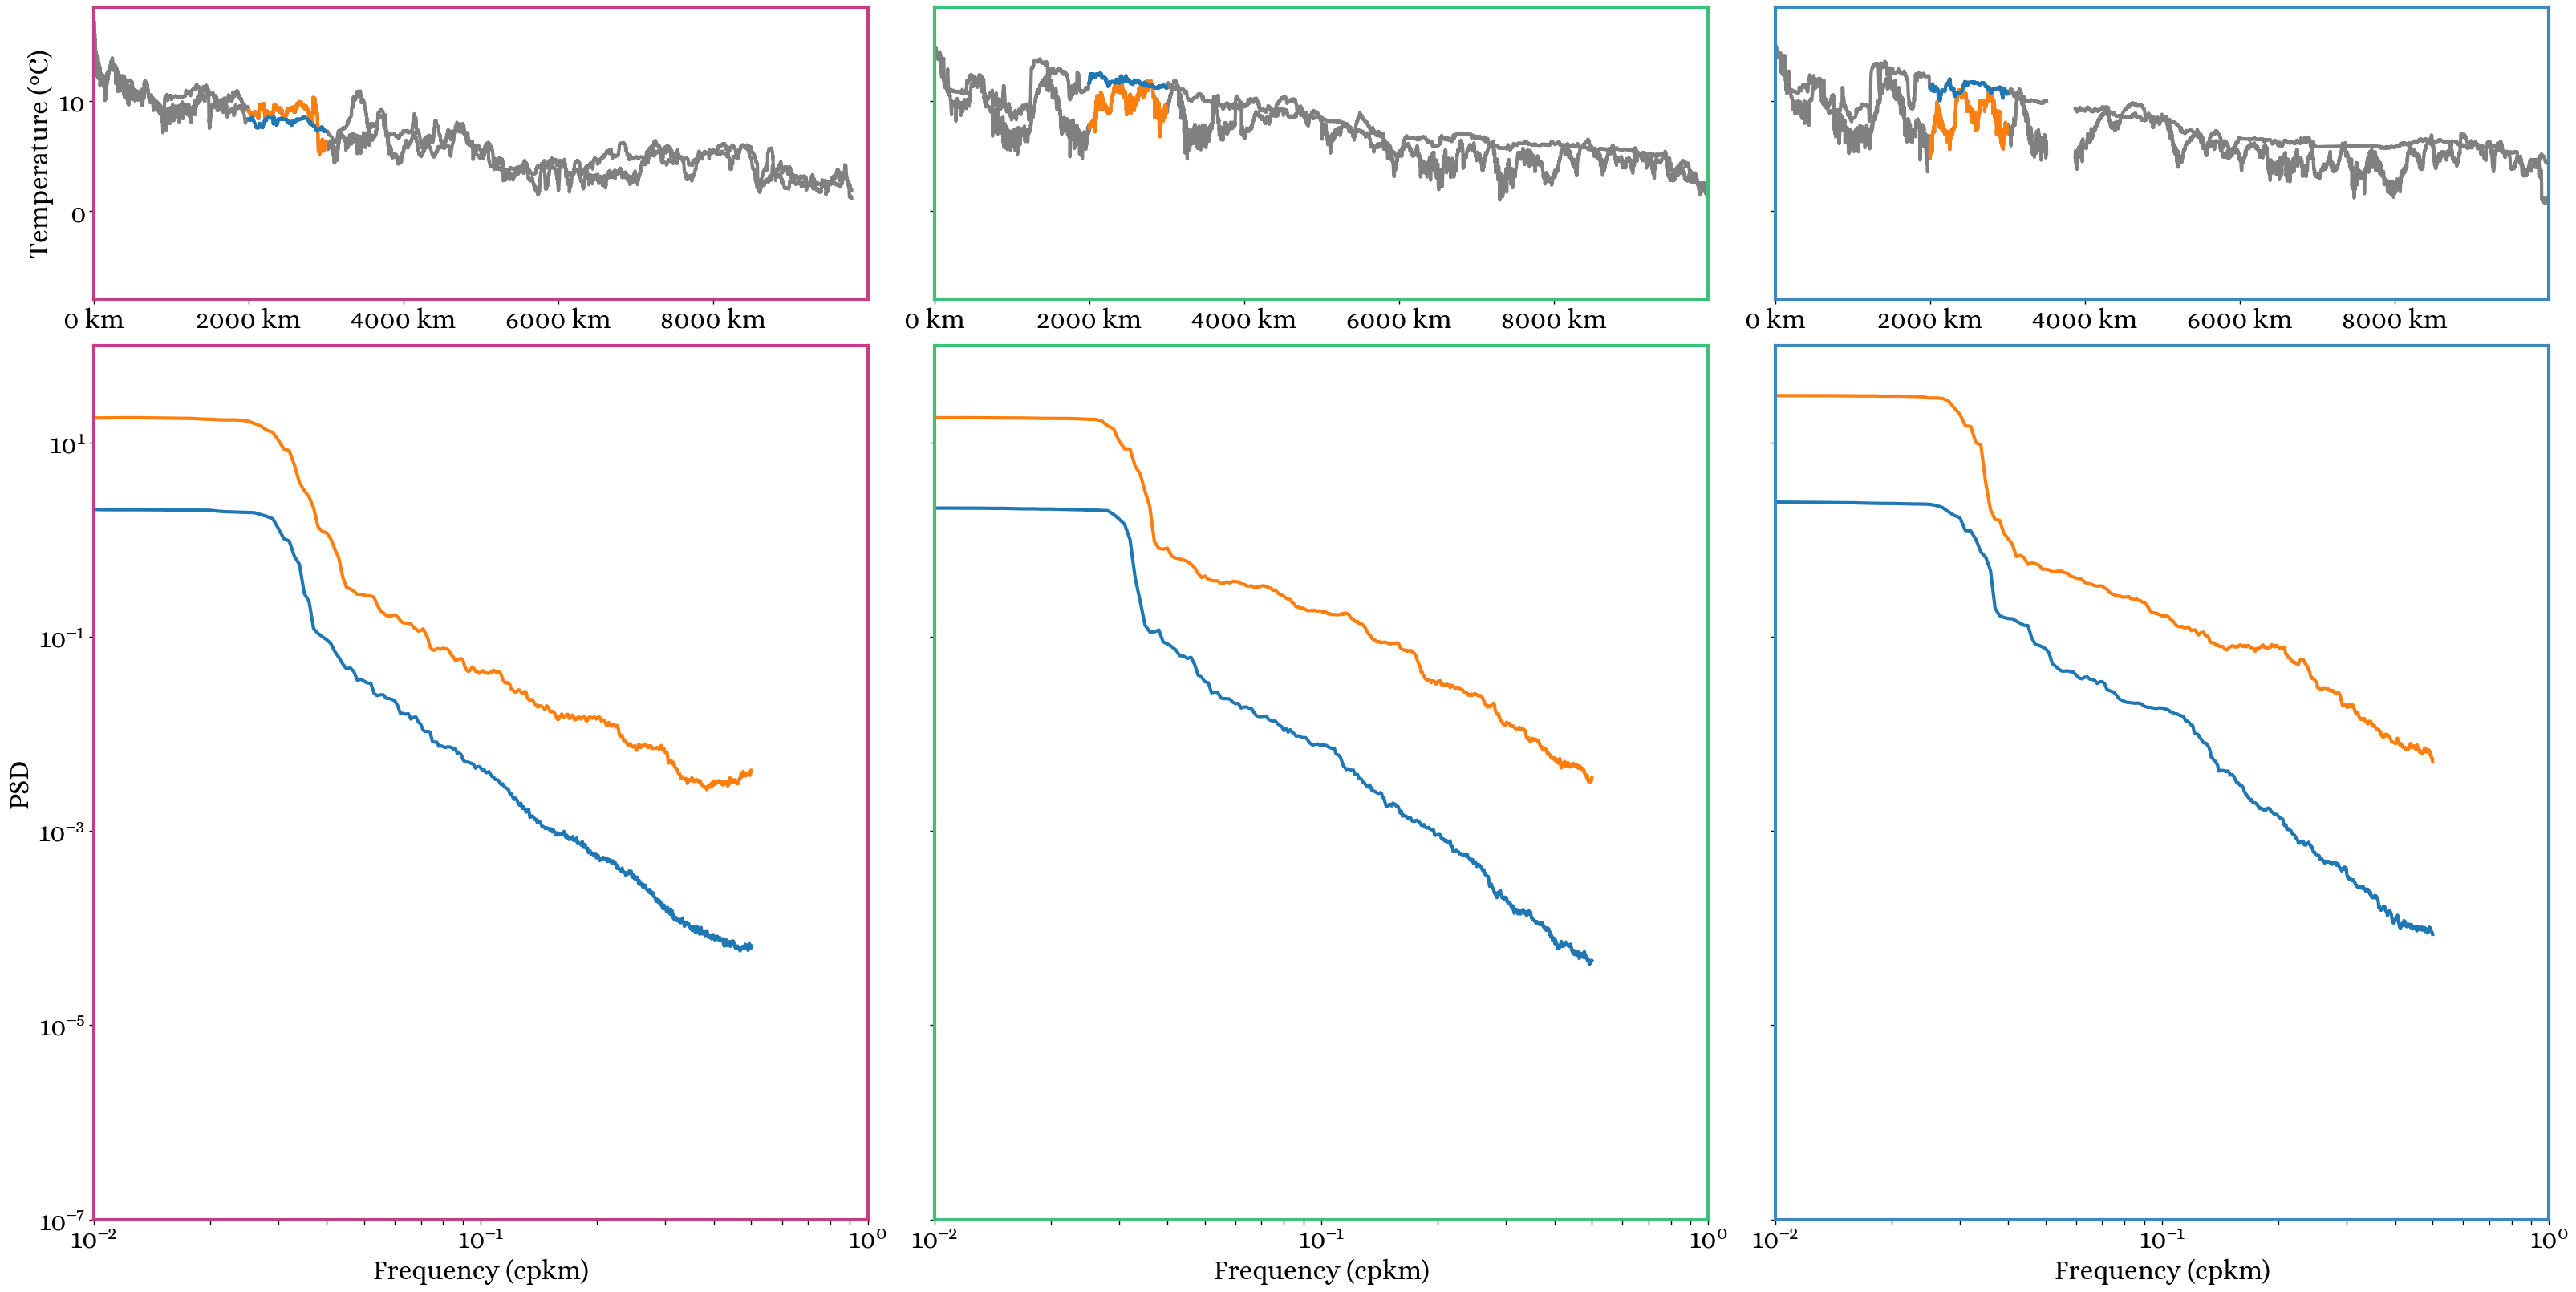

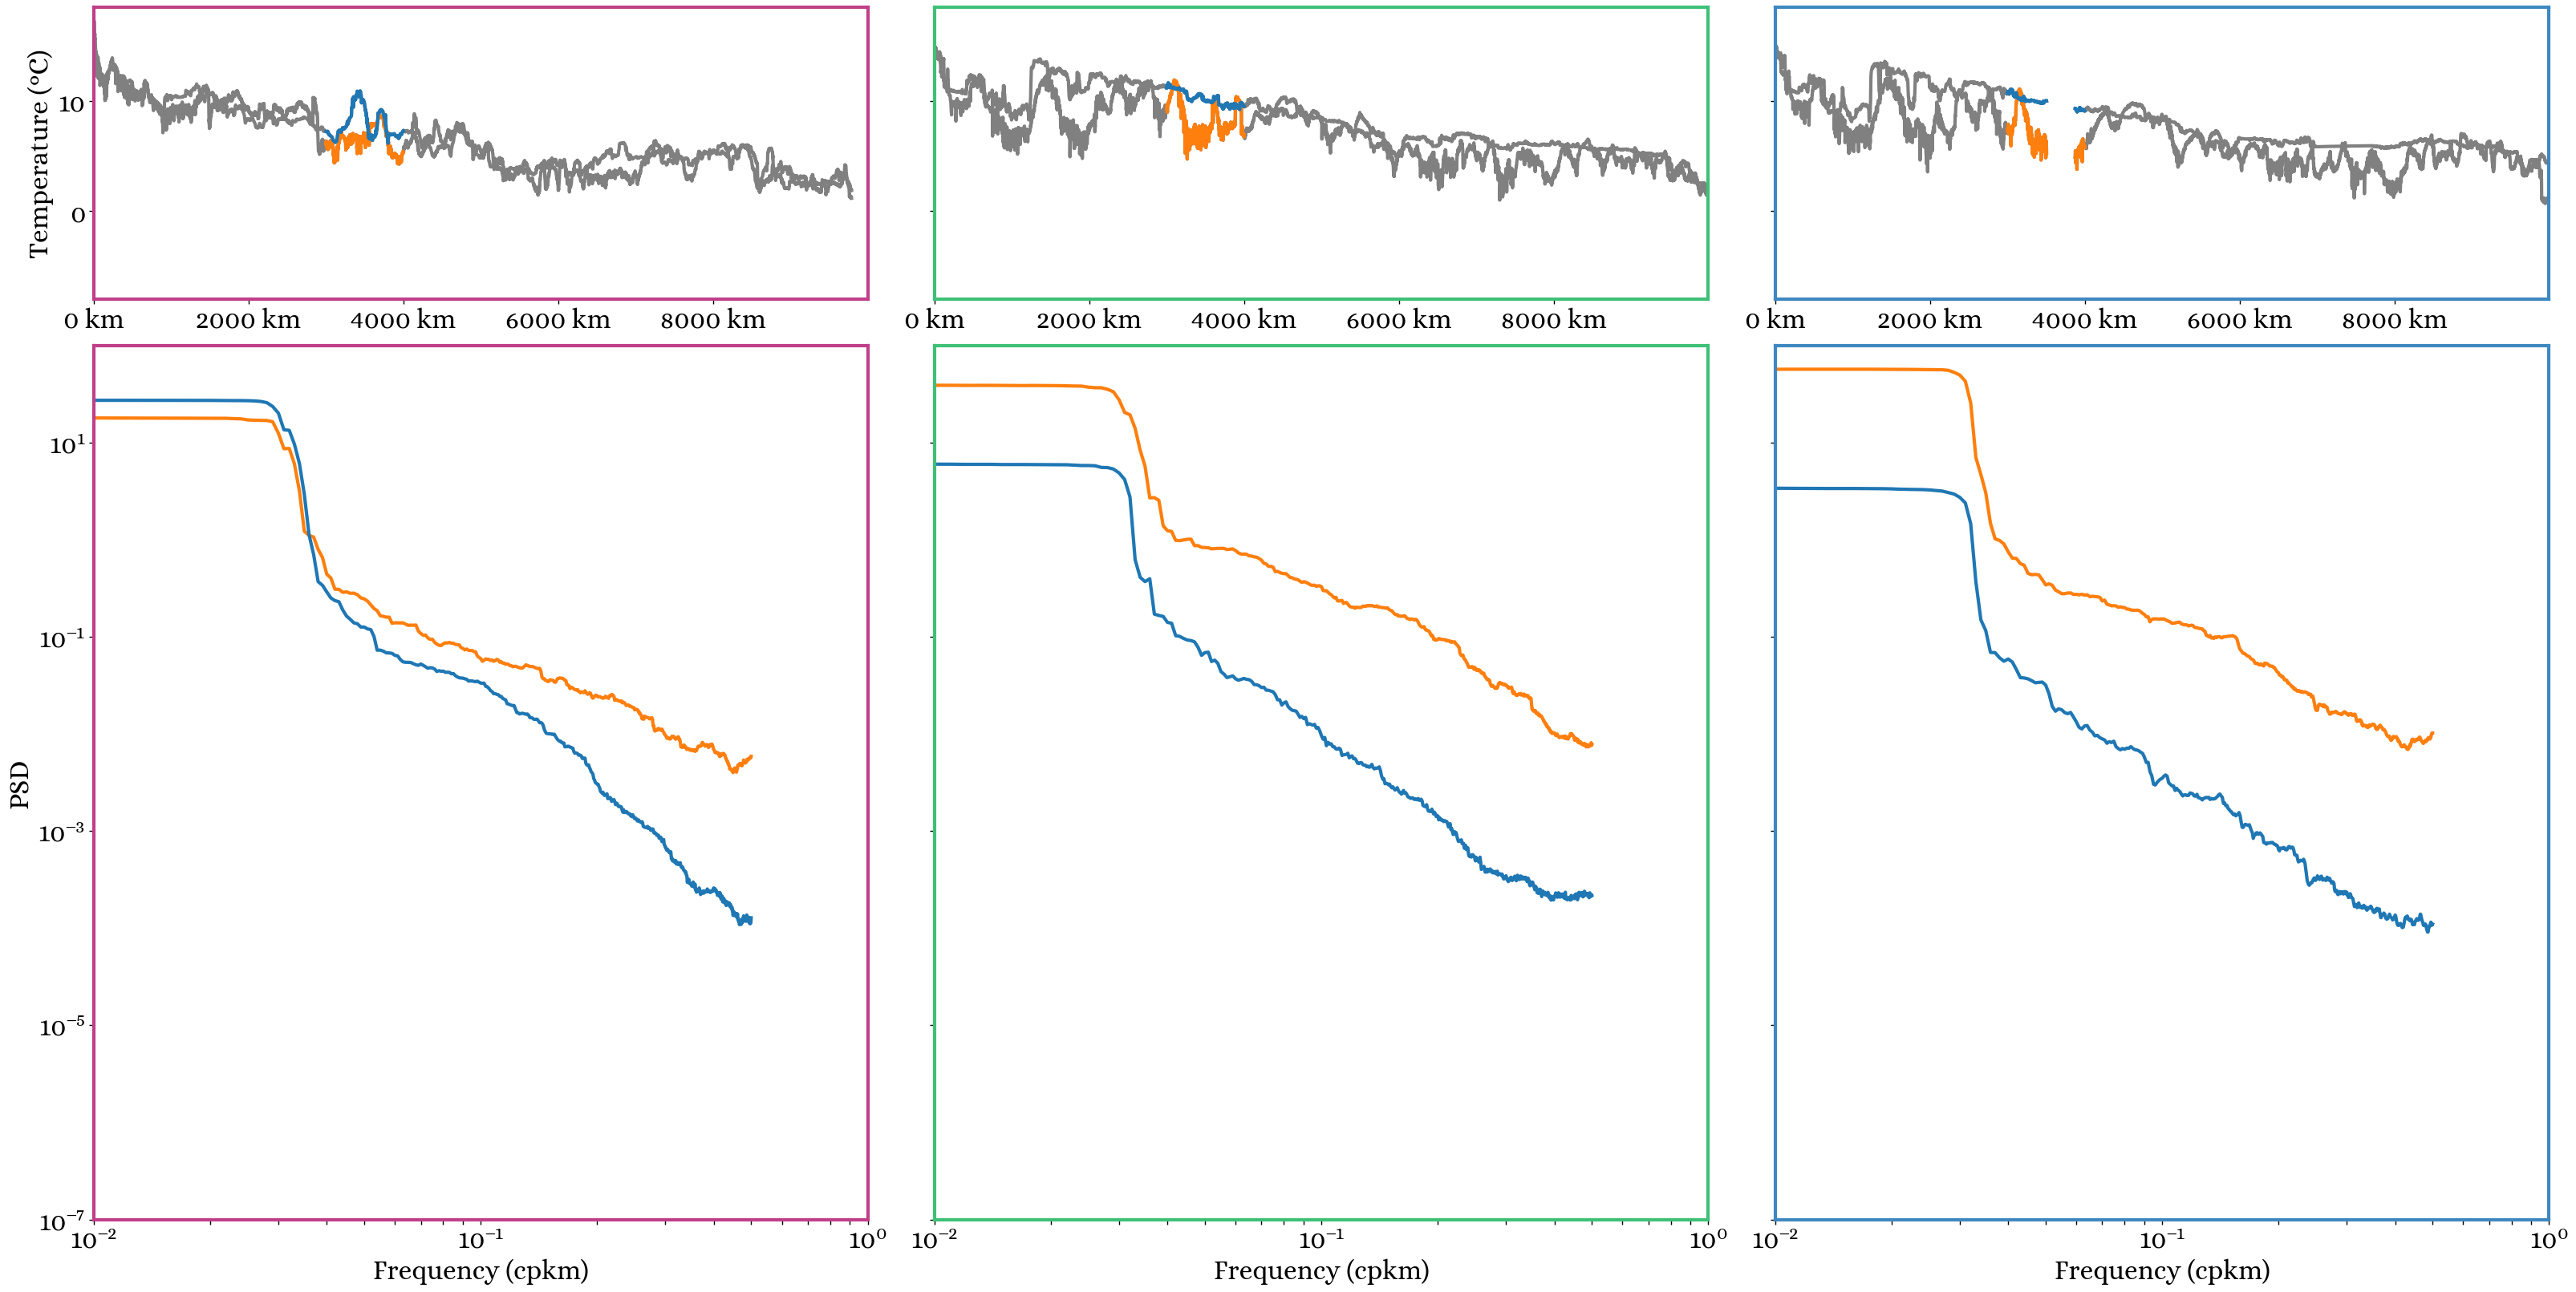

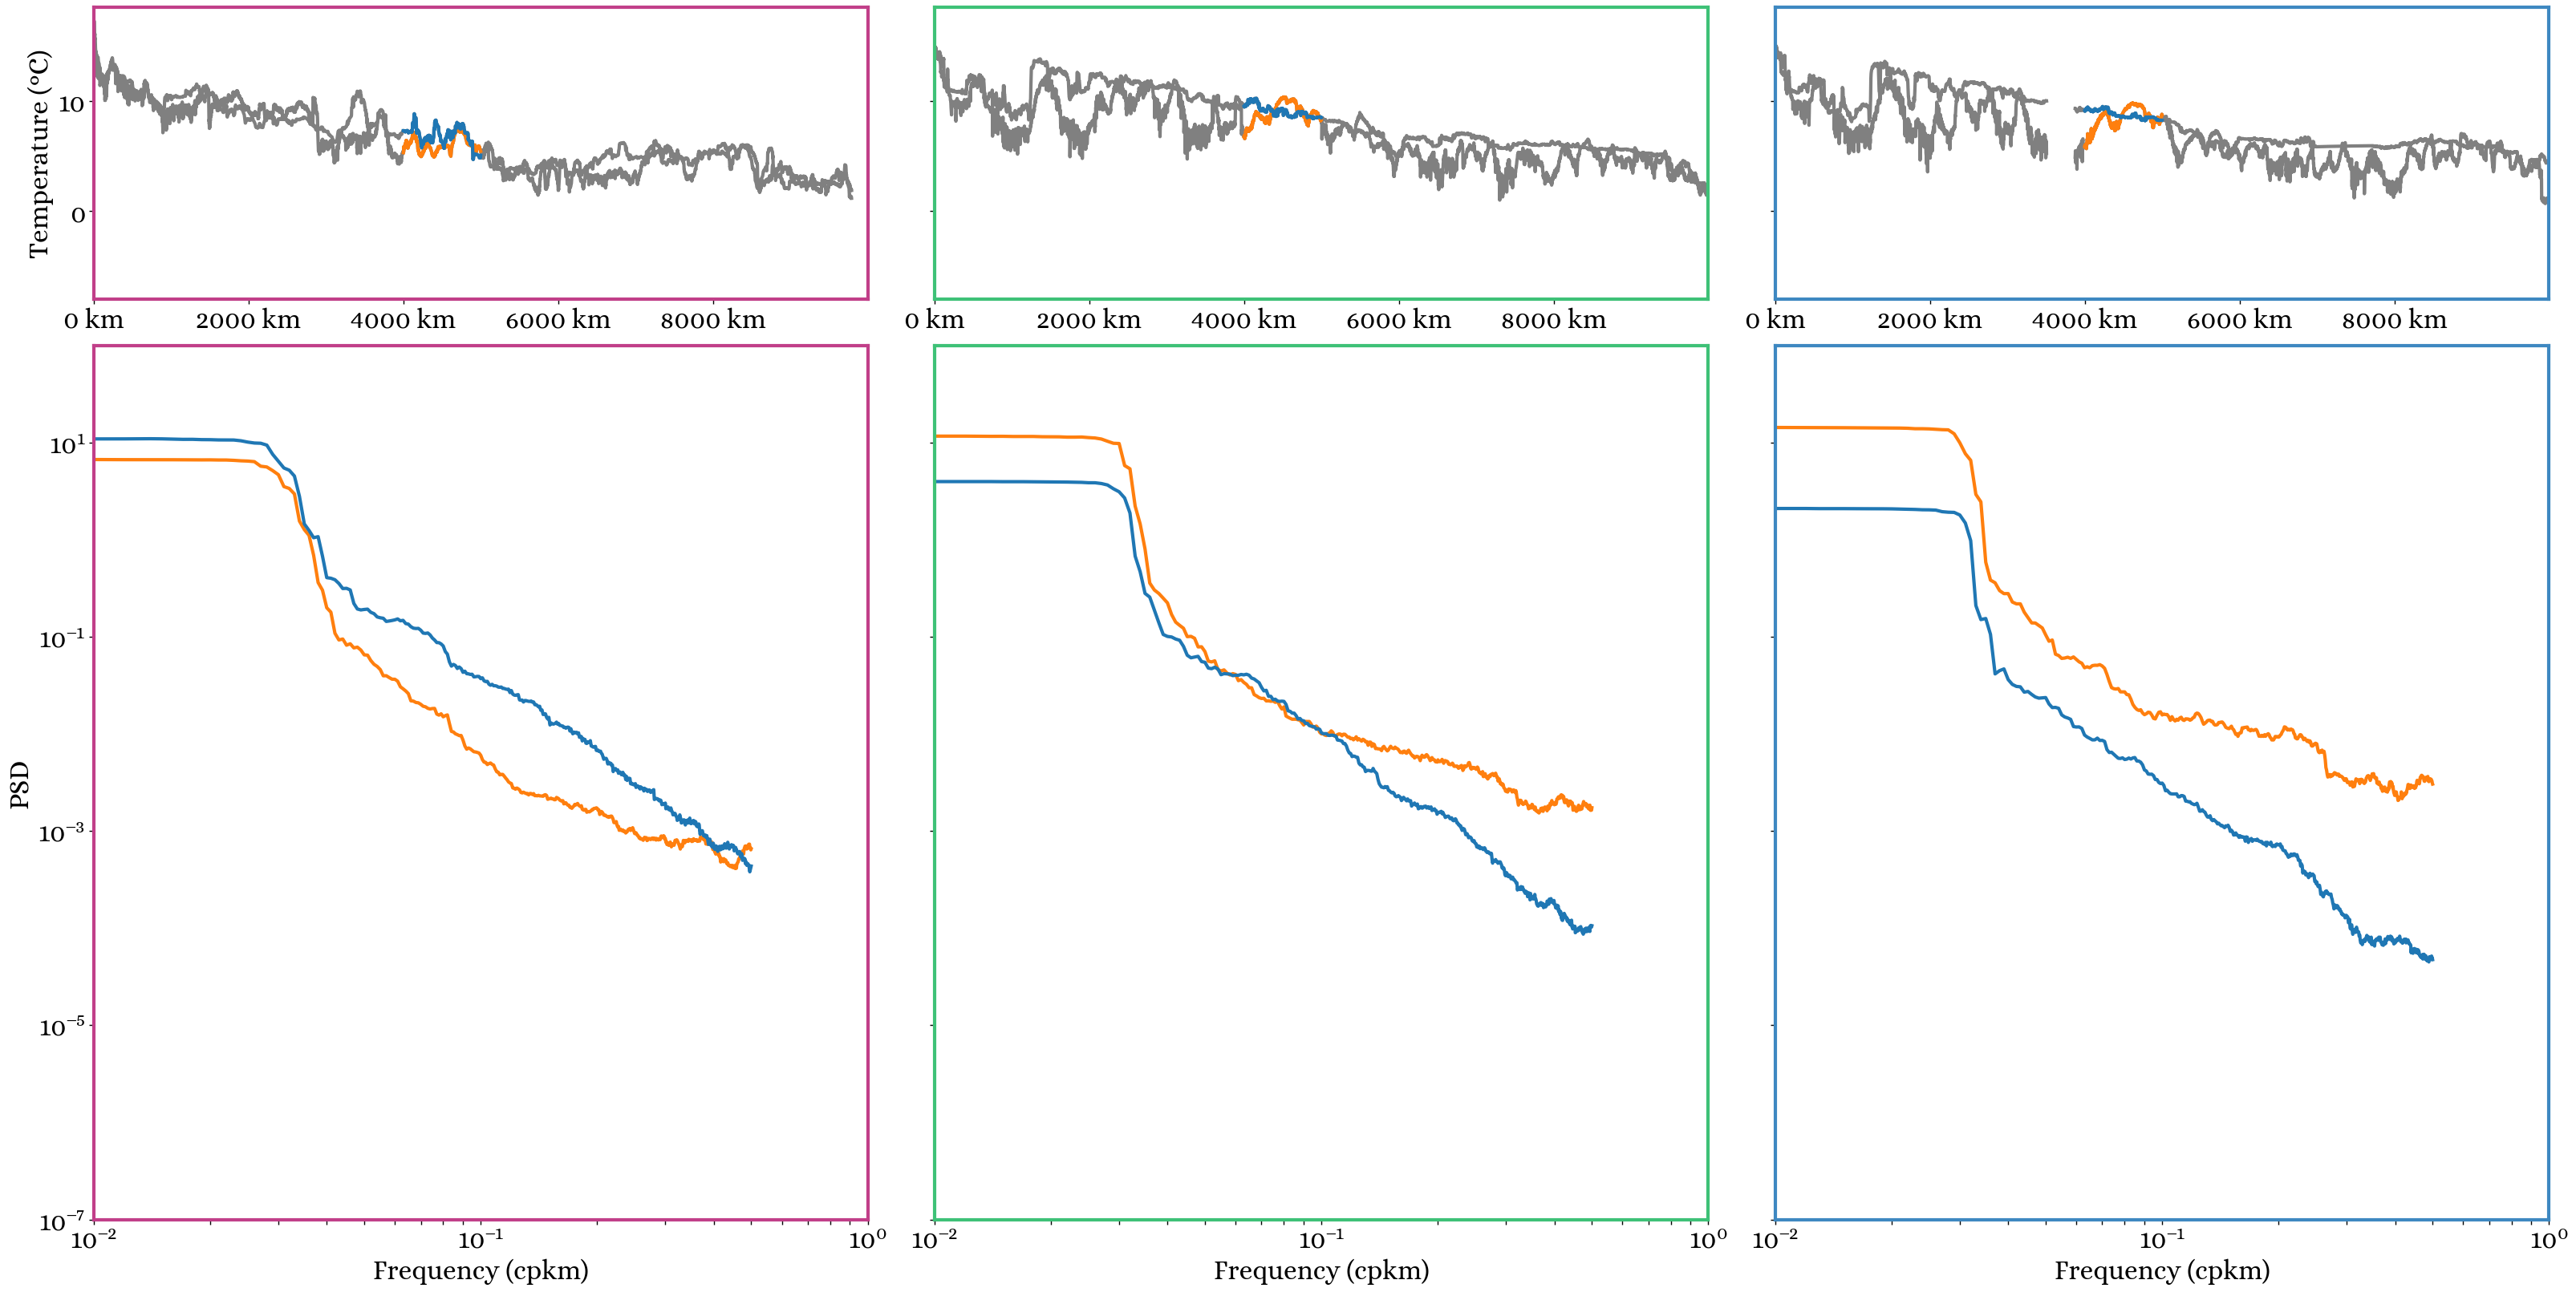

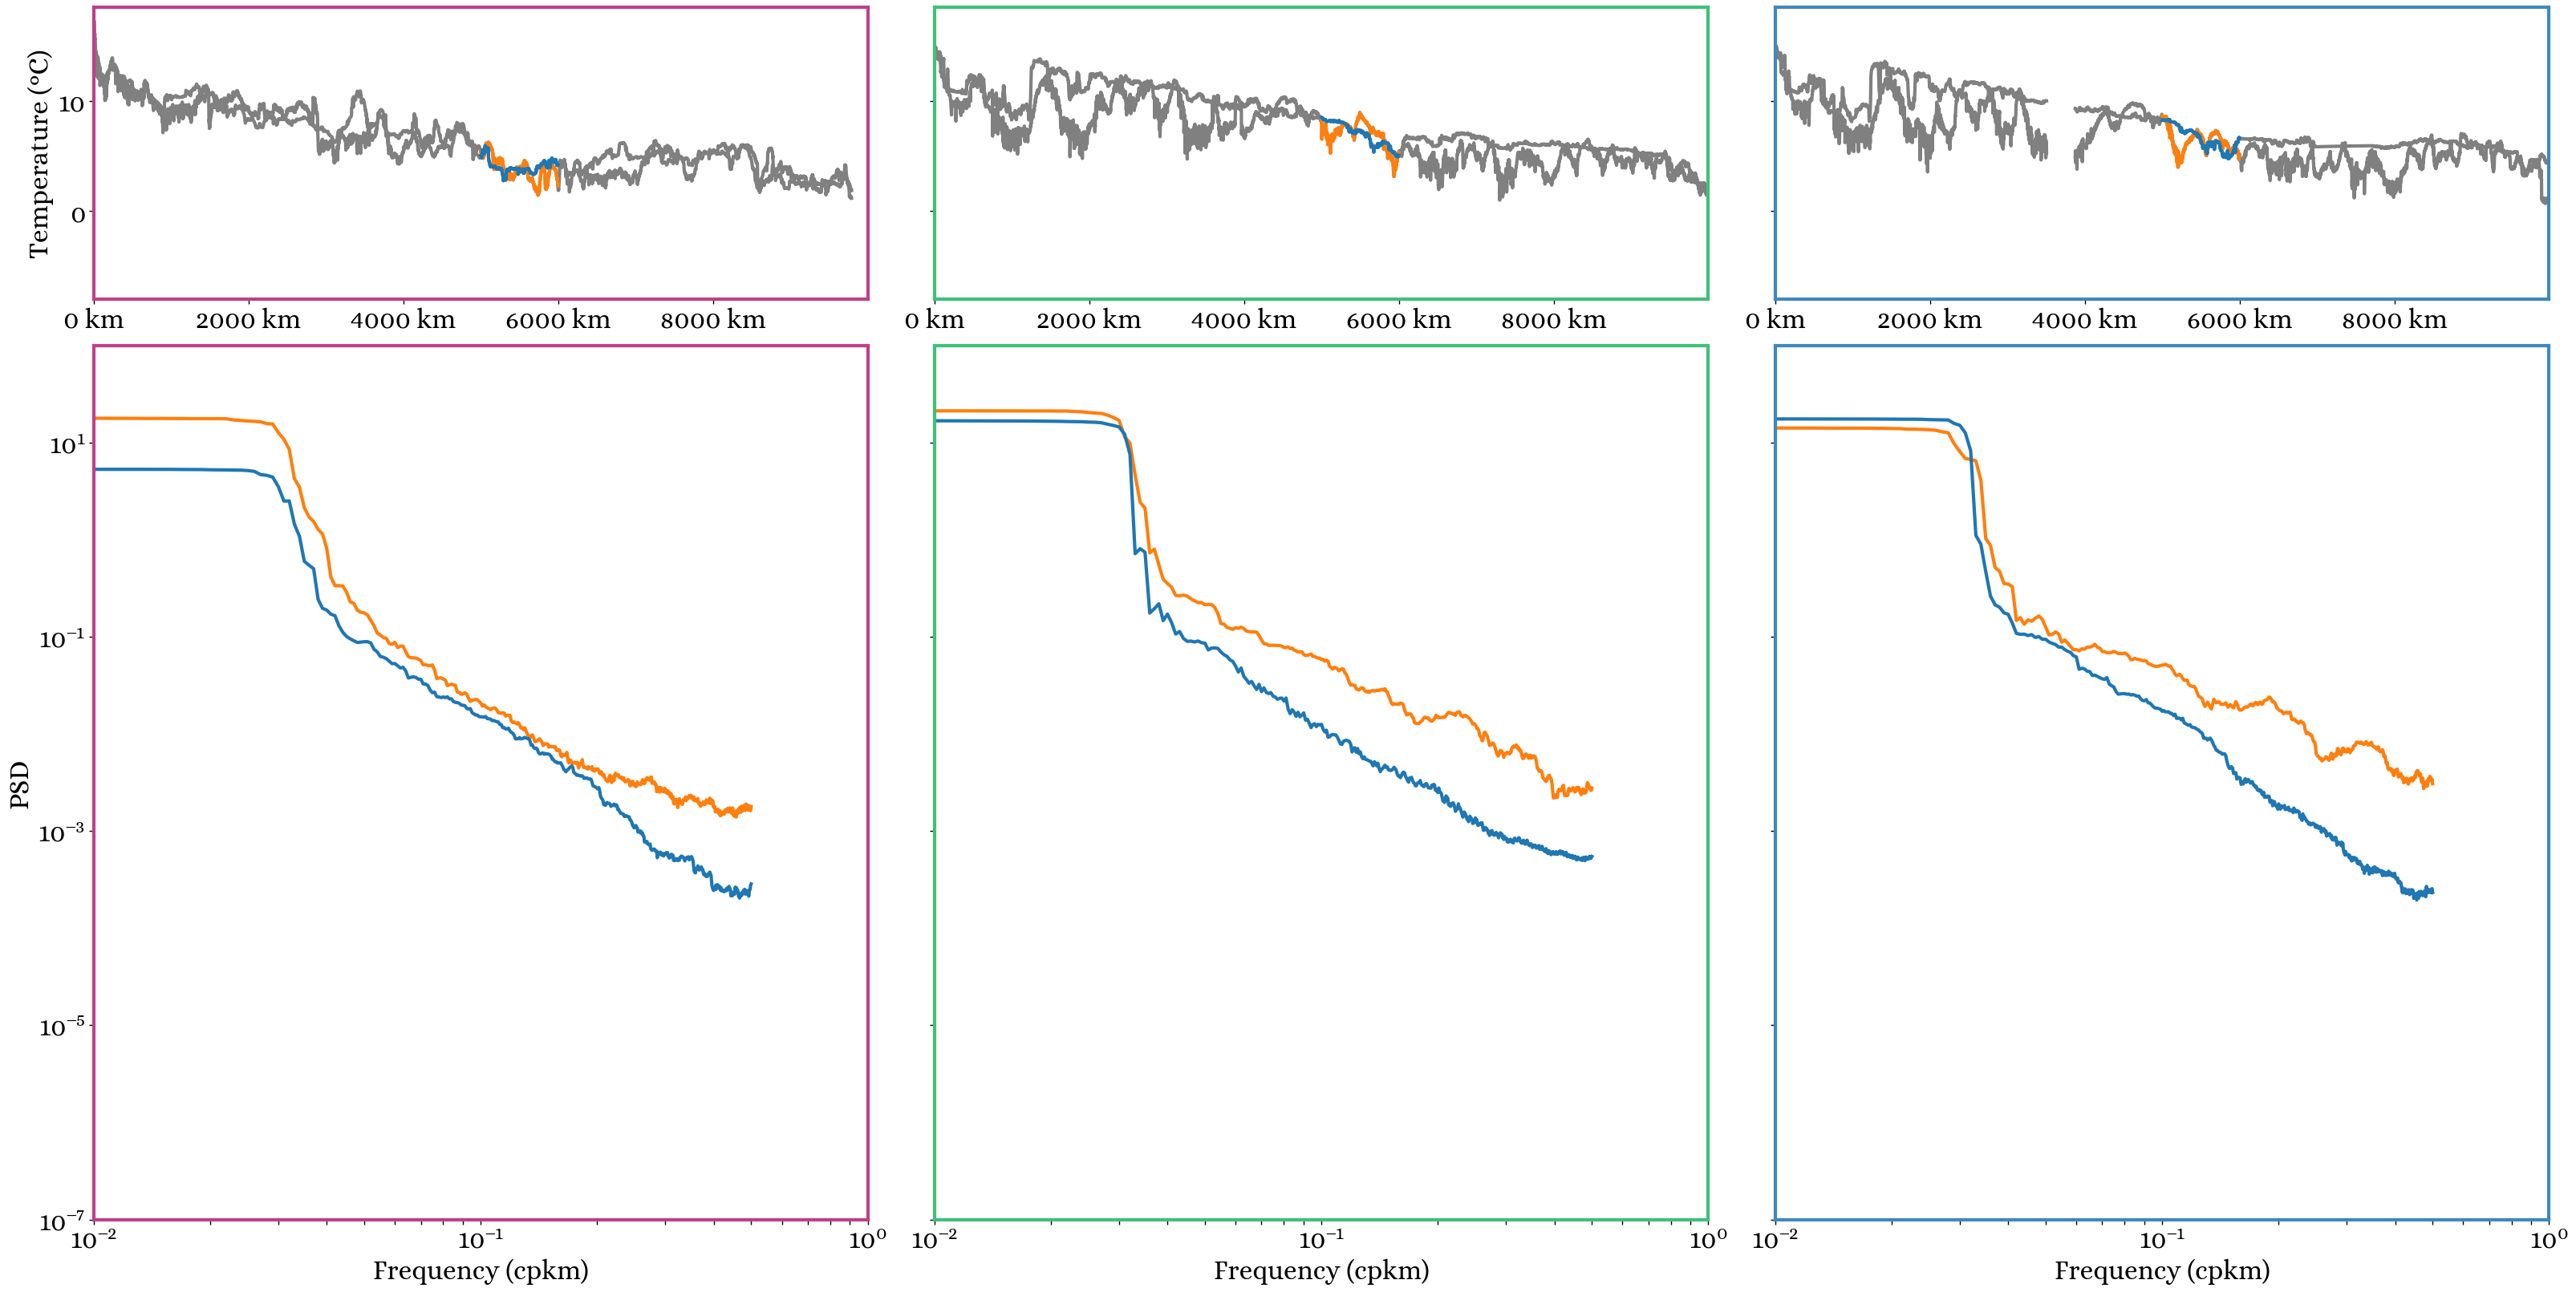

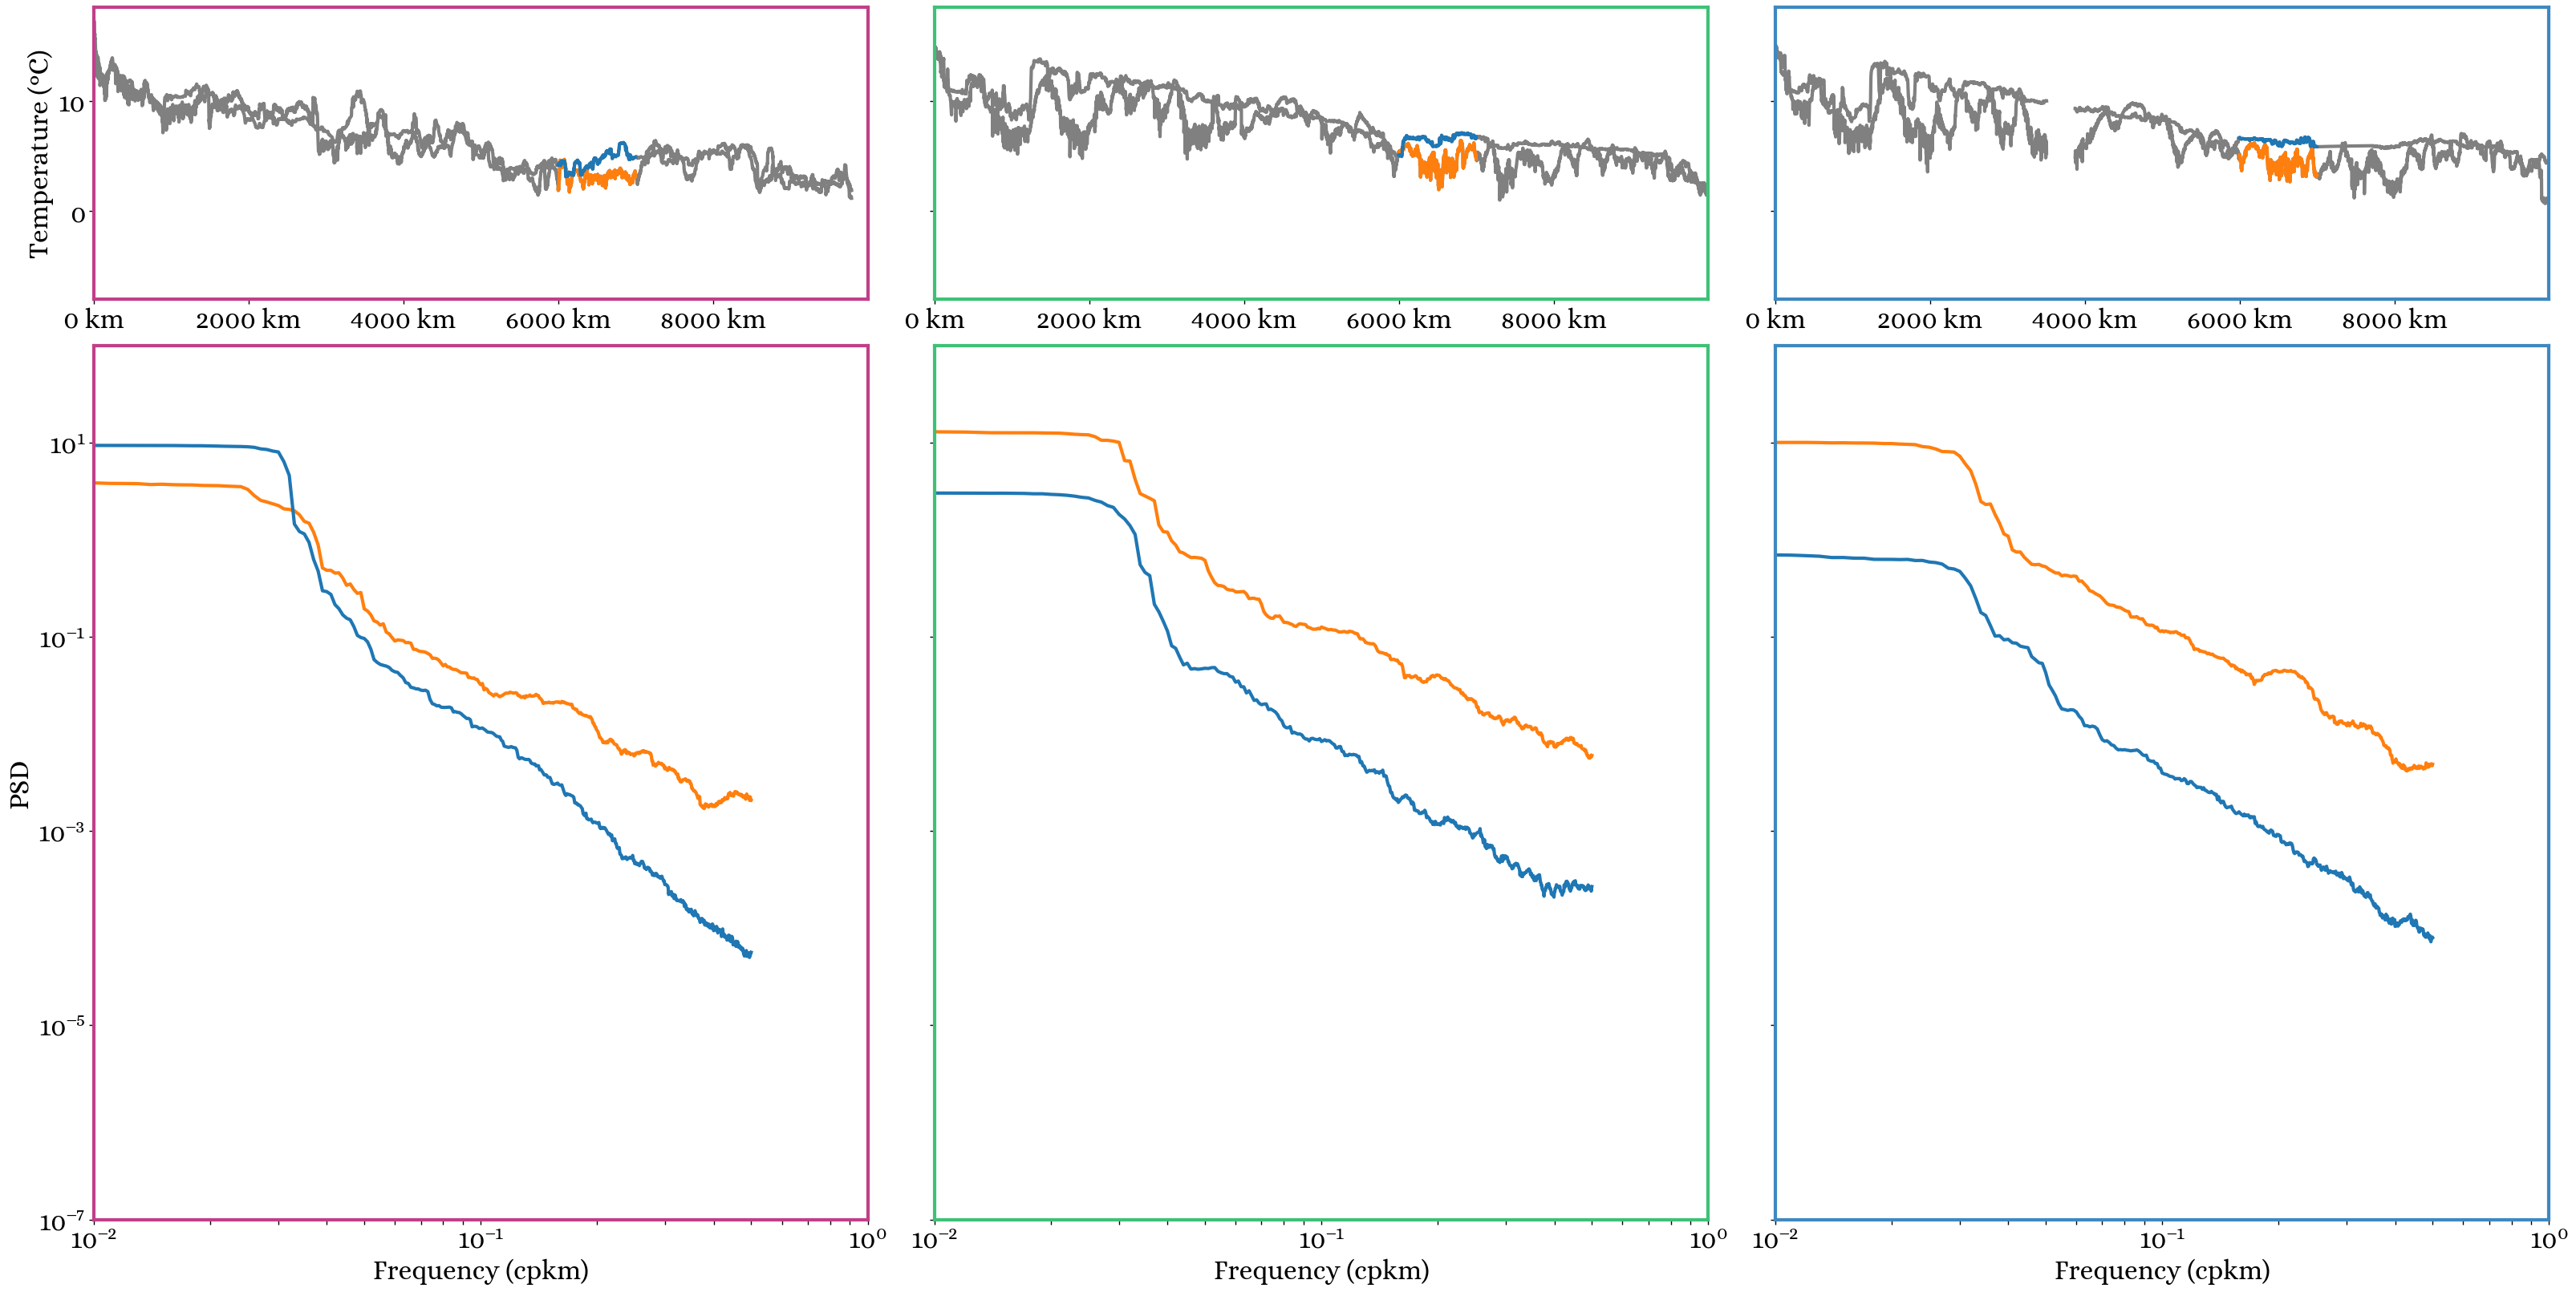

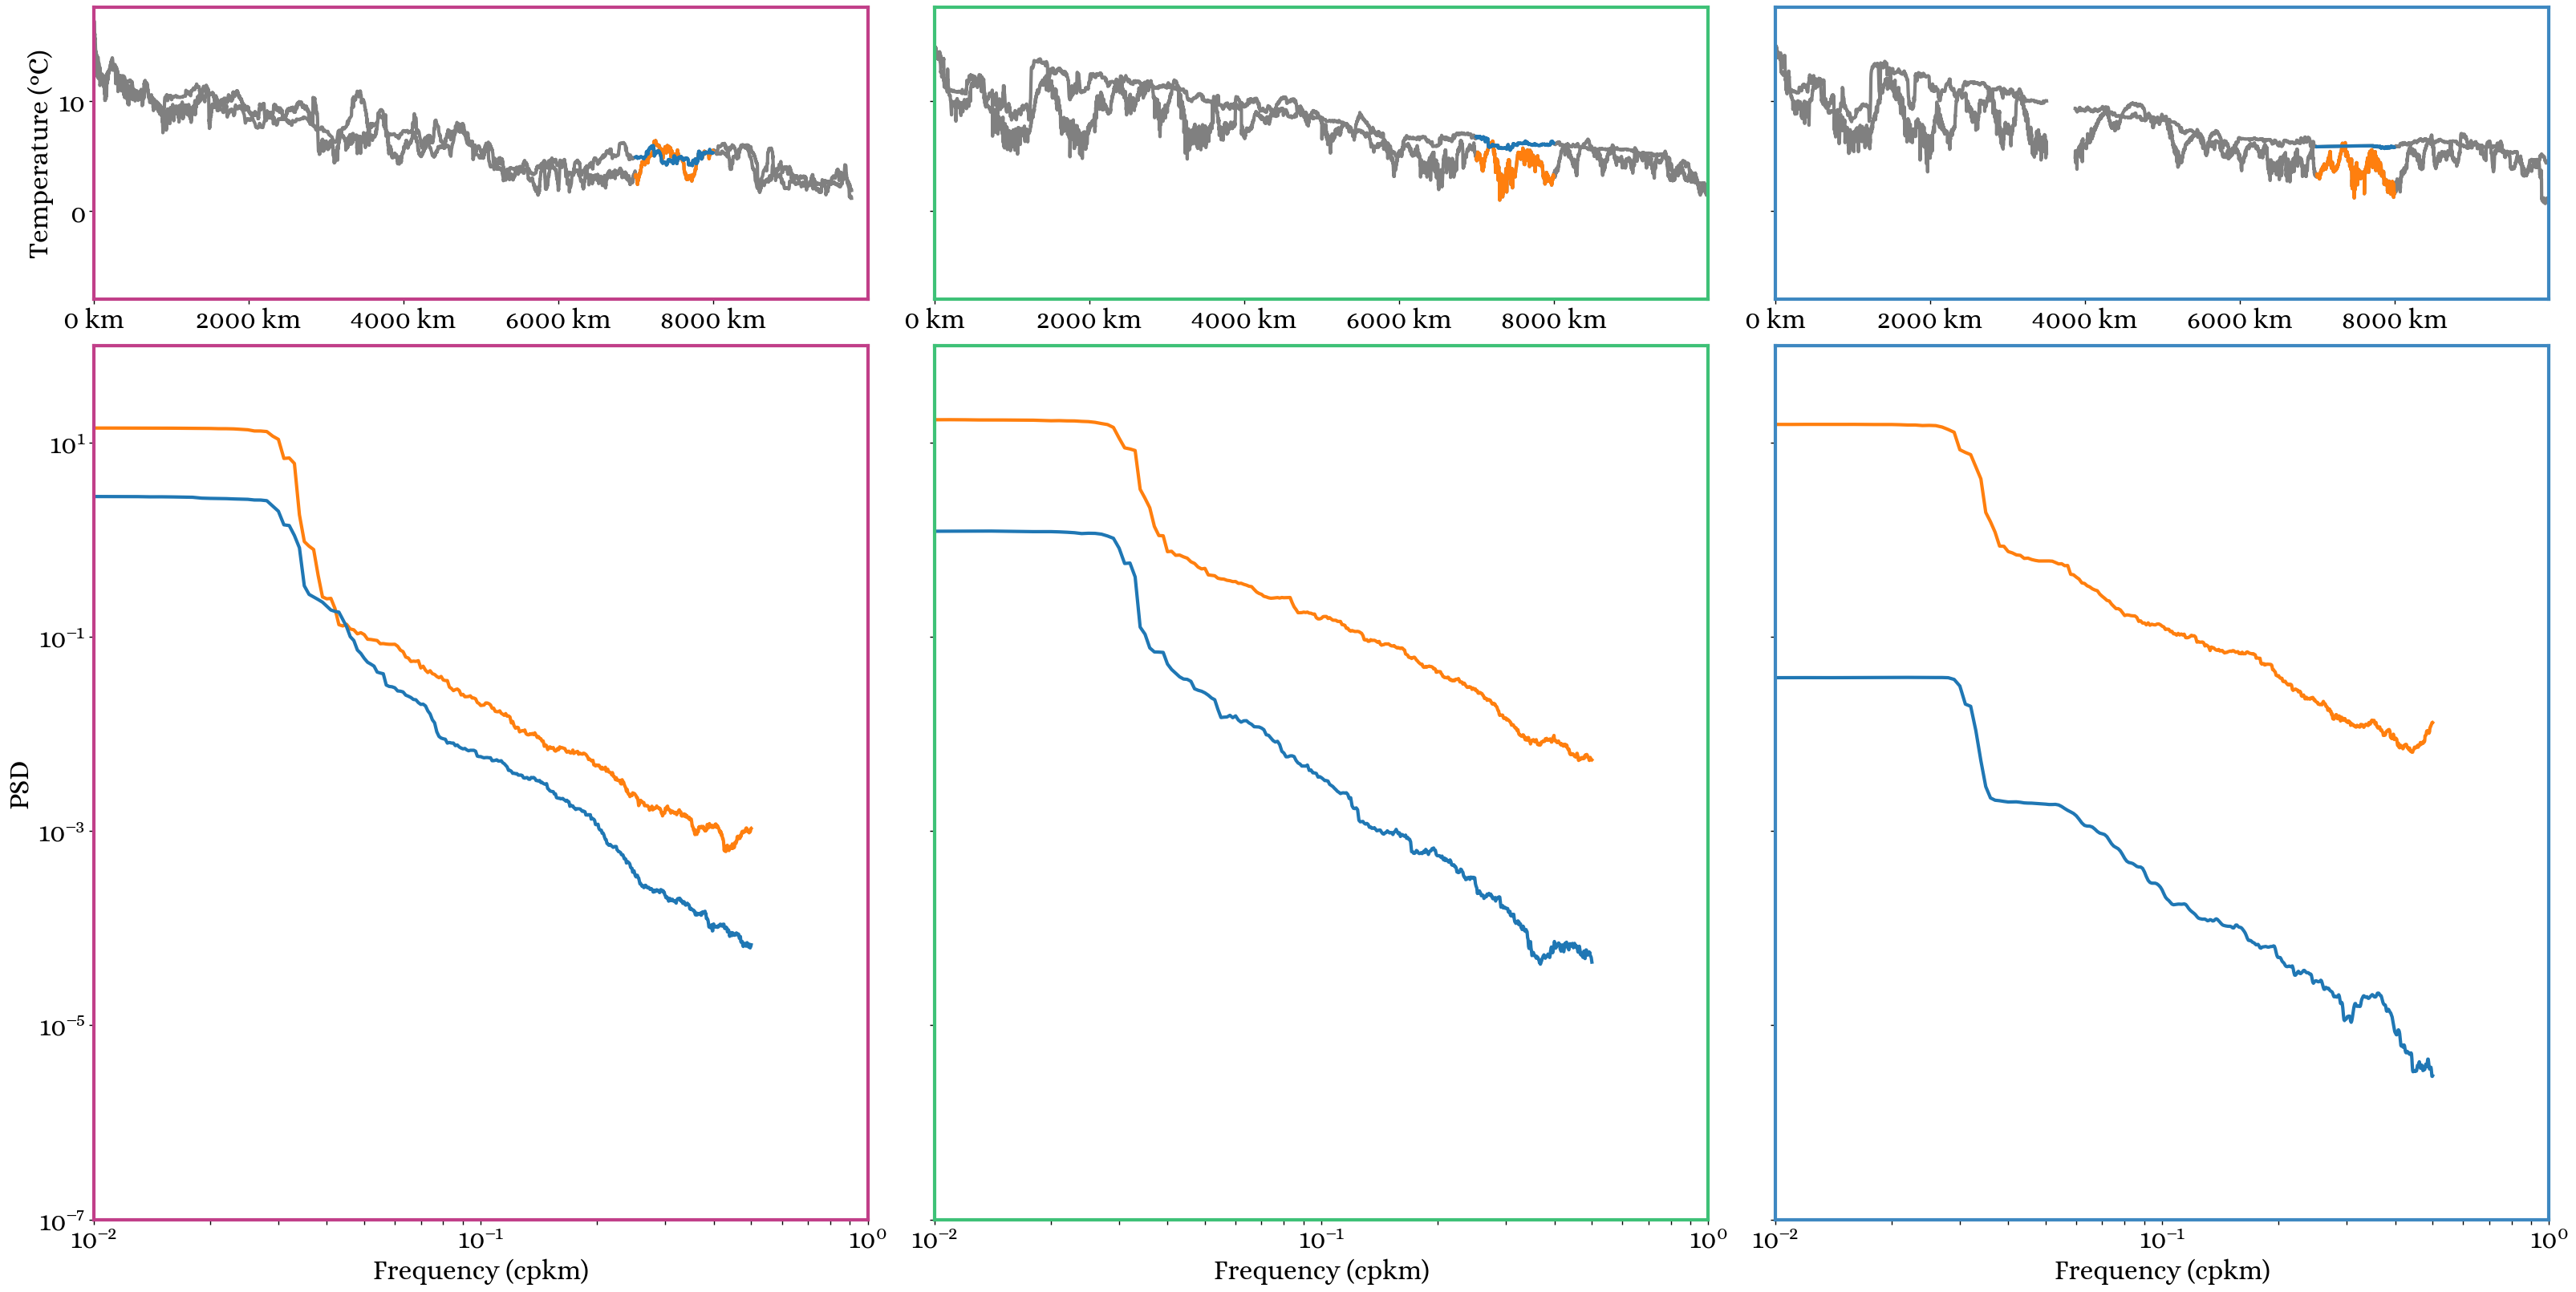

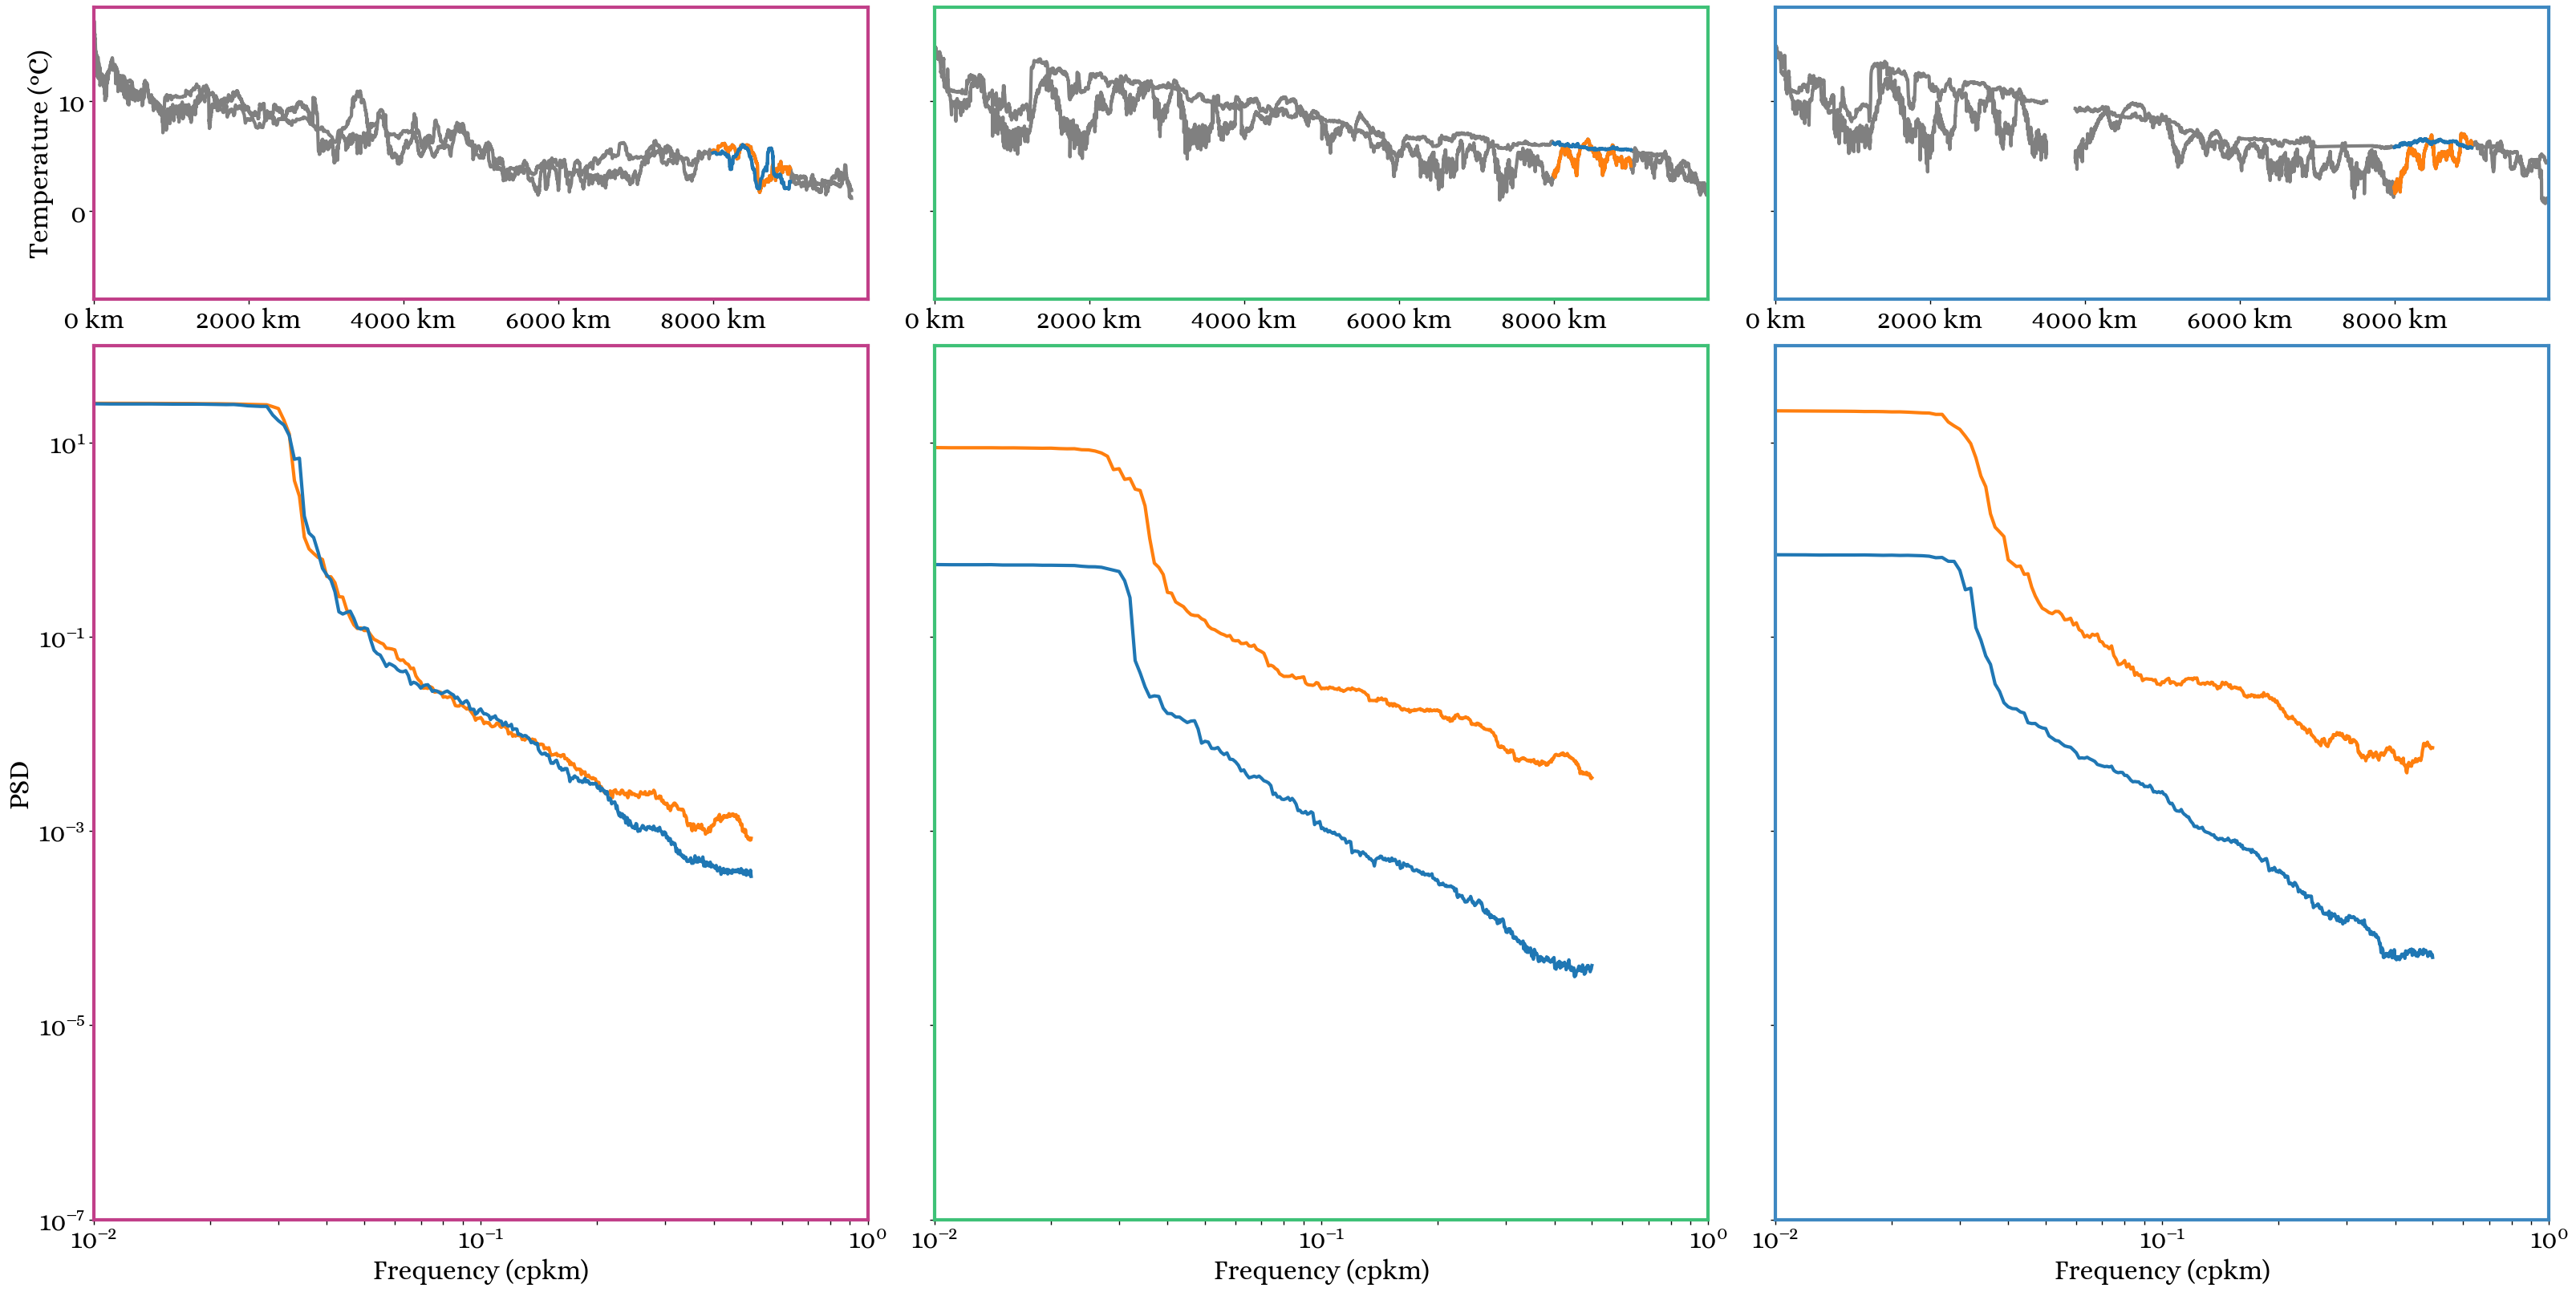

In [366]:
#fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])

cmcolors1 = [plt.get_cmap("Reds")(i / (12)) for i in range(12)][:2:-1]
cmcolors2 = [plt.get_cmap("Blues")(i / (12)) for i in range(12)][:2:-1]

for i,c1,c2 in zip(range(9),cmcolors1,cmcolors2):
    fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])
    for j,(ds1,ds2,axs1,axs2,color) in enumerate(zip([ds205,ds225,ds235],
                                       [ds20_split,ds22_split,ds23_split],
                                       ax[0],ax[1],[c20,c22,c23])):
        
        ds1["airt"].plot(x='distance', lw=3, c="Grey", ax=axs1)
        ds1["sst"].plot(x='distance', lw=3, c="Grey", ax=axs1)
        ds1["airt"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c="C1", ax=axs1)
        ds1["sst"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c="C0", ax=axs1)
        ds2[i]["airt"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c="C1", ax=axs2)
        ds2[i]["sst"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c="C0", ax=axs2)
        axs1.set(xlim=(0,1e7-1),xlabel="",ylabel="Temperature (°C)" if j==0 else "")
        axs2.set(xlim=(1e-2,1e0),xlabel="Frequency (cpkm)", ylim=(1e-7,1e2), ylabel="PSD" if j == 0 else "")
        axs1.xaxis.set_major_formatter(FuncFormatter(km_formatter))
        fix_spines(axs1,color)
        fix_spines(axs2,color)

        if j == 1:
            axs2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)))

    plt.savefig(f"/Users/xedhjo/Documents/Projects/saildrone_fronts_paper/figures/spectra_test/step_{str(i).zfill(2)}")
#axs.legend(ncol=2, fontsize='small')


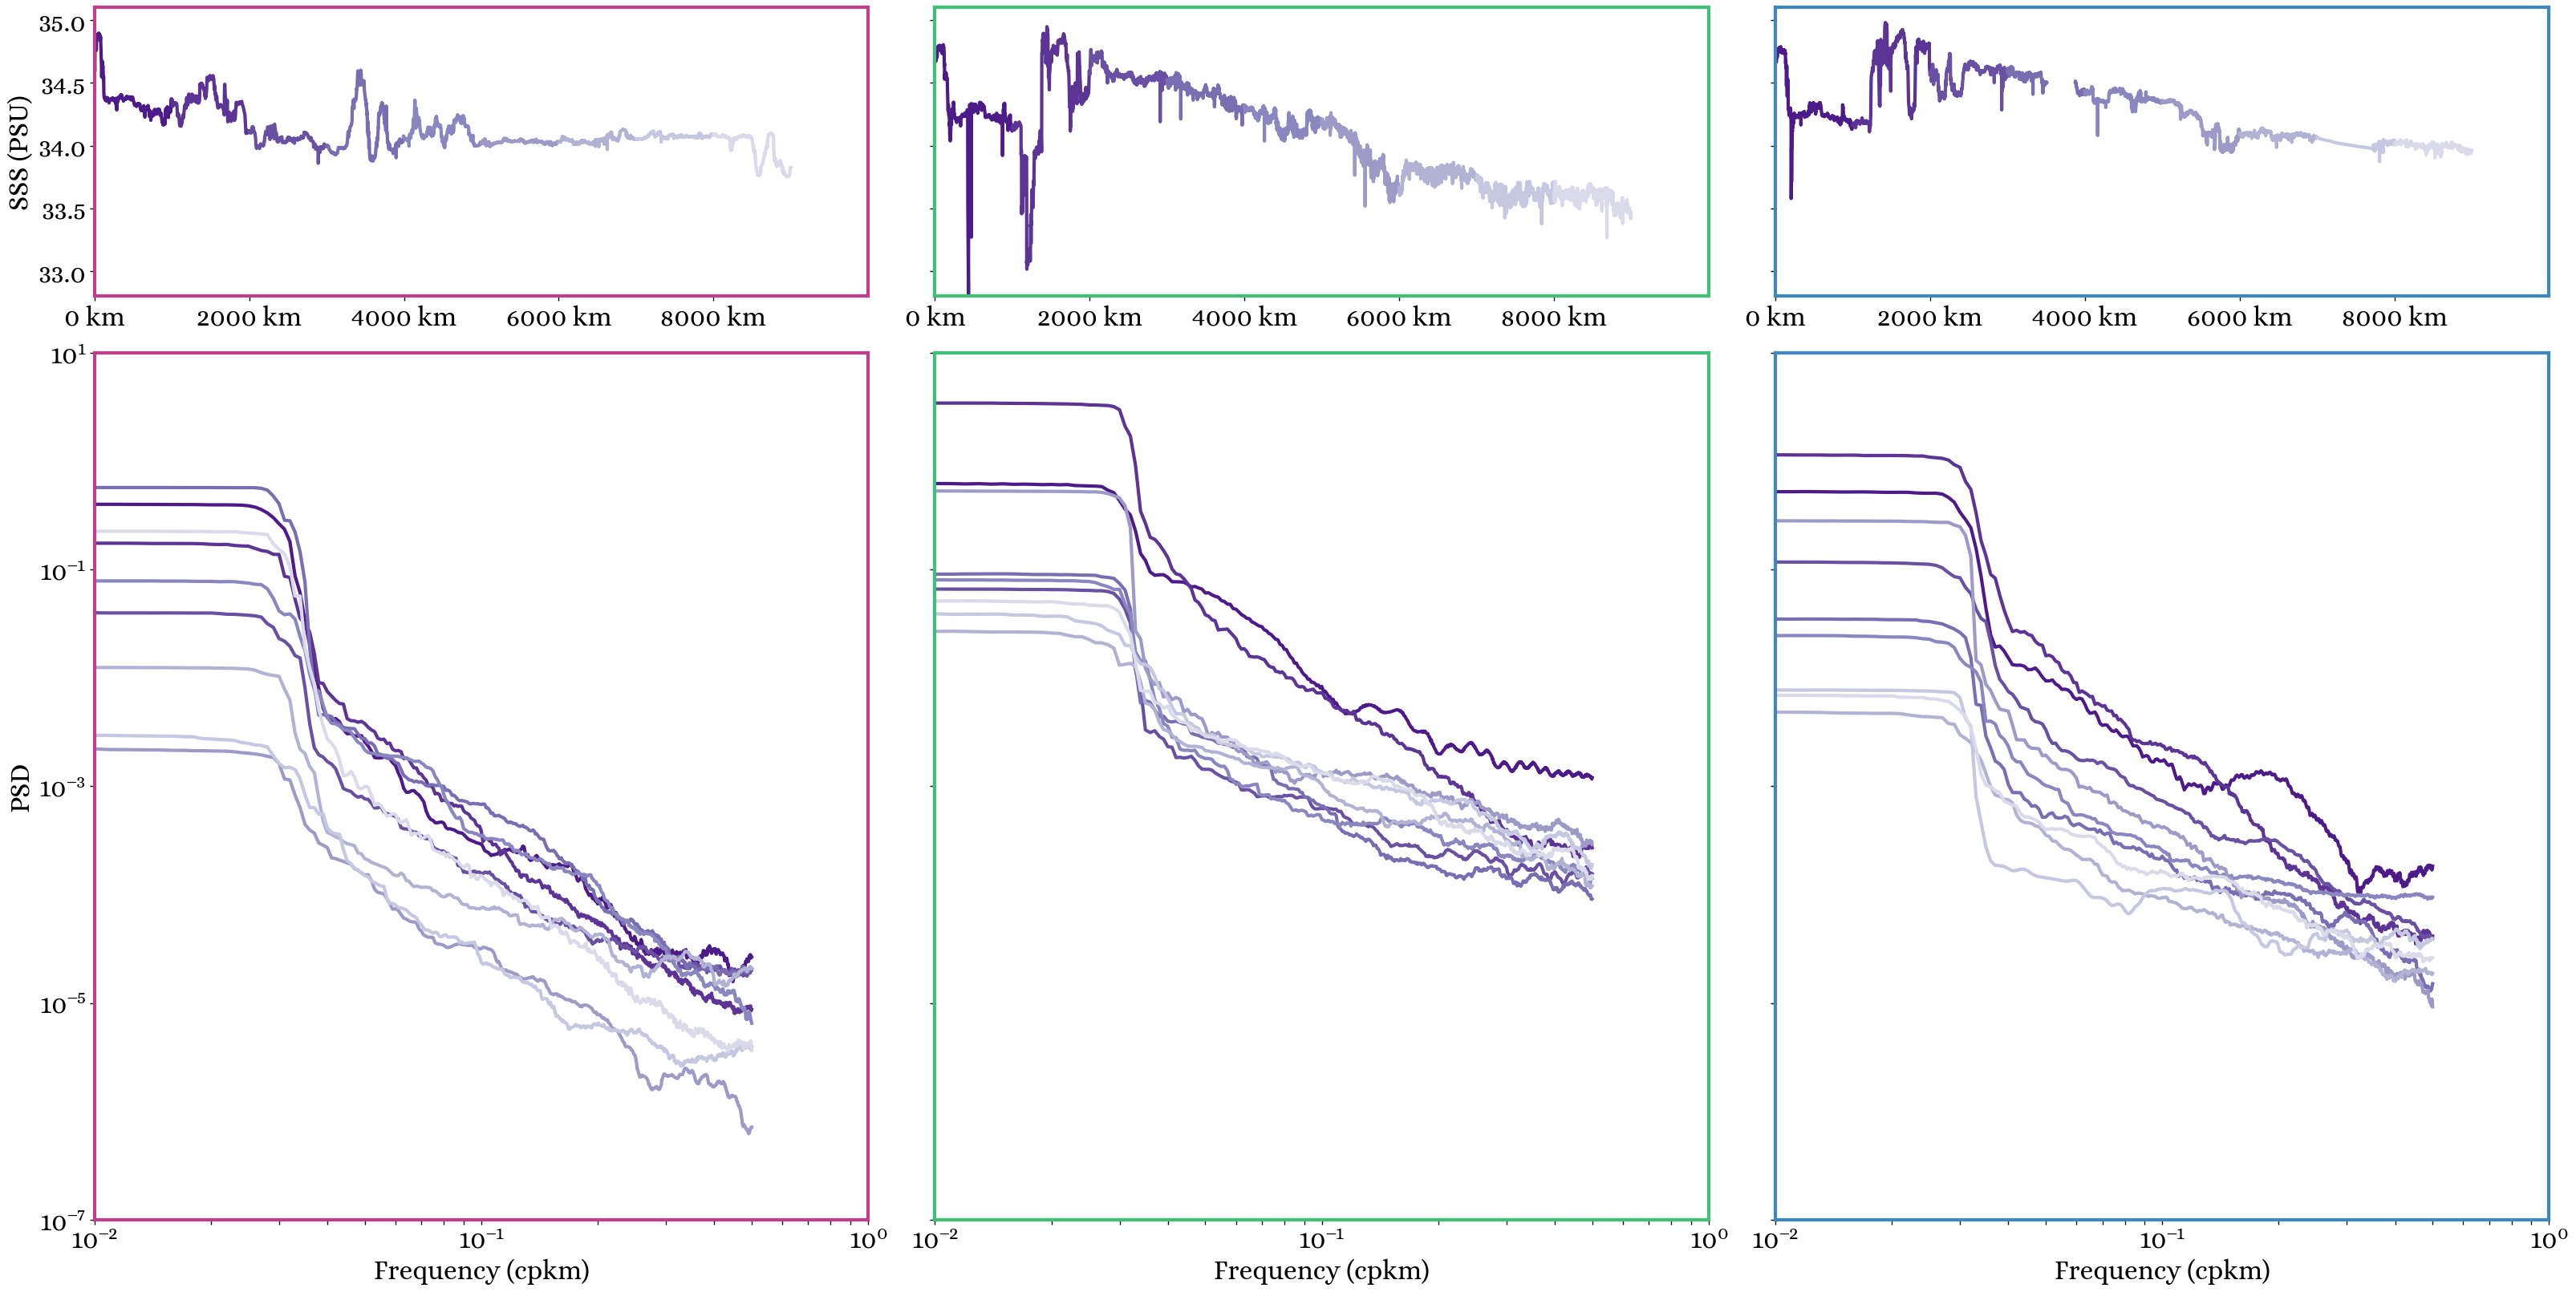

In [340]:
fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])

cmcolors = [plt.get_cmap("Purples")(i / (12)) for i in range(12)][:2:-1]
for i,c in zip(range(9),cmcolors):
    #fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])
    for j,(ds1,ds2,axs1,axs2,color) in enumerate(zip([ds205,ds225,ds235],
                                       [ds20_split,ds22_split,ds23_split],
                                       ax[0],ax[1],[c20,c22,c23])):
        
        ds1["sss"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c=c, ax=axs1)
        ds2[i]["sss"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c=c, ax=axs2)
        axs1.set(xlim=(0,1e7-1),xlabel="", ylim=(32.8,35.1) ,ylabel="SSS (PSU)" if j==0 else "")
        axs2.set(xlim=(1e-2,1e0),xlabel="Frequency (cpkm)", ylim=(1e-7,1e1), ylabel="PSD" if j == 0 else "")
        axs1.xaxis.set_major_formatter(FuncFormatter(km_formatter))
        fix_spines(axs1,color)
        fix_spines(axs2,color)

        if j == 1:
            axs2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)))

    #plt.savefig(f"/Users/xedhjo/Documents/Projects/saildrone_fronts_paper/figures/spectra_test/step_{str(i).zfill(2)}")
#axs.legend(ncol=2, fontsize='small')


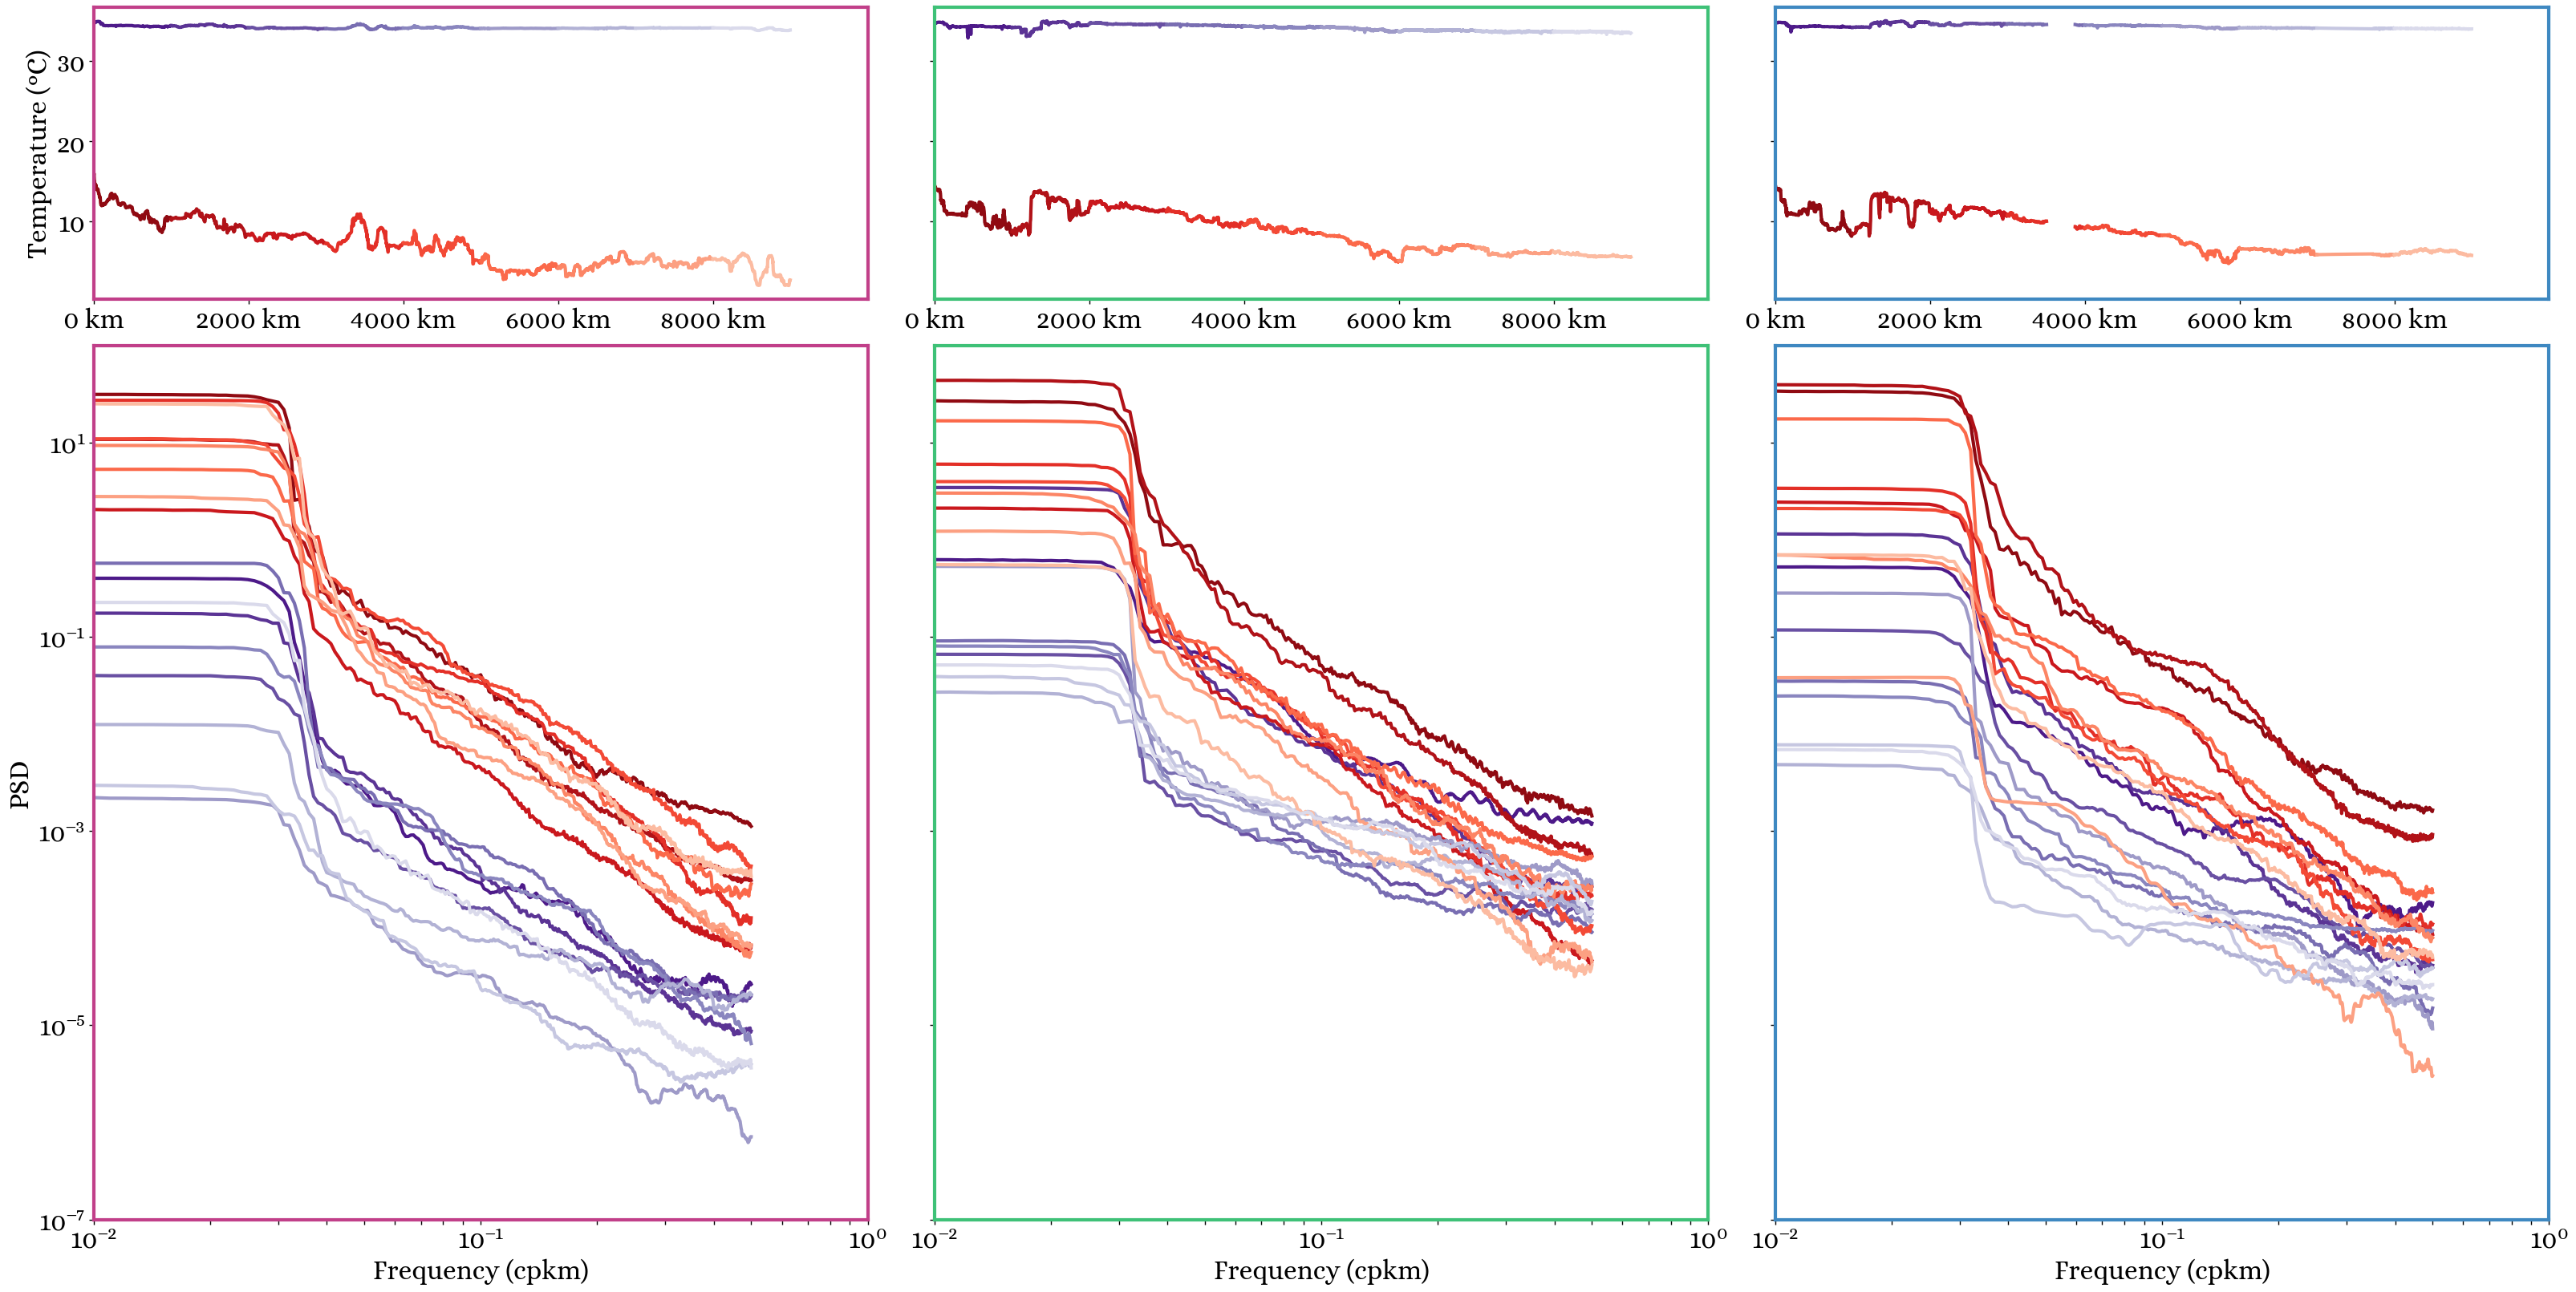

In [356]:
fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])

cmcolors1 = [plt.get_cmap("Reds")(i / (12)) for i in range(12)][:2:-1]
cmcolors2 = [plt.get_cmap("Purples")(i / (12)) for i in range(12)][:2:-1]

for i,c1,c2 in zip(range(9),cmcolors1,cmcolors2):
    #fig,ax = plt.subplots(2,3,figsize=(32,16),constrained_layout=True,sharey="row",height_ratios=[1,3])
    for j,(ds1,ds2,axs1,axs2,color) in enumerate(zip([ds205,ds225,ds235],
                                       [ds20_split,ds22_split,ds23_split],
                                       ax[0],ax[1],[c20,c22,c23])):
        
        ds1["sst"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c=c1, ax=axs1)
        ds1["sss"].isel(distance=np.arange(km*i,km*(i+1))).plot(x='distance', lw=3, c=c2, ax=axs1)
        ds2[i]["sst"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c=c1, ax=axs2)
        ds2[i]["sss"].plot(x='frequency', lw=3, yscale='log', xscale='log', label=name, c=c2, ax=axs2)
        axs1.set(xlim=(0,1e7-1),xlabel="",ylabel="Temperature (°C)" if j==0 else "")
        axs2.set(xlim=(1e-2,1e0),xlabel="Frequency (cpkm)", ylim=(1e-7,1e2), ylabel="PSD" if j == 0 else "")
        axs1.xaxis.set_major_formatter(FuncFormatter(km_formatter))
        fix_spines(axs1,color)
        fix_spines(axs2,color)

        if j == 1:
            axs2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)))

    #plt.savefig(f"/Users/xedhjo/Documents/Projects/saildrone_fronts_paper/figures/spectra_test/step_{str(i).zfill(2)}")
#axs.legend(ncol=2, fontsize='small')


In [391]:
def plot_ref_slope(fmin,fmax,f,ax,kvec=[2,3],col='Grey',lw=2,ls='--'):

    """ This function draws reference slopes (k=-2, k=-4 for instance)
    Arguments:
    fmin=frequency where to start the reference the slope
    fmax=fmin=frequency where to end the reference the slope
    f= y intercept of the slope
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    kvec=[2]: list containing the reference values of k, whose slope to draw
    col='k': colors of the slopes
    lw=2: linewidths of the slopes
    ls=--: linestyles of the slopes

    Author: Nicolas Barrier
    """

    x=np.linspace(fmin,fmax,5)
    
    for p in range(0,len(kvec)):
        k=kvec[p]
        y=np.log(f)+k*(np.log(fmin)-np.log(x[:]))
        yout=np.exp(y)
        ax.loglog(x,yout,color=col,linewidth=lw,linestyle=ls)
        ax.text(x[-3], yout[-1], r'      $k^{-' + str(k) + '}$', ha='left', va='center', color=col)

In [431]:
def plot_slope(xf,yf,N,fmin,fmax):
    """
    Output slope of spectral using defined boundaries
    """
    
    i=np.nonzero((xf>=fmin)&(xf<=fmax)&(xf!=0))[0]
    xf=xf[i]
    yf=yf[i]
    
    
    
   # y=2.0/N * np.abs(yf[0:N//2])
    Y=np.log(yf)
    X=np.log(xf)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

    #confidence_interval = 2.58*std_err #99%
    confidence_interval = 1.96*std_err #95%


    p=np.polyfit(X,Y,1)

    offy=1

    trend=np.exp(p[0]*X+p[1]+offy)
    xvalue=xf
    return trend,slope,intercept,xvalue,confidence_interval

## Calculate multitaper arrays

In [515]:
# Create lists to store variables for zipping
datasets = [ds205, ds225, ds235]
labels = ["SD1020", "SD1022", "SD1023"]
colors = [c20, c22, c23]

### Define variables
names = ['wind', 'airt', 'rhum', 'sst', 'sss',"COG","HDG","tasf"]
titles = ['Wind speed', 'Air temperature', 'Relative humidity', 'Sea surface temperature', 'Sea surface salinity', "Course over ground", "Heading","Turbulent fluxes"]
units = ["m s$^{-1}$", "°C", "%", "°C", "PSU", "°", "°", " W m$^{-2}$"]


### Some constants
# Define the time step (in days)
dt = 1
# Define the number of tapers to use in multitaper analysis
P = 32

In [517]:
P = 32
km_mt32 = []

for ds in tqdm([ds205, ds225, ds235], desc='Processing datasets'):
    ms = []
    for var in tqdm(names, desc='Processing variables', leave=False):
        cv = ds[var].values
        spec = MTSpec(cv - np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
        ms.append(spec)
    km_mt32.append(ms)

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [520]:
kmcvs = []
kmf0s = []
kmS0s = []

for ds in tqdm([ds205, ds225, ds235], desc='Processing datasets'):
    cv = []
    f0 = []
    S0 = []
    for var in tqdm(names, desc='Processing variables', leave=False):
        f,s = sg.periodogram(ds[var].values - np.mean(ds[var].values), fs=1/dt)
        cv.append(ds[var].values)
        f0.append(f)
        S0.append(s)
        
    kmcvs.append(cv)
    kmf0s.append(f0)
    kmS0s.append(S0)

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

Processing variables:   0%|          | 0/8 [00:00<?, ?it/s]

In [529]:
km_mt32[2][0].spec

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

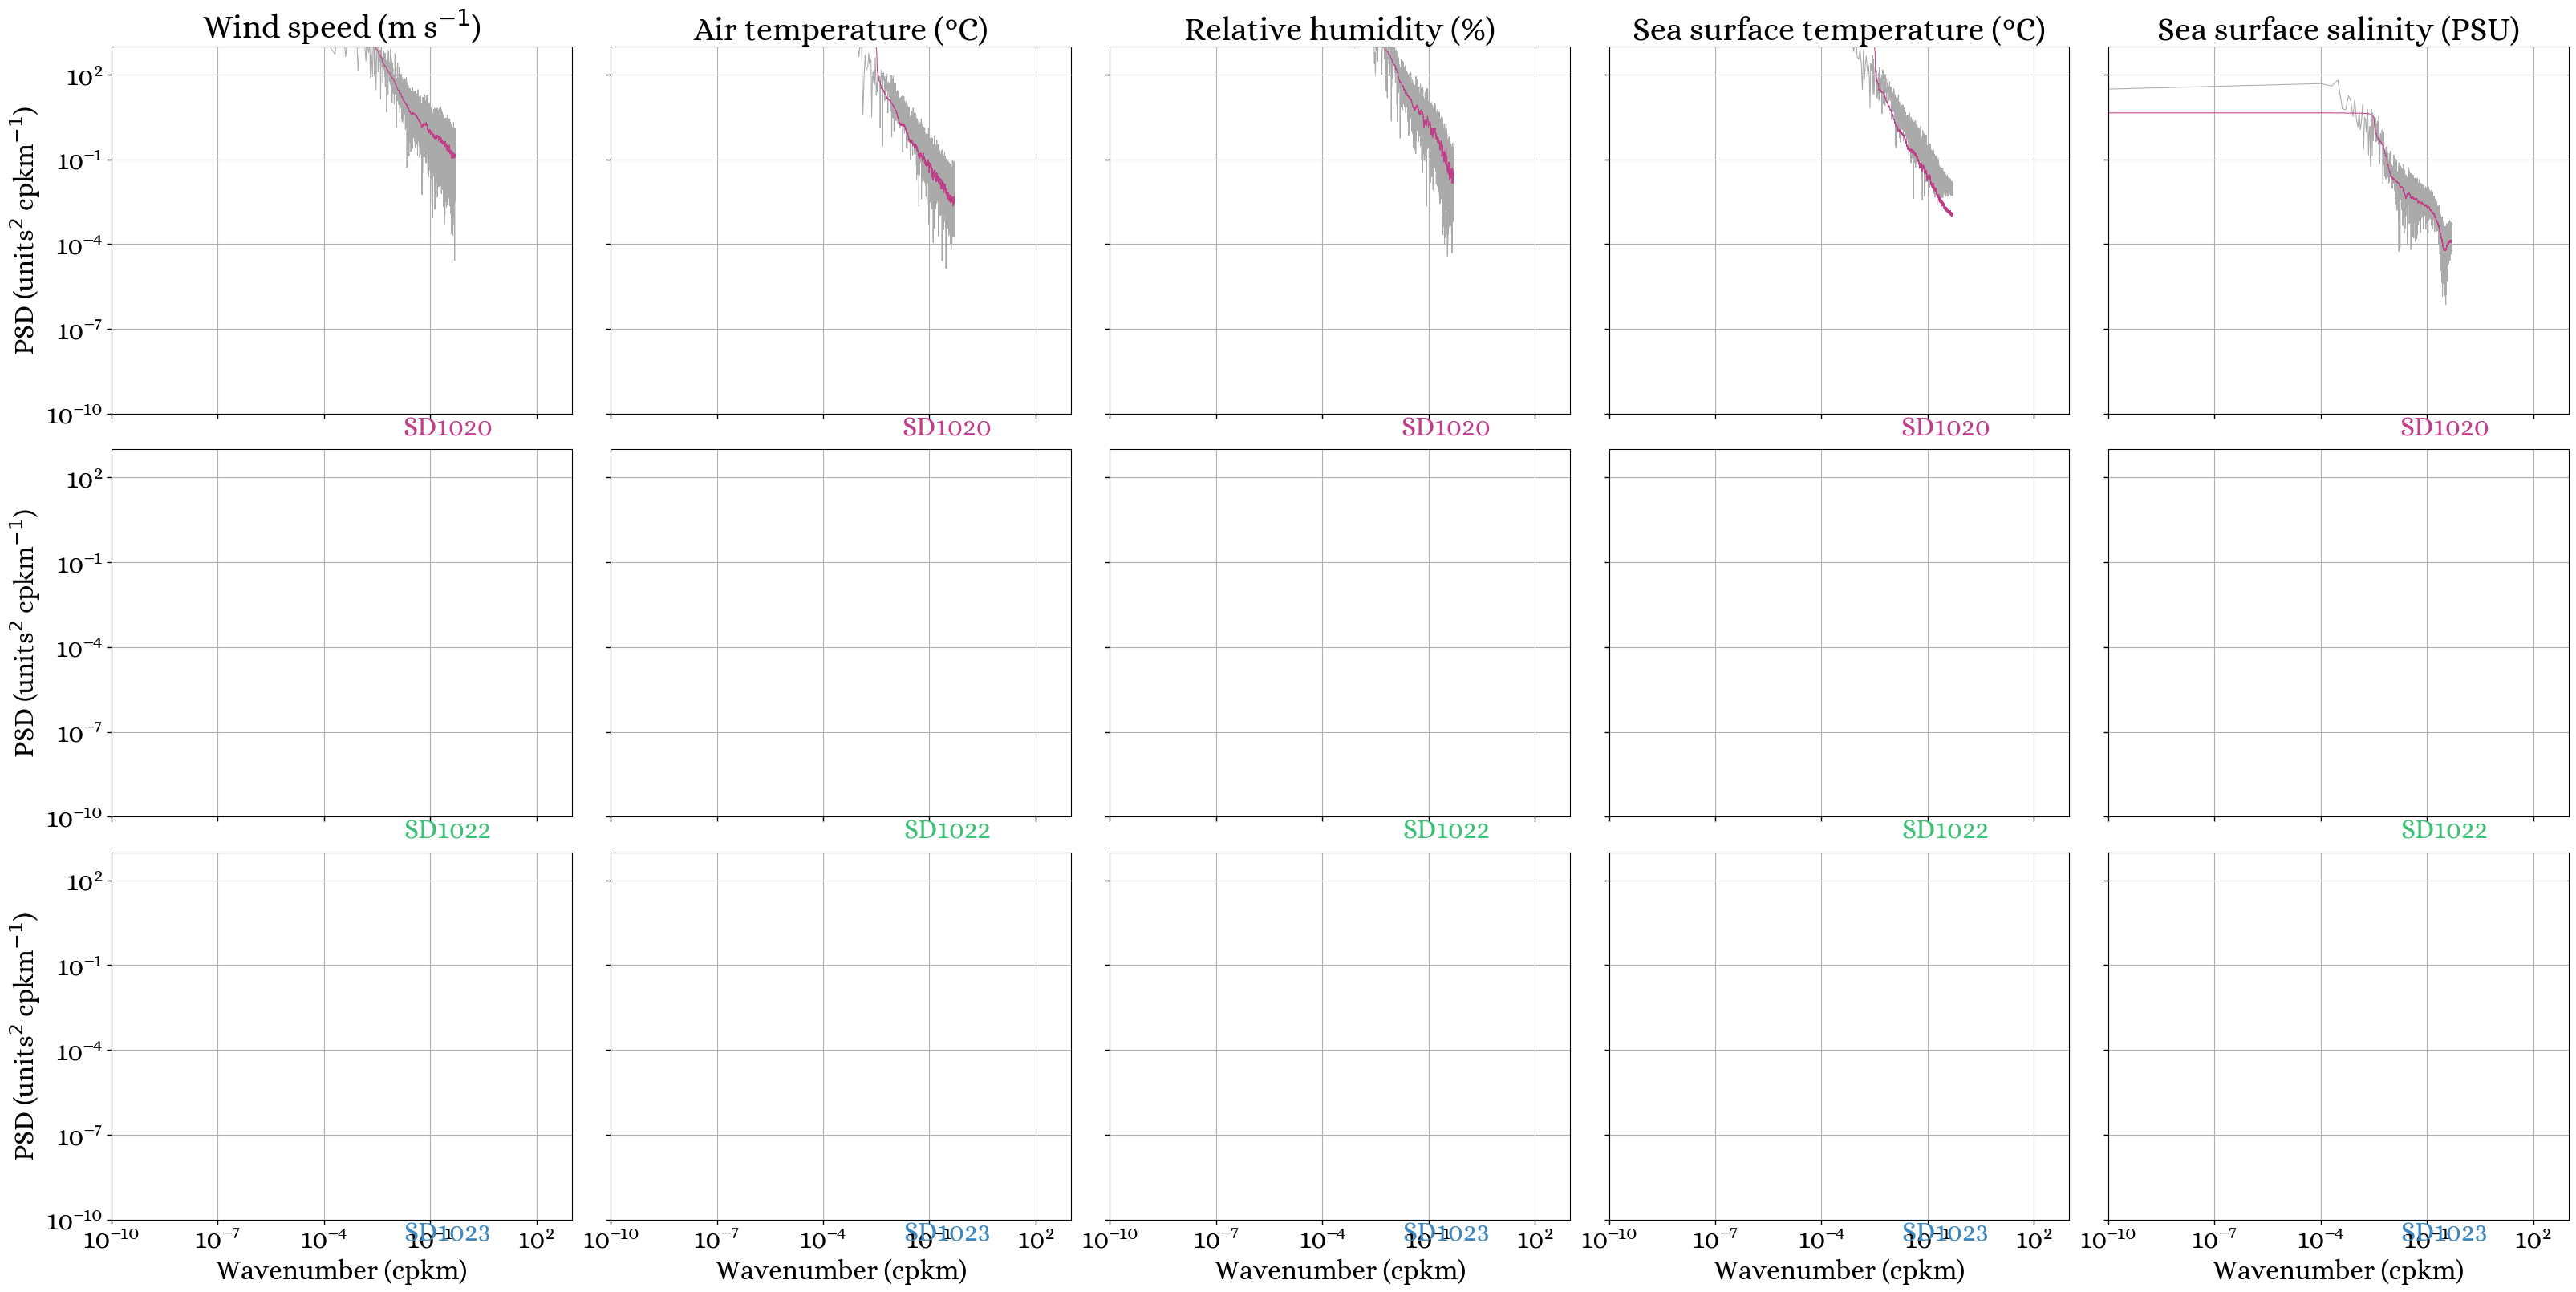

In [489]:
# Create a grid of subplots with 3 rows and 5 columns
fig, ax = plt.subplots(3, 5, figsize=(16*2, 8*2), constrained_layout=True, sharex=True, sharey=True)

# Iterate over each subplot row (i), dataset (ds), label (l), and color (c) using enumerate
for i, (AX, ds, l, c, ms, f0, S0) in enumerate(zip(ax, datasets, labels, colors, km_mt32, kmf0s, kmS0s)):
    # Iterate over each subplot column (j), variable (var), title (t), and unit (u) using enumerate
    for j, (axs, var, t, u, spec,f,S) in enumerate(zip(AX, names, titles, units, ms, f0, S0)):
        # Plot the periodogram and multitaper spectrum
        axs.loglog(f[np.where(f >= 0)], S[np.where(f >= 0)], linewidth=0.75, c="#AAAAAA")  # Periodogram
        axs.loglog(spec.freq[np.where(spec.freq >= 0)], spec.spec[np.where(spec.freq >= 0)], linewidth=0.75, c=c)  # Multitaper spectrum
        # Add label to the subplot
        axs.text(3.16e-1, 3.16e-11, l, c=c, va='center', ha='center', fontweight='bold')
        
        # Adjust subplot properties
        axs.autoscale(enable=True, tight=True)
        axs.set(xlim=(1e-10, 1e3),
                ylim=(1e-10, 1e4),
                xlabel="Wavenumber (cpkm)" if "1023" in l else "" ,
                ylabel='PSD (units$^{2}$ cpkm$^{-1}$)' if "wind" in var else "", 
                title=t+f" ({u})" if "1020" in l else "")
        axs.grid()
        
        #idx = np.where(spec.spec[np.where(spec.freq >= 0)] > np.percentile(spec.spec[np.where(spec.freq >= 0)],99.95))[0][-1]

        # Plot reference slope
        #plot_ref_slope(spec.freq[np.where(spec.freq >= 0)][idx],
        #               3e2, 
        #               spec.spec[np.where(spec.freq >= 0)][idx], ax=axs, kvec=[1, 2, 3], col='k')

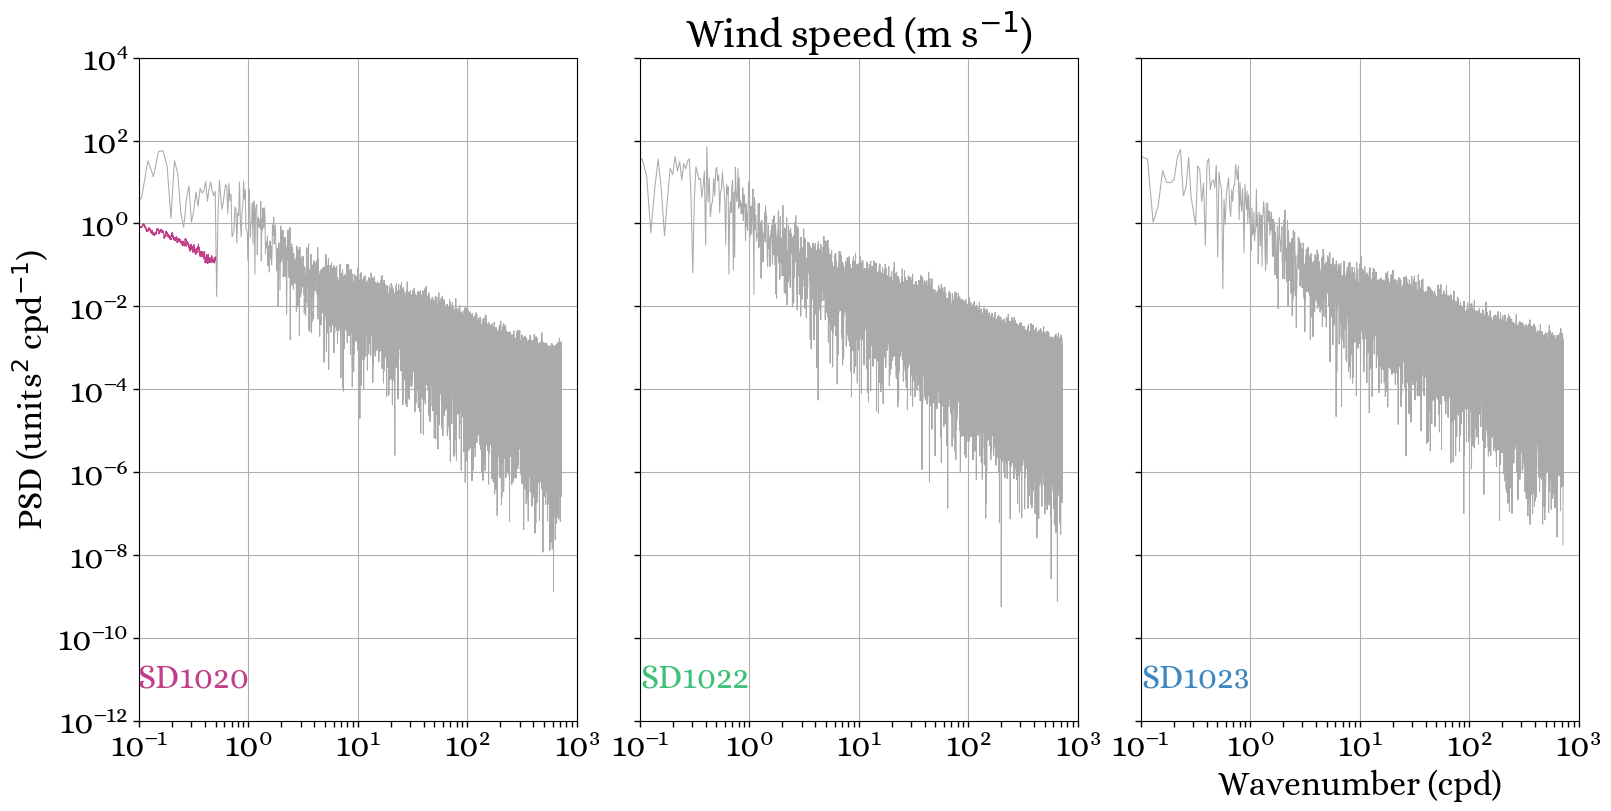

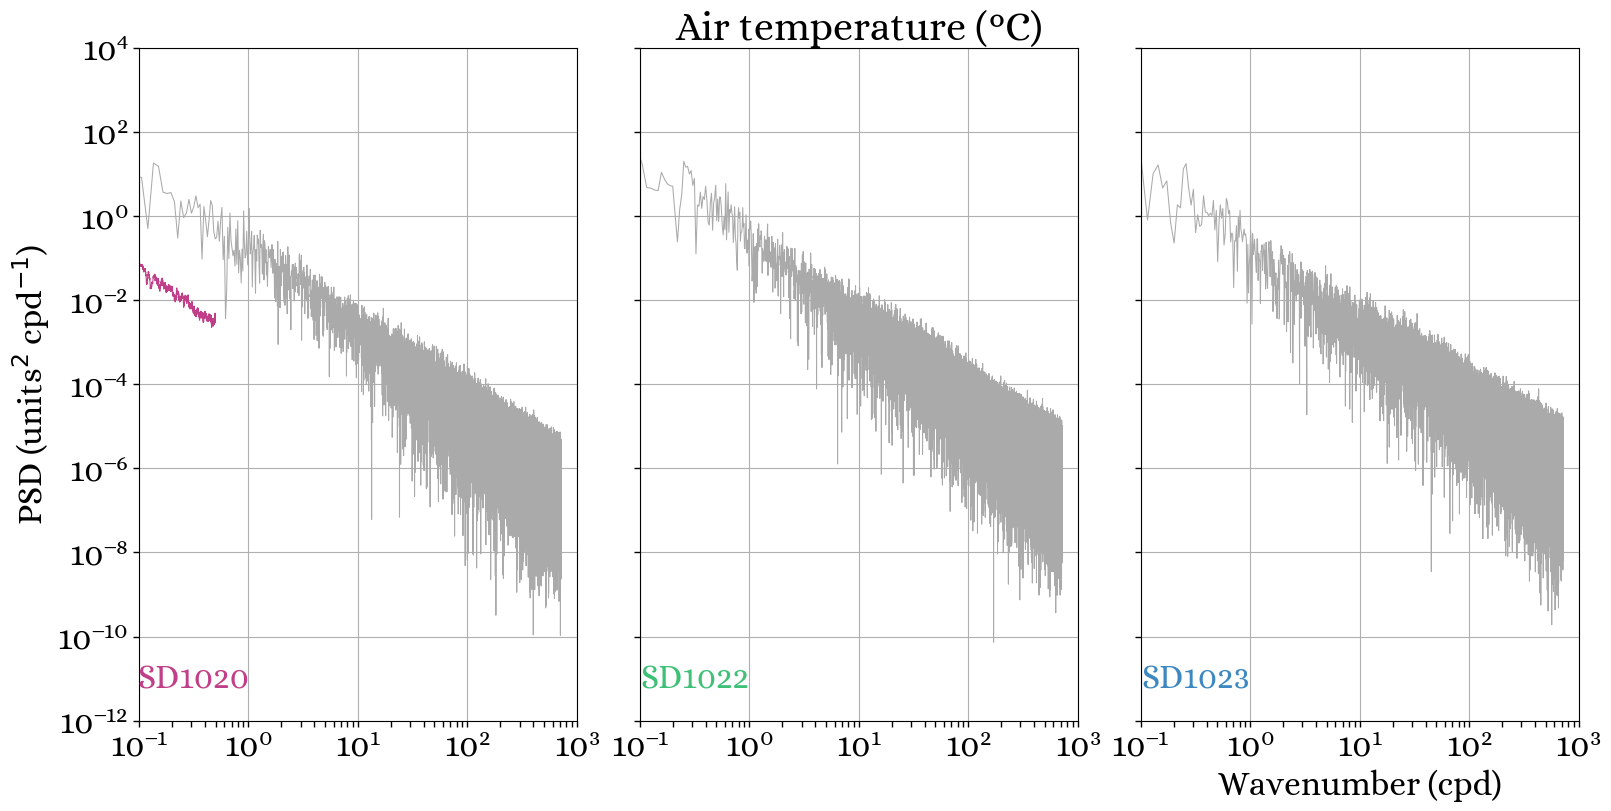

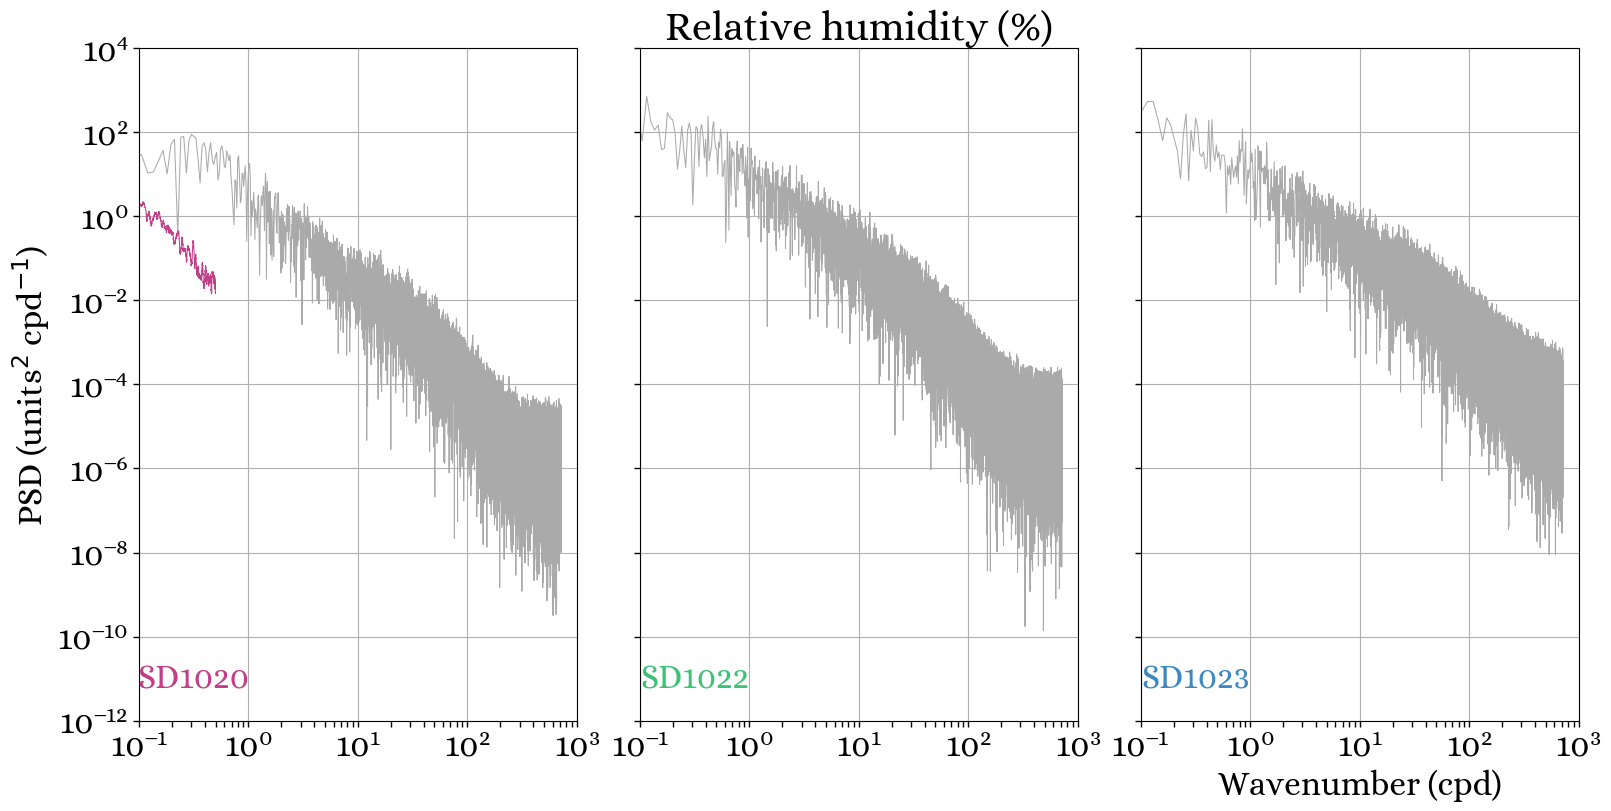

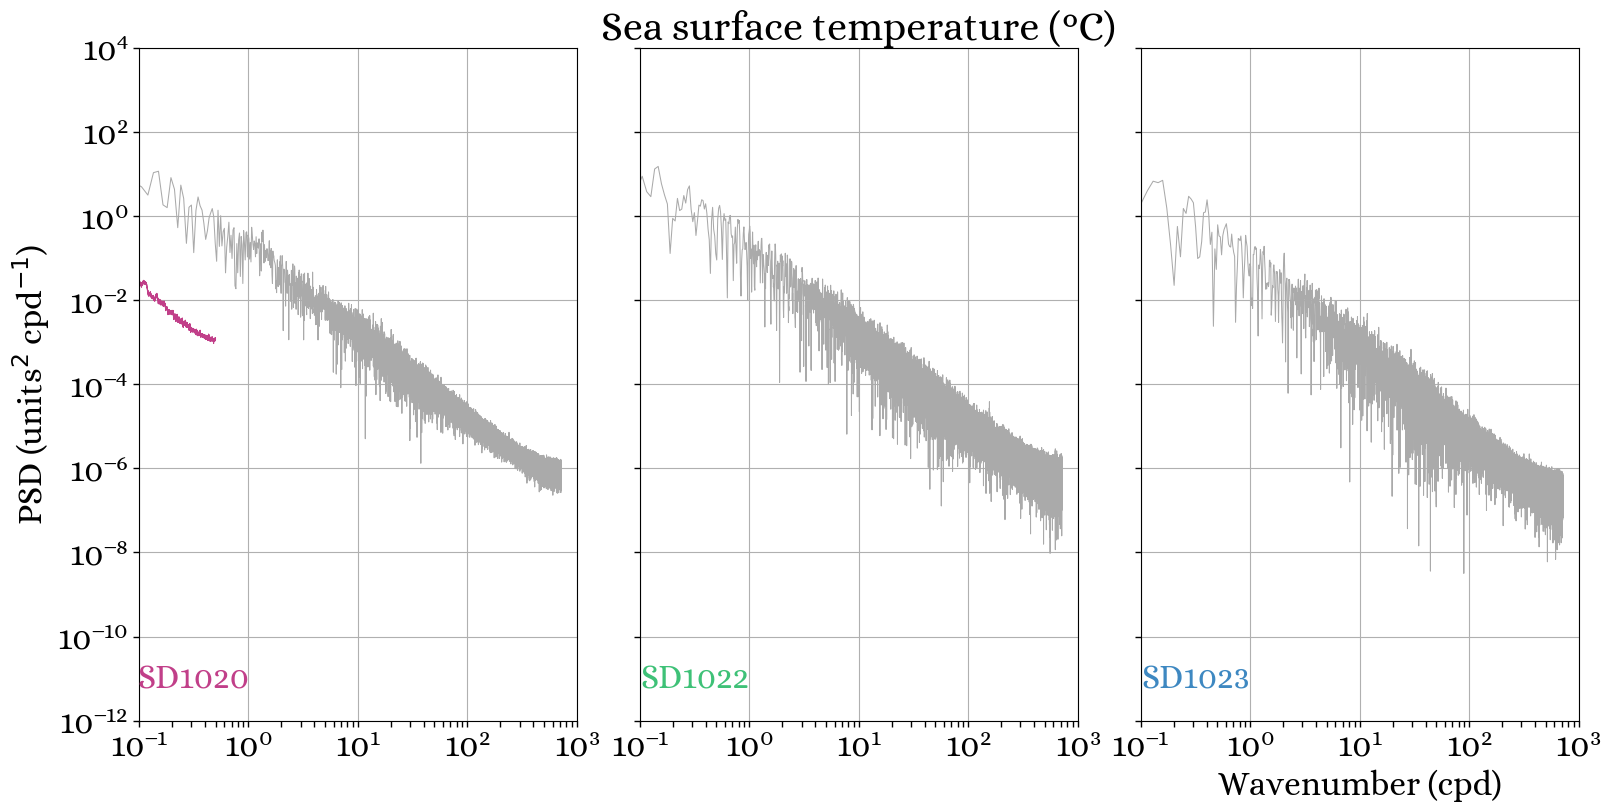

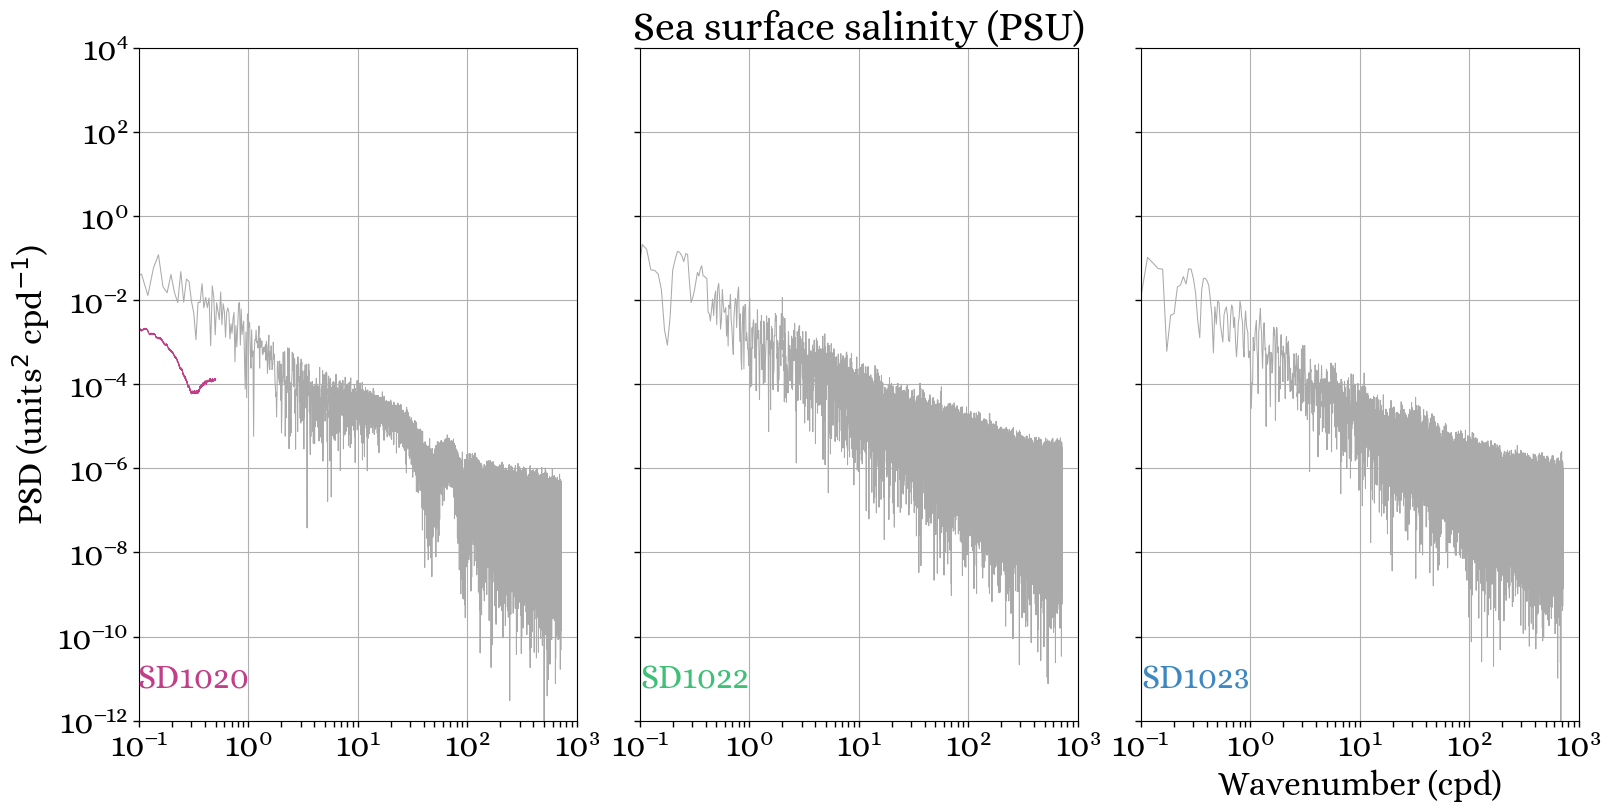

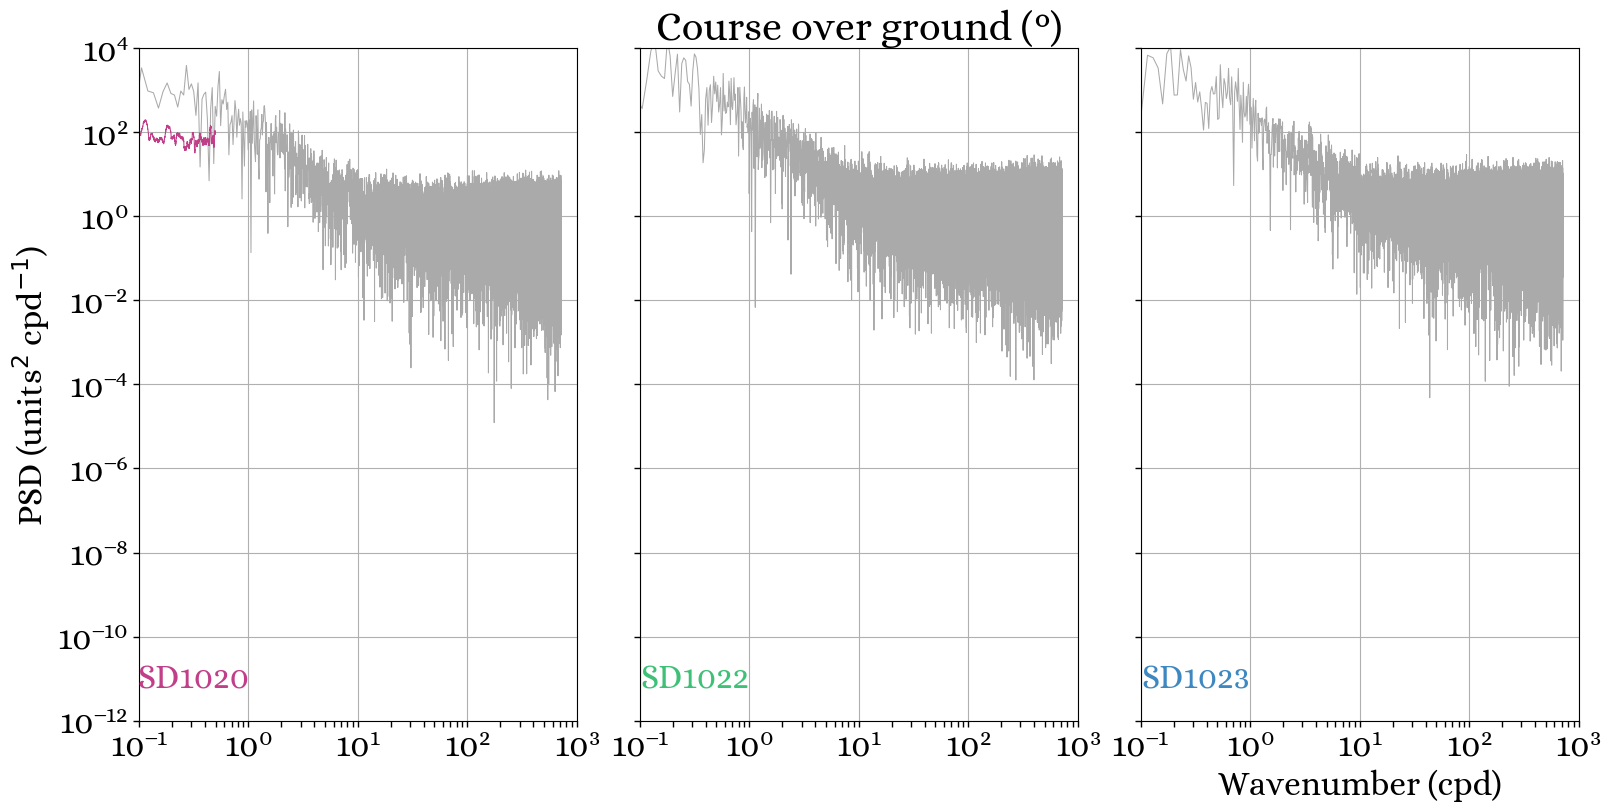

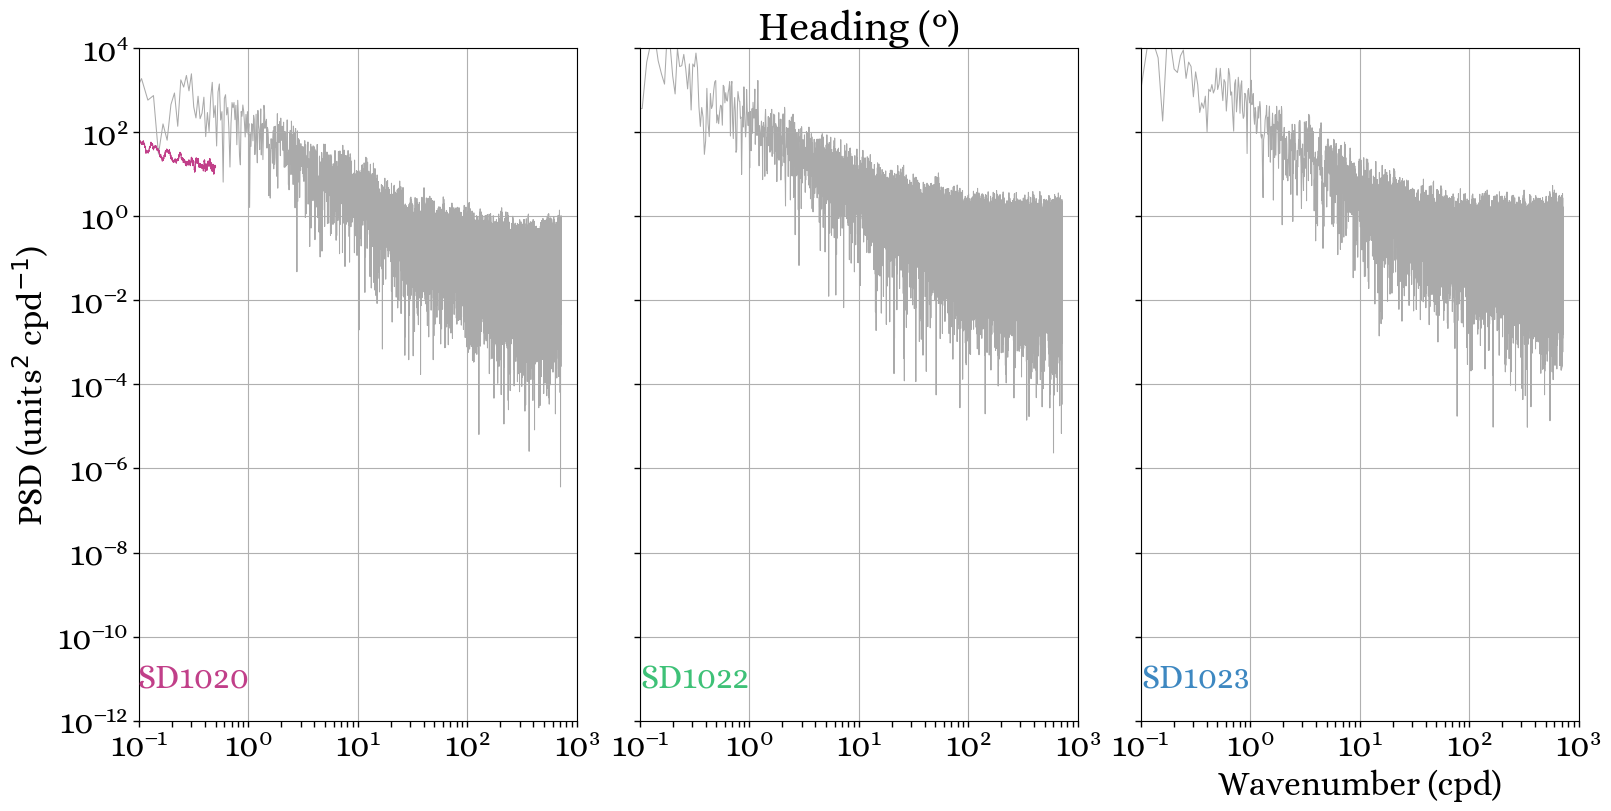

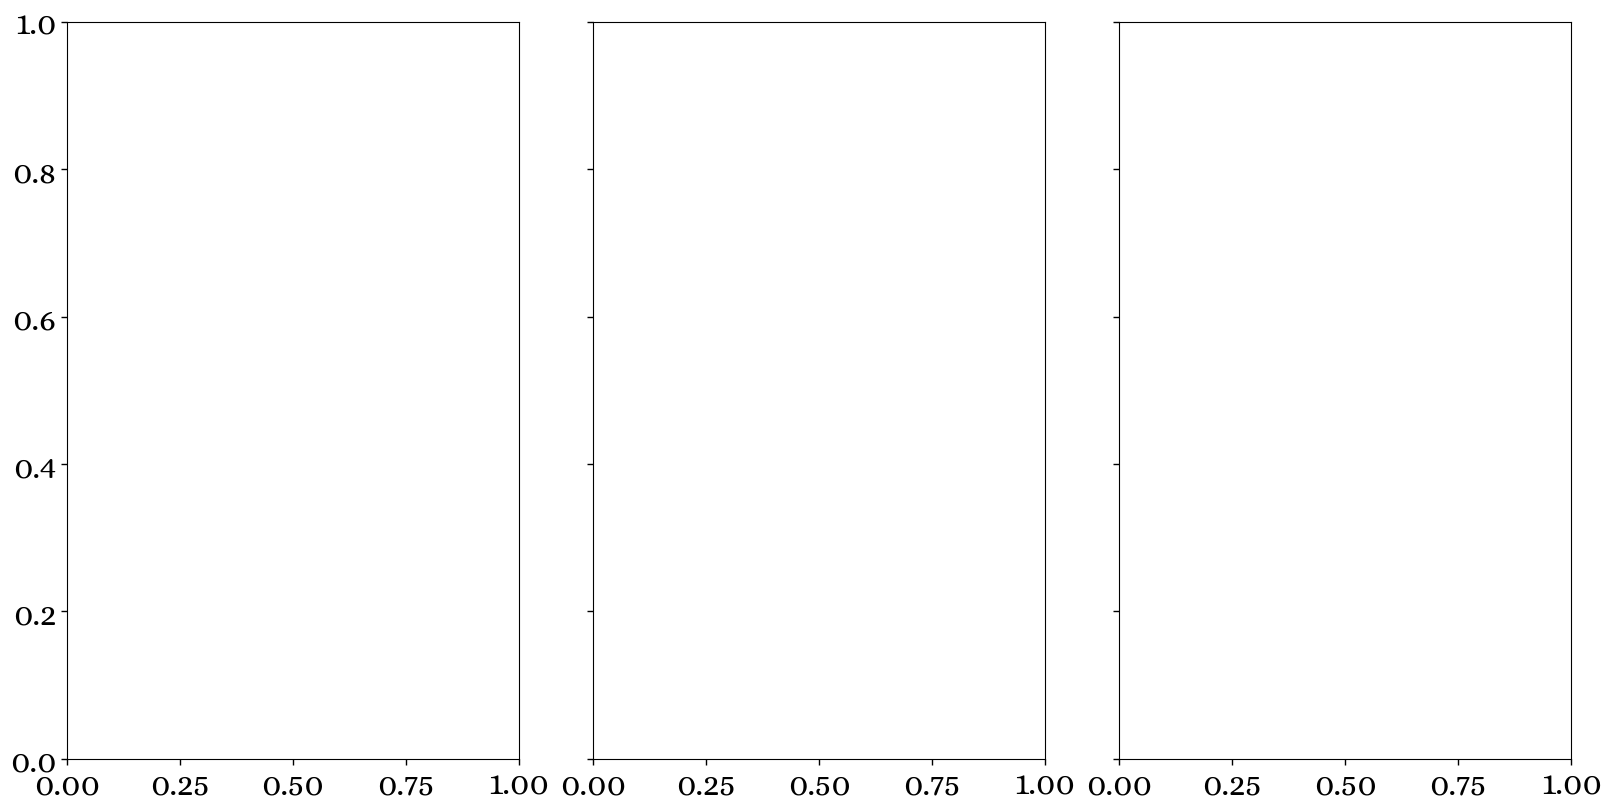

In [524]:
for k in range(8):
    # Create a grid of subplots with 3 rows and 5 columns
    fig, ax = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True, sharex=True, sharey=True)

    # Iterate over each subplot row (i), dataset (ds), label (l), and color (c) using enumerate
    for i, (AX, ds, l, c, ms, f0, S0) in enumerate(zip(ax, datasets, labels, colors, km_mt32, f0s, S0s)):
        # Iterate over each subplot column (j), variable (var), title (t), and unit (u) using enumerate
        for j, (axs, var, t, u, spec,f,S) in enumerate(zip([AX], names[k:], titles[k:], units[k:], ms[k:], f0[k:], S0[k:])):
            # Plot the periodogram and multitaper spectrum
            axs.loglog(f[np.where(f >= 0)], S[np.where(f >= 0)], linewidth=0.75, c="#AAAAAA")  # Periodogram
            axs.loglog(spec.freq[np.where(spec.freq >= 0)], spec.spec[np.where(spec.freq >= 0)], linewidth=0.75, c=c)  # Multitaper spectrum
            # Add label to the subplot
            axs.text(3.16e-1, 1e-11, l, c=c, va='center', ha='center', fontweight='bold')

            # Adjust subplot properties
            axs.autoscale(enable=True, tight=True)
            axs.set(xlim=(1e-1, 1e3),
                    ylim=(1e-12, 1e4),
                    xlabel="Wavenumber (cpd)" if "1023" in l else "" ,
                    ylabel='PSD (units$^{2}$ cpd$^{-1}$)' if i==0 else "", 
                    title=t+f" ({u})" if "1022" in l else "")
            axs.grid()

#             idx = np.where(spec.spec[np.where(spec.freq >= 0)] > np.percentile(spec.spec[np.where(spec.freq >= 0)],99.95))[0][-1]

#             # Plot reference slope
#             plot_ref_slope(spec.freq[np.where(spec.freq >= 0)][idx],
#                            3e2, 
#                            spec.spec[np.where(spec.freq >= 0)][idx], ax=axs, kvec=[1, 2, 3], col='k')

#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e0,1e1)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e1,1e2)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
#             trend,slope,intercept,xvalue,confidence_interval = plot_slope(f,S,1,1e2,1e3)
#             axs.loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)

## Use Iss' 2020 functions

In [40]:
from scipy.io.matlab import mio
import numpy as np
import spectrum as sp
from scipy import stats


def pmtmPH(x,dt=1.,nw=3,nfft=None):
    """
    function [P,s,ci] = pmtmPH(x,dt,nw,qplot,nfft);
    Computes the power spectrum using the multi-taper method with adaptive weighting.
    Inputs:
    x      - Input data vector.
    dt     - Sampling interval, default is 1.
    nw     - Time bandwidth product, acceptable values are
    0:.5:length(x)/2-1, default is 3.  2*nw-1 dpss tapers
    are applied except if nw=0 a boxcar window is applied 
    and if nw=.5 (or 1) a single dpss taper is applied.
    qplot  - Generate a plot: 1 for yes, else no.  
    nfft   - Number of frequencies to evaluate P at, default is
    length(x) for the two-sided transform. 
    Outputs:
    P      - Power spectrum computed via the multi-taper method.
    s      - Frequency vector.
    ci     - 95% confidence intervals. Note that both the degrees of freedom
    calculated by pmtm.m and chi2conf.m, which pmtm.m calls, are
    incorrect.  Here a quick approximation method is used to
    determine the chi-squared 95% confidence limits for v degrees
    of freedom.  The degrees of freedom are close to but no larger
    than (2*nw-1)*2; if the degrees of freedom are greater than
    roughly 30, the chi-squared distribution is close to Gaussian.
    The vertical ticks at the top of the plot indicate the size of
    the full band-width.  The distance between ticks would remain
    fixed in a linear plot.  For an accurate spectral estimate,
    the true spectra should not vary abruptly on scales less than
    the full-bandwidth.
    Other toolbox functions called: dpps.m; and if nfft does not equal length(x)    , cz.m
    Peter Huybers
    MIT, 2003
    phuybers@mit.edu

    Adapted from Matlab to Python by Nicolas Barrier"""

    if nfft is None:
        nfft=len(x)

    nx=len(x)
    k=np.min([np.round(2*nw),nx])
    k=np.max([k-1,1])
    s=np.arange(0,1/dt,1/(nfft*dt));
    w=nw/(dt*nx) # half-bandwidth of the dpss
    
    E,V=sp.dpss(nx,NW=nw,k=k)
 
    if nx<=nfft:
        tempx=np.transpose(np.tile(x,(k,1)))
        Pk=np.abs(np.fft.fft(E*tempx,n=nfft,axis=0))**2
    else:
        raise IOError('Not implemented yet')
    
    #Iteration to determine adaptive weights:    
    if k>1:
        xmat=np.mat(x).T
        sig2 = xmat.T*xmat/nx; # power
        P    = (Pk[:,0]+Pk[:,1])/2.;   # initial spectrum estimate
        Ptemp= np.zeros(nfft);
        P1   = np.zeros(nfft);
        tol  = .0005*sig2/nfft;    
        a    = sig2*(1-V);
        while np.sum(np.abs(P-P1)/nfft)>tol:
            Pmat=np.mat(P).T
            Vmat=np.mat(V)
            amat=np.mat(a)
            temp1=np.mat(np.ones((1,k)))
            temp2=np.mat(np.ones((nfft,1)))
            b=(Pmat*temp1)/(Pmat*Vmat+temp2*amat); # weights
            temp3=np.mat(np.ones((nfft,1)))*Vmat
            temp3=np.array(temp3)
            b=np.array(b)
            wk=b**2*temp3       
            P1=np.sum(wk*Pk,axis=1)/np.sum(wk,axis=1)
            Ptemp=P1; P1=P; P=Ptemp;                 # swap P and P1

        #b2=b**2
        #temp1=np.mat(np.ones((nfft,1)))*V
        temp1=b**2
        temp2=np.mat(np.ones((nfft,1)))*Vmat
        num=2*np.sum(temp1*np.array(temp2),axis=1)**2
        
        temp1=b**4
        temp2=np.mat(np.ones((nfft,1)))*np.mat(V**2)
        den=np.sum(temp1*np.array(temp2),axis=1)
        v=num/den
        
    select=np.arange(0,(nfft+1)/2+1).astype(np.int64)
    P=P[select]
    s=s[select]
    v=v[select]

    temp1=1/(1-2/(9*v)-1.96*np.sqrt(2./(9*v)))**3
    temp2=1/(1-2/(9*v)+1.96*np.sqrt(2/(9*v)))**3

    ci=np.array([temp1,temp2])
    
    return P,s,ci

def JD_spectra(ts,dt,ax,f,nrj=0,nw=3,unit='unit',col='k'):

    """
    % calculates multitaper spectra using pmtmPH.m 
    % Author: J. Deshayes, CNRS IRD, March 2013

    Arguments:
    ts=time series whose spectrum to plot. 
    dt=time step of ts in seconds
    ax=the axes in which the drawing has to be done
    f=the frequency where to do draw the errorbar

    Optional arguments:
    nrj=0 for a variance spectrum, 1 for an energy spectrum (F*Px)
    nw=3 (multitaper used 2*nw-1 tapers)
    unit='unit': label of the yaxis
    col='k': color of the line

    Returns:
    Px=the vector of spectrum
    F=the vector of frequency
    PxC=the vector of error bar

    Adapted from Matlab to Python by Nicolas Barrier"""
    
    T=len(ts)
    ts=ts-np.mean(ts)
    [Px,F,Pxc]=pmtmPH(ts,nw=nw);

    F=F*365*86400/dt;    # to get the result in cpy
    Px=Px/(365*86400/dt);    # to get the result in cpy^{-1}
    Pxc=Pxc/(365*86400/dt);    # to get the result in cpy^{-1}
    barmax=Pxc[0,0]*1e2;
    barmin=Pxc[1,0]*1e2;

    if nrj==0:
        hh=ax.loglog(F,Px,color=col);
        ax.set_ylabel('power spectrum density ('+ unit+ '$^2$ cpy$^{-1}$)');
        ax.loglog([f, f],[barmin, barmax],color=col,marker='_');

    else:     
        hh=ax.loglog(F,F*Px,color=col);
        ax.set_ylabel('Energy power spectrum F*Px ('+ unit +'$^2$)');
        
    ax.set_xlabel('frequency (cpy)')
    ax.grid(True,which='both',axis='x')
    ax.grid(True,which='major',axis='y')

    return Px,F,Pxc

def JD_space_spectra(ts,dl,ax,f,nw=3,unit='unit',col='k'):

    """
    % calculates multitaper spectra using pmtmPH.m 
    % Author: J. Deshayes, CNRS IRD, March 2013

    Arguments:
    ts=time series whose spectrum to plot. 
    dl=spatial step of ts in km 
    ax=the axes in which the drawing has to be done
    f=the frequency where to do draw the errorbar

    Optional arguments:
    nw=3 (multitaper used 2*nw-1 tapers)
    unit='unit': label of the yaxis
    col='k': color of the line

    Returns:
    Px=the vector of spectrum
    F=the vector of frequency
    PxC=the vector of error bar

    Adapted from Matlab to Python by Nicolas Barrier"""

    T=len(ts)
    ts=ts-np.mean(ts)
    [Px,F,Pxc]=pmtmPH(ts,nw=nw);

    F=F/dl;    # to get the result in cpy
    Px=Px*dl;    # to get the result in cpy^{-1}
    Pxc=Pxc*dl;    # to get the result in cpy^{-1}
    barmax=Pxc[0,0]*1e2;
    barmin=Pxc[1,0]*1e2;

    hh=ax.loglog(F,Px,color=col);
    ax.set_ylabel('power spectrum density ('+ unit+ ' cpkm$^{-1}$)');
    ax.loglog([f, f],[barmin, barmax],color=col,marker='_');

    ax.set_xlabel('wavenumber (cpkm)')
    ax.grid(True,which='both',axis='x')
    ax.grid(True,which='major',axis='y')

    return Px,F,Pxc,hh

def plot_slope(Px,F,ax,fmin=None,fmax=None,col='k',lin='--',lw=2,offy=1):

    """ This function draws the slope of the spectrum
    Arguments:
    Px=the vector of spectrum
    F=the vector of frequency
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    fmin=None (if fmin=None, takes the min of F): frequency minimum where the slope is computed
    fmax=None (if fmax=None, takes the max of F): frequency maximum where the slope is computed
    col='k': color of the slope
    lin='--': linestyle of the slope
    lw=2: linewidth of the slope
    offy=1: y offset of the slope
    
    Outputs:
    The value of the slope

    Author: Nicolas Barrier
    """

    if fmin==None:
        fmin=F.min()
    if fmax==None:
        fmax=F.max()

    i=np.nonzero((F>=fmin)&(F<=fmax)&(F!=0))[0]
    fout=F[i]
    pxout=Px[i]

    y=np.log(pxout)
    x=np.log(fout)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    confidence_interval = 2.58*std_err #99%
    
    p=np.polyfit(x,y,1)
    
    trend=np.exp(p[0]*x+p[1]+offy)
    
    ax.loglog(fout,trend,color=col,linestyle=lin,lw=lw)

    # add regression slope and confidence interval 


    return p[0]	, slope, confidence_interval
    
def plot_ref_slope(fmin,fmax,f,ax,kvec=[2],col='k',lw=2,ls='--'):

    """ This function draws reference slopes (k=-2, k=-4 for instance)
    Arguments:
    fmin=frequency where to start the reference the slope
    fmax=fmin=frequency where to end the reference the slope
    f= y intercept of the slope
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    kvec=[2]: list containing the reference values of k, whose slope to draw
    col='k': colors of the slopes
    lw=2: linewidths of the slopes
    ls=--: linestyles of the slopes

    Author: Nicolas Barrier
    """
	
    x=np.linspace(fmin,fmax,5)
    
    for p in range(0,len(kvec)):
        k=kvec[p]
        y=np.log(f)+k*(np.log(fmin)-np.log(x[:]))
        yout=np.exp(y)
        ax.loglog(x,yout,color=col,linewidth=lw,linestyle=ls)
        ax.text(x[-1],yout[-1],' k = -'+str(k),ha='center',va='center',color=col,
        bbox=dict(boxstyle="round", fc="0.9"))

In [42]:
def plot_slope(xf,yf,N,fmin,fmax):
    """
    Output slope of spectral using defined boundaries
    """
    
    i=np.nonzero((xf>=fmin)&(xf<=fmax)&(xf!=0))[0]
    xf=xf[i]
    yf=yf[i]
    
    
    
   # y=2.0/N * np.abs(yf[0:N//2])
    Y=np.log(yf)
    X=np.log(xf)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

    #confidence_interval = 2.58*std_err #99%
    confidence_interval = 1.96*std_err #95%


    p=np.polyfit(X,Y,1)

    offy=1

    trend=np.exp(p[0]*X+p[1]+offy)
    xvalue=xf
    return trend,slope,xvalue,confidence_interval

# from spectrum import *
# from JD_multitaper import JD_spectra  
from scipy.fftpack import fft
from scipy import signal
# from JD_multitaper import JD_space_spectra,plot_ref_slope # spectra calculated from code provided by
                                                                        #J. Deshayes, CNRS IRD, March 2013
from scipy import stats

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

from scipy.io.matlab import mio
import numpy as np
import spectrum as sp
from scipy import stats


def pmtmPH(x,dt=1.,nw=3,nfft=None):
    """
    function [P,s,ci] = pmtmPH(x,dt,nw,qplot,nfft);
    Computes the power spectrum using the multi-taper method with adaptive weighting.
    Inputs:
    x      - Input data vector.
    dt     - Sampling interval, default is 1.
    nw     - Time bandwidth product, acceptable values are
    0:.5:length(x)/2-1, default is 3.  2*nw-1 dpss tapers
    are applied except if nw=0 a boxcar window is applied 
    and if nw=.5 (or 1) a single dpss taper is applied.
    qplot  - Generate a plot: 1 for yes, else no.  
    nfft   - Number of frequencies to evaluate P at, default is
    length(x) for the two-sided transform. 
    Outputs:
    P      - Power spectrum computed via the multi-taper method.
    s      - Frequency vector.
    ci     - 95% confidence intervals. Note that both the degrees of freedom
    calculated by pmtm.m and chi2conf.m, which pmtm.m calls, are
    incorrect.  Here a quick approximation method is used to
    determine the chi-squared 95% confidence limits for v degrees
    of freedom.  The degrees of freedom are close to but no larger
    than (2*nw-1)*2; if the degrees of freedom are greater than
    roughly 30, the chi-squared distribution is close to Gaussian.
    The vertical ticks at the top of the plot indicate the size of
    the full band-width.  The distance between ticks would remain
    fixed in a linear plot.  For an accurate spectral estimate,
    the true spectra should not vary abruptly on scales less than
    the full-bandwidth.
    Other toolbox functions called: dpps.m; and if nfft does not equal length(x)    , cz.m
    Peter Huybers
    MIT, 2003
    phuybers@mit.edu

    Adapted from Matlab to Python by Nicolas Barrier"""
   # print(len(x))
    if nfft is None:
        nfft=len(x)

    nx=len(x)
    k=np.min([np.round(2*nw),nx])
    k=np.max([k-1,1])
    s=np.arange(0,1/dt,1/(nfft*dt));
    w=nw/(dt*nx) # half-bandwidth of the dpss
    
    E,V=sp.dpss(nx,NW=nw,k=k)
 
    if nx<=nfft:
        tempx=np.transpose(np.tile(x,(k,1)))
        Pk=np.abs(np.fft.fft(E*tempx,n=nfft,axis=0))**2
    else:
        raise IOError('Not implemented yet')
    
    #Iteration to determine adaptive weights:    
    if k>1:
        xmat=np.mat(x).T
        sig2 = xmat.T*xmat/nx; # power
        P    = (Pk[:,0]+Pk[:,1])/2.;   # initial spectrum estimate
        Ptemp= np.zeros(nfft);
        P1   = np.zeros(nfft);
        tol  = .0005*sig2/nfft;    
        a    = sig2*(1-V);
        while np.sum(np.abs(P-P1)/nfft)>tol:
            Pmat=np.mat(P).T
            Vmat=np.mat(V)
            amat=np.mat(a)
            temp1=np.mat(np.ones((1,k)))
            temp2=np.mat(np.ones((nfft,1)))
            b=(Pmat*temp1)/(Pmat*Vmat+temp2*amat); # weights
            temp3=np.mat(np.ones((nfft,1)))*Vmat
            temp3=np.array(temp3)
            b=np.array(b)
            wk=b**2*temp3       
            P1=np.sum(wk*Pk,axis=1)/np.sum(wk,axis=1)
            Ptemp=P1; P1=P; P=Ptemp;                 # swap P and P1

        #b2=b**2
        #temp1=np.mat(np.ones((nfft,1)))*V
        temp1=b**2
        temp2=np.mat(np.ones((nfft,1)))*Vmat
        num=2*np.sum(temp1*np.array(temp2),axis=1)**2
        
        temp1=b**4
        temp2=np.mat(np.ones((nfft,1)))*np.mat(V**2)
        den=np.sum(temp1*np.array(temp2),axis=1)
        v=num/den
        
    select=np.arange(0,(nfft+1)/2+1).astype(np.int64)
    P=P[select]
    s=s[select]
    v=v[select]
  #  print(v.shape)

    temp1=1/(1-2/(9*v)-1.96*np.sqrt(2./(9*v)))**3
    temp2=1/(1-2/(9*v)+1.96*np.sqrt(2/(9*v)))**3

    ci=np.array([temp1,temp2])
    
    return P,s,ci


def plot_ref_slope(fmin,fmax,f,ax,kvec=[2,3],col='Grey',lw=2,ls='--'):

    """ This function draws reference slopes (k=-2, k=-4 for instance)
    Arguments:
    fmin=frequency where to start the reference the slope
    fmax=fmin=frequency where to end the reference the slope
    f= y intercept of the slope
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    kvec=[2]: list containing the reference values of k, whose slope to draw
    col='k': colors of the slopes
    lw=2: linewidths of the slopes
    ls=--: linestyles of the slopes

    Author: Nicolas Barrier
    """

    x=np.linspace(fmin,fmax,5)
    
    for p in range(0,len(kvec)):
        k=kvec[p]
        y=np.log(f)+k*(np.log(fmin)-np.log(x[:]))
        yout=np.exp(y)
        ax.loglog(x,yout,color=col,linewidth=lw,linestyle=ls)
        #ax.text(x[-3],yout[-1],' k = -'+str(k),ha='center',va='center',color=col,fontsize='12')
        #bbox=dict(boxstyle="round", fc="0.9"))

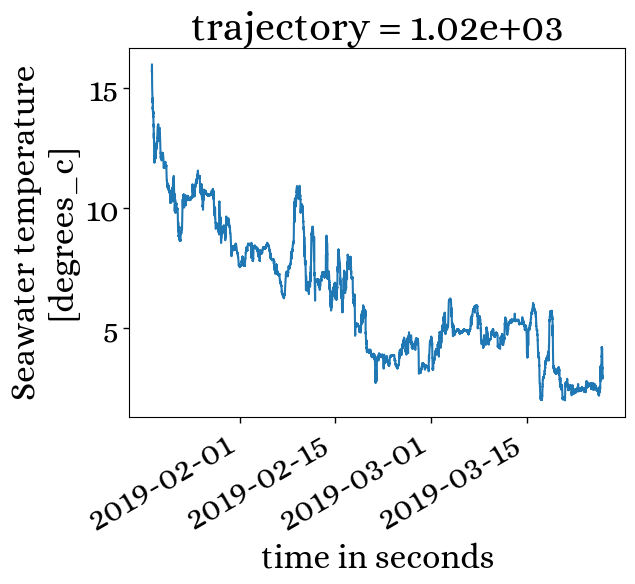

In [48]:
ds20.isel(time=slice(0,95000))['sst'].plot()

In [16]:
fig,ax=plt.subplots(1,3,figsize=[16,7],sharey=True)
#########

i=0
h_detrended2 = detrend(ds20['sst']) # detrend
PEm,sEm,ciEm =pmtmPH(h_detrended2,nw=3)

ax[0].loglog(sEm ,PEm,label='M1 (Early Summer)',c='tab:blue',alpha=1)
barmax=ciEm[0,0]*PEm;
barmin=ciEm[1,0]*PEm;
ax[0].fill_between(sEm,barmin,barmax, facecolor='tab:blue', alpha=0.1)

trend,slope,xvalue,conf_interval=plot_slope(sEm,PEm,len(h_detrended2),fmin=0.02,fmax=0.35)
ax[0].loglog(xvalue,trend,color=blue2)

print(slope,conf_interval)

i=36
h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
PLm,sLm,ciLm =pmtmPH(h_detrended2,nw=3)

ax[0].loglog(sLm ,PLm,label='M2 (Late Summer)',c=red1,alpha=1)
barmax=ciLm[0,0]*PLm;
barmin=ciLm[1,0]*PLm;
ax[0].fill_between(sLm,barmin,barmax, facecolor=red1, alpha=0.1)

trend,slope,xvalue,conf_interval=plot_slope(sLm,PLm,len(h_detrended2),fmin=0.02,fmax=0.35)
ax[0].loglog(xvalue,trend,color=red2)

print(slope,conf_interval)
ax[0].legend()
###################################

ax[0].set_title('Mesoscale Transects')

ax[1].set_title('SMS Early Summer')
ax[2].set_title('SMS Late Summer')

P_all_early=[]
s_all_early=[]
for i in range(3,25,1):
    h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
    P,s,ci =pmtmPH(h_detrended2,nw=3)
    P_all_early.append(P)
    s_all_early.append(s)
    ax[1].loglog(s,P,label='early',c='tab:blue',alpha=0.2)
    barmax=ci[0,0]*P;
    barmin=ci[1,0]*P;
    ax[1].fill_between(s,barmin,barmax, facecolor='tab:blue', alpha=0.1)
    trend,slope,xvalue,conf_interval=plot_slope(s,P,len(h_detrended2),fmin=0.11,fmax=0.35)
#    ax[0].loglog(xvalue,trend,color='k',label=np.round(slope,2))
#    ax[0].set_xlim(0.07,1)
    print(slope)

P_all_early=np.array(P_all_early,dtype='object')
s_all_early=np.array(s_all_early,dtype='object')   

fs=np.linspace(0,0.5,25)
P_interp_early=[]
for i in range(0,17,1):
    P_interp_early.append(np.interp(fs,s_all_early[i],P_all_early[i]))
P_interp_early=np.array(P_interp_early)
P_mean_early=np.nanmean(P_interp_early,0)
ax[1].loglog(fs,P_mean_early,c='blue',linewidth=5)

from scipy.stats import chi2

probability = 0.95

#P is the number of estimates in welch function
#and also the degree of freedom.
alfa = 1 - probability
v = 2 * len(fs)
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c
Pxxc_lower = P_mean_early * c[0]
Pxxc_upper = P_mean_early * c[1]


ax[1].loglog(fs,Pxxc_lower,c='darkblue',linewidth=2)
ax[1].loglog(fs,Pxxc_upper,c='darkblue',linewidth=2)
print(fs)
#ax[1].set_xlim(0.07,0.6e0)


trend,slope,xvalue,conf_interval=plot_slope(fs,P_mean_early,len(P_mean_early),fmin=0.11,fmax=0.35)
print(slope,conf_interval)
ax[1].loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)    
    
P_all_late=[]
s_all_late=[]
for i in range(37,52,1):

    h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
    P,s,ci =pmtmPH(h_detrended2,nw=3)
    P_all_late.append(P)
    s_all_late.append(s)
    ax[2].loglog(s,P,label='late',c='orange',alpha=0.2)
    barmax=ci[0,0]*P;
    barmin=ci[1,0]*P;
    ax[2].fill_between(s,barmin,barmax, facecolor='orange', alpha=0.1)

    trend,slope,xvalue,conf_interval=plot_slope(s,P,len(h_detrended2),fmin=0.11,fmax=0.35)
    #plt.loglog(xvalue,trend,color='k',label=np.round(slope,2))
 #   ax[2].set_xlim(0.07,0.6e0)
    print(slope)
P_all_late=np.array(P_all_late,dtype='object')
s_all_late=np.array(s_all_late,dtype='object')

fs=np.linspace(0,0.5,25)
P_interp_late=[]
for i in range(0,15,1):
    P_interp_late.append(np.interp(fs,s_all_late[i],P_all_late[i]))
P_interp_late=np.array(P_interp_late)
P_mean_late=np.nanmean(P_interp_late,0)
ax[2].loglog(fs,P_mean_late,c='red',linewidth=5)

#P is the number of estimates in welch function
#and also the degree of freedom.
alfa = 1 - probability
v = 2 * len(fs)
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c
Pxxc_lower = P_mean_late * c[0]
Pxxc_upper = P_mean_late * c[1]

ax[2].loglog(fs,Pxxc_lower,c='darkred',linewidth=2)
ax[2].loglog(fs,Pxxc_upper,c='darkred',linewidth=2)

trend,slope,xvalue,conf_interval=plot_slope(fs,P_mean_late,len(P_mean_late),fmin=0.11,fmax=0.35)
print(slope,conf_interval)
ax[2].loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
    
    
plot_ref_slope(0.02,0.33,1e-5,ax=ax[2])
plot_ref_slope(0.02,0.33,1e-5,ax=ax[1])
plot_ref_slope(0.02,0.33,1e-4,ax=ax[0])

ax[0].set_xlabel('wavenumber (cpkm)')
ax[1].set_xlabel('wavenumber (cpkm)')
ax[2].set_xlabel('wavenumber (cpkm)')

ax[0].set_ylabel('Power Spectrum Density (kg m$^{-3}$)$^2$ cpkm$^{-1}$ )')


ax[1].text(0.18,1e-2,'N=17')
ax[2].text(0.18,1e-2,'N=15')

ax[0].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)
ax[1].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)
ax[2].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)

plt.savefig('results/density_spectra.pdf',bbox_inches='tight',dpi=75)

In [37]:
new_names = np.array(new_names)